# Math 86 Final Project Jupyter Notebook
## Authors: Henry Morris, Charlier Morris, and Zach Wang

### Needed libraries

In [165]:
import pandas as pd
import numpy as np
import seaborn as sns
from py_vollib.black_scholes import black_scholes as bs
import zipfile
from mpl_toolkits.mplot3d import Axes3D
from datetime import timedelta
import matplotlib.pyplot as plt
import statsmodels.api as sm

### Nvidia Inspiration for the project

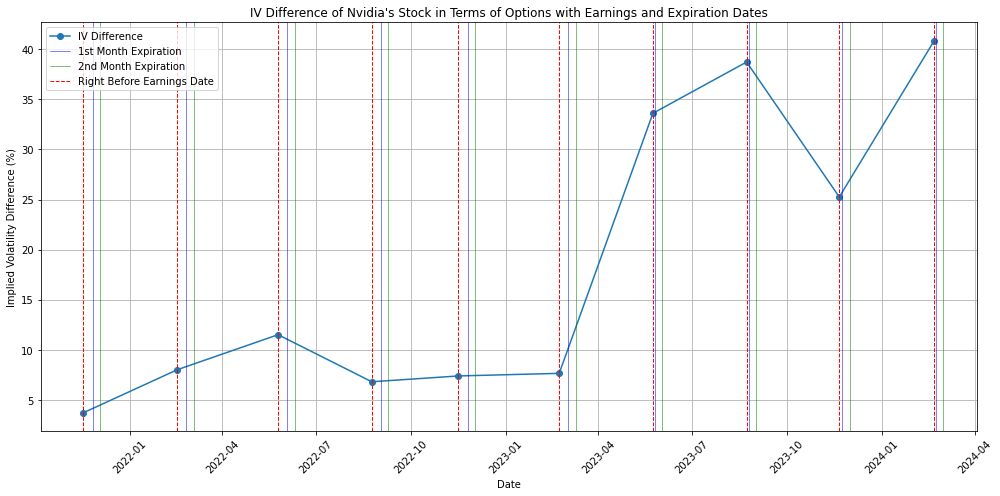

In [166]:
#Nvidia stock data
data = {
    "Period": ["FQ3 2022", "FQ4 2022", "FQ1 2023", "FQ2 2023", "FQ3 2023", "FQ4 2023", "FQ1 2024", "FQ2 2024", "FQ3 2024", "FQ4 2024"],
    "Date": ["20211117", "20220216", "20220525", "20220824", "20221116", "20230222", "20230524", "20230823", "20231121", "20240221"],
    "1st Month Expiration": ["11/26/2021", "02/25/2022", "06/03/2022", "09/02/2022", "11/25/2022", "03/03/2023", "05/26/2023", "08/25/2023", "11/24/2023", "02/23/2024"],
    "2nd Month Expiration": ["12/03/2021", "03/04/2022", "06/10/2022", "09/09/2022", "12/02/2022", "03/10/2023", "06/02/2023", "09/01/2023", "12/01/2023", "03/01/2024"],
    "1st Month IV": [57.22, 76.24, 95.63, 63.21, 73.48, 71.43, 93.62, 126.54, 86.01, 125.90],
    "2nd Month IV": [53.51, 68.24, 84.13, 56.41, 66.10, 63.79, 60.01, 87.81, 60.76, 85.07]
}

# Create DataFrame
df = pd.DataFrame(data)

# Convert date strings to datetime objects for plotting
df['1st Month Expiration'] = pd.to_datetime(df['1st Month Expiration'])
df['2nd Month Expiration'] = pd.to_datetime(df['2nd Month Expiration'])
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')


# Calculate IV Difference
df['IV Difference'] = df['1st Month IV'] - df['2nd Month IV']

# Plotting the IV Difference with vertical lines for earnings dates, option expiration dates, and a key for the lines
plt.figure(figsize=(14, 7))

# Plot the IV Difference
plt.plot(df['Date'].values, df['IV Difference'].values, marker='o', label='IV Difference')

# Add vertical lines for 1st and 2nd month option expirations
for first_exp, second_exp, third_exp in zip(df['1st Month Expiration'], df['2nd Month Expiration'], df["Date"]):
    plt.axvline(x=first_exp, color='blue', linestyle='-', lw=0.5, label='1st Month Expiration' if first_exp == df['1st Month Expiration'][0] else "")
    plt.axvline(x=second_exp, color='green', linestyle='-', lw=0.5, label='2nd Month Expiration' if second_exp == df['2nd Month Expiration'][0] else "")
    plt.axvline(x=third_exp, color='red', linestyle='--', lw=1, label='Right Before Earnings Date' if third_exp == df['Date'][0] else "")

# Adding labels and title
plt.title("IV Difference of Nvidia's Stock in Terms of Options with Earnings and Expiration Dates")
plt.xlabel('Date')
plt.ylabel('Implied Volatility Difference (%)')

# Create legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # removing duplicate labels
plt.legend(by_label.values(), by_label.keys())

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout() # Adjust layout to prevent clipping of tick-labels
plt.show()

### Import Data

In [167]:
stocks = pd.read_excel('Earnings Events Data.xlsx', sheet_name='Stocks')
stocks

,Company,Symbol
0,Apple,AAPL
1,AbbVie,ABBV
2,Adobe,ADBE
3,AMD,AMD
4,Amazon,AMZN
5,Broadcom,AVGO
6,Bank of America,BAC
7,Costco,COST
8,Salesforce,CRM
9,Chevron,CVX


In [168]:
#Create text file of all our tickers (to use when scraping from WRDS)
"""
with open('stock_symbols.txt', 'w') as file:
    for symbol in stocks["Symbol"]:
        file.write(f"{symbol}\n")
"""

'\nwith open(\'stock_symbols.txt\', \'w\') as file:\n    for symbol in stocks["Symbol"]:\n        file.write(f"{symbol}\n")\n'

In [169]:
earnings_dates = pd.read_excel('Earnings Dates.xlsx', sheet_name='Sheet1', header=None, names=['Stock', 'EarningsDate'])
earnings_dates['EarningsDate'] = pd.to_datetime(earnings_dates['EarningsDate'])
earnings_dates #will come out about 2 months after the quarter ends

,Stock,EarningsDate
0,AAPL,2020-01-28
1,AAPL,2020-04-30
2,AAPL,2020-07-30
3,AAPL,2020-10-29
4,AAPL,2021-01-27
...,...,...
387,XOM,2022-04-29
388,XOM,2022-07-29
389,XOM,2022-10-28
390,XOM,2023-01-31


In [170]:
# Define a function to find the quarter and year
def get_quarter_and_year(row):
    # Earnings report comes out almost two months after quarter ends
    # We can subtract two months from the earnings date and extract the quarter
    quarter_end = row - pd.DateOffset(months=2)
    year = quarter_end.year
    quarter = (quarter_end.month - 1) // 3 + 1
    return pd.Series([quarter, year], index=['Quarter', 'Year'])

earnings_dates[['Quarter', 'Year']] = earnings_dates['EarningsDate'].apply(get_quarter_and_year)
earnings_dates

,Stock,EarningsDate,Quarter,Year
0,AAPL,2020-01-28,4,2019
1,AAPL,2020-04-30,1,2020
2,AAPL,2020-07-30,2,2020
3,AAPL,2020-10-29,3,2020
4,AAPL,2021-01-27,4,2020
...,...,...,...,...
387,XOM,2022-04-29,1,2022
388,XOM,2022-07-29,2,2022
389,XOM,2022-10-28,3,2022
390,XOM,2023-01-31,4,2022


In [171]:
earnings_dates_timing = pd.read_excel('Earnings Dates.xlsx', sheet_name='Sheet2')
earnings_dates_timing

,Ticker,Earnings_timing
0,AAPL,After
1,ABBV,Pre
2,ADBE,After
3,AMD,After
4,AMZN,After
5,AVGO,After
6,BAC,Pre
7,COST,After
8,CRM,After
9,CVX,Pre


In [172]:
#In terms of millions
revenues = pd.read_excel('Earnings Events Data.xlsx', sheet_name='Revenue')
revenues["Quarter"] = (revenues["Quarter"] / 3).astype(int)
revenues

,Year,Quarter,AAPL,ABBV,ADBE,AMD,AMZN,AVGO,BAC,COST,...,MSFT,NFLX,NVDA,ORCL,PG,TSLA,UNH,V,WMT,XOM
0,2019,4,91819,8704,3091,2127,87437,5858,22494,39072,...,36906,5467.434,3105,9797,18240,7384,60901,6054,141671,67173
1,2020,1,58313,8619,3128,1786,75452,5742,22911,37266,...,35021,5767.691,3080,10441,17214,5985,64421,5854,134622,56158
2,2020,2,59685,10425,3225,1932,88912,5821,22454,53383,...,38033,6148.286,3866,9368,17698,6036,62138,4837,137742,32605
3,2020,3,64698,12902,3424,2801,96145,6467,20450,43208,...,37154,6435.637,4726,9800,19318,8771,65115,5101,134708,46199
4,2020,4,111439,13858,3905,3244,125555,6655,20212,44769,...,43076,6644.442,5003,10086,19745,10744,65467,5687,152079,46540
5,2021,1,89584,12935,3835,3445,108518,6610,22933,45277,...,41706,7163.282,5661,11227,18109,10389,70196,5729,138310,59147
6,2021,2,81434,13959,3935,3850,113080,6778,21576,62675,...,46152,7341.777,6507,9728,18946,11958,71321,6130,141048,67742
7,2021,3,83360,14342,4110,4313,110812,7407,22867,50363,...,45317,7483.467,7103,10360,20338,13757,72337,6559,140525,73786
8,2021,4,123945,14886,4262,4826,137412,7706,22165,51904,...,51728,7709.318,7643,10513,20953,17719,73743,7059,152871,84965
9,2022,1,97278,13538,4386,5887,116444,8103,23334,52596,...,49360,7867.767,8288,11840,19381,18756,80149,7189,141569,90500


In [173]:
revenue_expectations = pd.read_excel('Earnings Events Data.xlsx', sheet_name='Revenue_Estimate')
revenue_expectations["Quarter"] = (revenue_expectations["Quarter"] / 3).astype(int)
revenue_expectations

,Year,Quarter,AAPL,ABBV,ADBE,AMD,AMZN,AVGO,BAC,COST,...,MSFT,NFLX,NVDA,ORCL,PG,TSLA,UNH,V,WMT,XOM
0,2019,4,88496.40081,8692.48844,3044.62918,2107.23226,86023.91378,5999.31728,22351.24988,38236.88507,...,35675.01959,5451.84578,2965.18548,9753.94683,18372.79250,7020.21986,61035.68012,6076.54421,142487.83628,64165.76300
1,2020,1,54544.40876,8325.45011,3155.65605,1782.54220,73612.38634,5694.19676,22909.57500,37128.88023,...,33657.03017,5761.63314,2999.09087,10632.97164,17462.16146,5979.51390,64318.24436,5751.84376,132794.44083,51848.39820
2,2020,2,52247.73841,10082.08018,3155.70464,1860.89859,81555.75194,5762.22840,22011.08875,52076.29163,...,36501.83308,6083.37540,3654.34680,9189.92457,16967.19969,5364.81053,63495.97969,4824.65950,135476.86329,38156.65120
3,2020,3,63699.84241,12722.31900,3359.35135,2564.95033,92699.05115,6426.08608,20806.32813,42414.84755,...,35720.39920,6382.84736,4414.44471,9794.93245,18376.33742,8362.11911,63964.89228,5000.46376,132232.87943,46010.77271
4,2020,4,103276.40763,13696.79340,3760.18425,3031.08968,119698.67586,6618.21904,20678.41212,43780.63461,...,40183.11656,6626.34954,4820.64021,10069.19471,19266.15546,10398.97189,65062.31193,5523.01321,148468.08464,48756.27317
5,2021,1,77278.45617,12762.39200,3725.87300,3213.59429,104464.71836,6505.04040,22131.40757,43641.24122,...,41025.52896,7132.28059,5410.29203,11044.08411,17900.47350,10291.98673,69217.17257,5551.18037,131968.93883,56314.14287
6,2021,2,73296.60460,13636.89700,3893.78452,3621.75893,115201.15516,6757.11975,21829.70533,61296.34832,...,44243.46022,7324.05182,6330.39673,9770.15500,18392.53045,11298.80045,69475.54831,5875.18659,137164.99927,66808.14900
7,2021,3,84846.18708,14314.82545,4085.94617,4116.75750,111599.15393,7362.97396,21778.12667,49596.76579,...,43970.87992,7481.47831,6825.53784,10210.92305,19913.45255,13626.29552,71228.28053,6525.79038,135602.94148,76336.03000
8,2021,4,118662.71422,14968.14429,4239.99875,4524.61066,137553.33203,7595.22904,22231.67833,51467.28888,...,50876.64566,7708.49306,7419.74162,10510.10411,20335.18821,16569.34180,72748.89032,6797.20408,151533.24248,91845.32611
9,2022,1,94032.46060,13613.29657,4344.67050,5520.97580,116296.70551,7910.91114,23195.44611,51706.78388,...,49033.29810,7930.92062,8116.88378,11656.18428,18727.95850,17795.72024,78786.28524,6829.82181,138938.51372,89896.67787


In [174]:
revenue_expectations_sd = pd.read_excel('Earnings Events Data.xlsx', sheet_name='Revenue_Estimate_SD')
revenue_expectations_sd["Quarter"] = (revenue_expectations_sd["Quarter"] / 3).astype(int)
revenue_expectations_sd

,Year,Quarter,AAPL,ABBV,ADBE,AMD,AMZN,AVGO,BAC,COST,...,MSFT,NFLX,NVDA,ORCL,PG,TSLA,UNH,V,WMT,XOM
0,2019,4,945.17438,72.84692,21.32082,19.29744,903.39552,179.74377,271.81459,439.10607,...,213.28597,23.11141,31.76380,73.83379,182.30173,271.51226,631.68801,39.41742,806.06872,5157.32881
1,2020,1,3493.72741,148.96545,50.30195,31.27920,1718.62203,36.16533,689.34852,816.22177,...,453.85238,72.18189,35.45781,289.38864,611.65212,519.19581,1123.99935,70.59300,3699.84744,12410.21034
2,2020,2,1546.77935,426.71778,9.25896,24.44588,2775.22008,48.85905,593.68235,1731.82940,...,241.15379,42.42320,16.62243,63.66889,144.62236,855.56689,1028.82567,147.61914,1778.85996,6533.44849
3,2020,3,3365.19500,145.10441,16.00021,24.05264,901.04194,38.75678,207.79515,1298.54085,...,245.41911,66.17796,28.49052,43.95831,242.48501,628.28354,1137.38924,92.47002,1129.24185,6700.70998
4,2020,4,2959.82838,90.39151,27.32844,43.20059,1736.02377,28.15442,265.69255,719.18302,...,305.87992,65.43762,33.78991,47.17946,249.88532,413.89989,631.49203,71.54610,1739.53238,2640.38068
5,2021,1,2771.54333,210.99153,17.82807,38.24603,1418.94737,8.37970,562.19696,2025.34140,...,311.41884,20.47922,99.66813,93.12461,280.82826,947.78498,488.86281,92.04832,3299.14887,7872.61259
6,2021,2,2840.52750,113.20744,22.23546,56.46568,1442.10986,12.86901,208.11495,1954.61171,...,341.82566,35.06450,47.51455,41.41429,277.78429,777.45007,1013.37735,120.99865,2744.01508,8031.10765
7,2021,3,2566.60689,166.03362,29.48528,32.00688,1288.48783,29.13293,293.16963,1230.47434,...,255.20539,18.62917,45.53584,45.29507,209.49130,1065.47941,924.84024,73.47367,1565.73220,14290.04263
8,2021,4,2458.21952,109.97987,22.02765,46.68943,2077.49036,54.62098,262.54295,1248.35779,...,301.38950,31.86854,50.20211,36.23198,155.66811,1229.53246,775.80875,84.09236,1769.94553,20977.97688
9,2022,1,2117.49520,103.67194,18.18568,180.38125,1303.85883,18.48920,494.82594,1010.10831,...,258.92222,49.47669,50.11600,115.30707,232.78330,1219.89606,619.50867,140.44321,2040.26811,23210.24679


In [175]:
eps = pd.read_excel('Earnings Events Data.xlsx', sheet_name='EPS')
eps["Quarter"] = (eps["Quarter"] / 3).astype(int)
eps

,Year,Quarter,AAPL,ABBV,ADBE,AMD,AMZN,AVGO,BAC,COST,...,MSFT,NFLX,NVDA,ORCL,PG,TSLA,UNH,V,WMT,XOM
0,2019,4,1.2475,2.21,2.20,0.32,0.3235,5.25,0.75,2.10,...,1.51,1.30,0.4725,0.97,1.42,0.13733,3.90,1.46,1.38,0.41
1,2020,1,0.6375,2.42,2.45,0.18,0.2505,5.14,0.37,1.89,...,1.40,1.57,0.4500,1.20,1.17,0.07600,3.72,1.38,1.18,0.53
2,2020,2,0.6450,2.34,2.57,0.18,0.5150,5.40,0.37,3.04,...,1.46,1.59,0.5450,0.93,1.16,0.14533,7.12,1.07,1.56,-0.70
3,2020,3,0.7300,2.83,2.81,0.41,0.6185,6.35,0.51,2.30,...,1.82,1.74,0.7275,1.06,1.63,0.25333,3.51,1.12,1.34,-0.18
4,2020,4,1.6800,2.92,3.14,0.52,0.7045,6.61,0.59,2.14,...,2.03,1.19,0.7750,1.16,1.64,0.26667,2.52,1.42,1.46,0.03
5,2021,1,1.4000,2.95,3.03,0.52,0.7895,6.62,0.86,2.75,...,1.95,3.75,0.9150,1.54,1.26,0.31000,5.31,1.38,1.69,0.65
6,2021,2,1.3000,3.09,3.11,0.63,0.7560,6.96,0.80,3.90,...,2.17,2.97,1.0400,1.03,1.13,0.48333,4.70,1.49,1.78,1.10
7,2021,3,1.2400,3.33,3.20,0.73,0.3060,7.81,0.85,2.98,...,2.27,3.19,1.1700,1.21,1.61,0.62000,4.52,1.62,1.45,1.58
8,2021,4,2.1000,3.31,3.37,0.92,0.2900,8.39,0.82,2.92,...,2.48,1.33,1.3200,1.13,1.66,0.84667,4.48,1.81,1.53,2.05
9,2022,1,1.5200,3.24,3.35,1.13,0.3690,9.07,0.80,3.17,...,2.22,3.53,1.3600,1.54,1.33,1.07333,5.49,1.79,1.30,2.07


In [176]:
eps_expectation = pd.read_excel('Earnings Events Data.xlsx', sheet_name='EPS_Estimate')
eps_expectation["Quarter"] = (eps_expectation["Quarter"] / 3).astype(int)
eps_expectation

,Year,Quarter,AAPL,ABBV,ADBE,AMD,AMZN,AVGO,BAC,COST,...,MSFT,NFLX,NVDA,ORCL,PG,TSLA,UNH,V,WMT,XOM
0,2019,4,1.13685,2.19190,2.22679,0.30661,0.20141,5.33032,0.68357,2.06422,...,1.31886,0.52664,0.41726,0.95893,1.37129,0.11493,3.77420,1.46327,1.43496,0.43250
1,2020,1,0.56528,2.24609,2.33035,0.17984,0.31246,5.14150,0.46095,1.94907,...,1.26465,1.65165,0.42153,1.15073,1.13171,-0.02130,3.62583,1.34647,1.11879,-0.00039
2,2020,2,0.51089,2.18909,2.41046,0.16350,0.07302,5.23700,0.26686,2.83607,...,1.34289,1.81189,0.49193,0.86175,1.01106,-0.01228,5.27654,1.02945,1.24886,-0.61216
3,2020,3,0.70022,2.76507,2.65600,0.35635,0.37047,6.24919,0.49300,2.05089,...,1.54359,2.14314,0.64321,0.99821,1.41818,0.19380,3.09271,1.08813,1.18383,-0.25317
4,2020,4,1.41153,2.85089,2.78486,0.47097,0.36157,6.56067,0.54732,2.44948,...,1.64122,1.38768,0.70242,1.10950,1.50889,0.34416,2.41262,1.27681,1.50654,0.01217
5,2021,1,0.98669,2.82863,2.81248,0.44010,0.47709,6.42538,0.65829,2.33607,...,1.77863,2.96754,0.82089,1.31138,1.18741,0.26322,4.38290,1.27000,1.21350,0.58616
6,2021,2,1.00679,3.09013,3.01148,0.54310,0.61508,6.87964,0.76962,3.57281,...,1.91600,3.15560,1.01458,0.96925,1.08347,0.32723,4.43409,1.35159,1.57111,0.99161
7,2021,3,1.23626,3.22292,3.19715,0.66960,0.44597,7.74316,0.70991,2.63965,...,2.07481,2.56186,1.10632,1.11245,1.59062,0.53137,4.41017,1.54217,1.40304,1.55860
8,2021,4,1.88900,3.28575,3.34354,0.75807,0.17848,8.08024,0.76036,2.74268,...,2.31228,0.82114,1.22235,1.17552,1.65337,0.79020,4.30542,1.70246,1.49803,1.93762
9,2022,1,1.42803,3.14162,3.30925,0.91000,0.41788,8.70513,0.74852,3.03373,...,2.18514,2.89361,1.29335,1.37081,1.29389,0.75289,5.37650,1.64539,1.48197,2.12235


In [177]:
eps_expectation_sd = pd.read_excel('Earnings Events Data.xlsx', sheet_name='EPS_Estimate_SD')
eps_expectation_sd["Quarter"] = (eps_expectation_sd["Quarter"] / 3).astype(int)
eps_expectation_sd

,Year,Quarter,AAPL,ABBV,ADBE,AMD,AMZN,AVGO,BAC,COST,...,MSFT,NFLX,NVDA,ORCL,PG,TSLA,UNH,V,WMT,XOM
0,2019,4,0.02437,0.01400,0.03645,0.01810,0.02957,0.35000,0.01258,0.04794,...,0.02030,0.03697,0.00859,0.01072,0.02810,0.02797,0.03260,0.01588,0.02655,0.05375
1,2020,1,0.06421,0.08258,0.07810,0.01379,0.03115,0.14652,0.38678,0.20710,...,0.04435,0.04202,0.01107,0.05390,0.05447,0.06690,0.10951,0.02205,0.11823,0.10595
2,2020,2,0.03721,0.19922,0.03051,0.01852,0.06097,0.18175,0.08725,0.13315,...,0.04052,0.07904,0.01643,0.01126,0.03614,0.08862,0.69100,0.04635,0.07548,0.13349
3,2020,3,0.06420,0.03952,0.04245,0.01113,0.06759,0.10600,0.05975,0.13049,...,0.03067,0.06884,0.01291,0.00966,0.03842,0.05325,0.31359,0.03080,0.04708,0.10550
4,2020,4,0.07101,0.03423,0.01706,0.01633,0.06488,0.09543,0.04796,0.12939,...,0.05325,0.06822,0.00977,0.01037,0.04466,0.06103,0.09145,0.02300,0.06503,0.06029
5,2021,1,0.05578,0.06036,0.01356,0.02240,0.06493,0.07902,0.06084,0.18782,...,0.05812,0.05244,0.01916,0.01068,0.02590,0.04243,0.19100,0.03988,0.05322,0.10376
6,2021,2,0.06909,0.04916,0.02696,0.02556,0.06902,0.12969,0.06385,0.13666,...,0.04815,0.05144,0.02070,0.01795,0.01907,0.04634,0.08812,0.04571,0.04893,0.13467
7,2021,3,0.06195,0.03456,0.04654,0.02280,0.08855,0.07524,0.03901,0.13470,...,0.03717,0.03290,0.01260,0.01073,0.02329,0.09732,0.10973,0.03416,0.04474,0.07740
8,2021,4,0.06247,0.04461,0.02963,0.02059,0.07956,0.21490,0.02899,0.16030,...,0.03834,0.09570,0.01133,0.02932,0.03021,0.12380,0.04559,0.03019,0.02997,0.13341
9,2022,1,0.04863,0.02851,0.03111,0.03356,0.05640,0.07135,0.05102,0.12970,...,0.02970,0.11865,0.01610,0.03160,0.02749,0.09092,0.19853,0.02964,0.05731,0.19703


In [178]:
#Explaining it: https://wrds-www.wharton.upenn.edu/pages/get-data/fama-french-portfolios-and-factors/fama-french-portfolios/factors-daily-frequency/
famaFrench = pd.read_csv("famaFrench.csv")
famaFrench['date'] = pd.to_datetime(famaFrench['date'])
famaFrench["annualized_rf"] = (1+famaFrench["rf"])** 252 - 1
famaFrench

,date,mktrf,smb,hml,rf,umd,annualized_rf
0,2020-01-02,0.0086,-0.0088,-0.0034,0.00006,0.0082,0.015234
1,2020-01-03,-0.0067,0.0038,0.0000,0.00006,0.0003,0.015234
2,2020-01-06,0.0036,-0.0007,-0.0055,0.00006,-0.0069,0.015234
3,2020-01-07,-0.0019,-0.0001,-0.0025,0.00006,0.0001,0.015234
4,2020-01-08,0.0047,-0.0006,-0.0064,0.00006,0.0092,0.015234
...,...,...,...,...,...,...,...
1001,2023-12-22,0.0021,0.0064,0.0009,0.00021,-0.0048,0.054339
1002,2023-12-26,0.0048,0.0069,0.0046,0.00021,-0.0021,0.054339
1003,2023-12-27,0.0016,0.0014,0.0012,0.00021,0.0011,0.054339
1004,2023-12-28,-0.0001,-0.0036,0.0003,0.00021,-0.0048,0.054339


#### Now we have the data grabbed from WRDS
There is more data than necessary, so will have to filter when working with it

In [179]:
stock_returns = pd.read_csv("wrds_stocks_data.zip", compression='zip', sep=',')
stock_returns

,PERMNO,date,TICKER,COMNAM,CUSIP,DIVAMT,FACPR,BIDLO,ASKHI,PRC,VOL,RET,BID,ASK,CFACPR,OPENPRC,NUMTRD,RETX,vwretd
0,10104,2020-01-02,ORCL,ORACLE CORP,68389X10,NaN,NaN,53.23000,53.96,53.95000,13206090,0.018309,53.95000,53.96000,1.0,53.27000,NaN,0.018309,0.007412
1,10104,2020-01-03,ORCL,ORACLE CORP,68389X10,NaN,NaN,52.95000,54.05,53.76000,11026717,-0.003522,53.77000,53.78000,1.0,52.99000,NaN,-0.003522,-0.005828
2,10104,2020-01-06,ORCL,ORACLE CORP,68389X10,NaN,NaN,53.35000,54.20,54.04000,10982367,0.005208,54.04000,54.05000,1.0,53.36000,NaN,0.005208,0.003269
3,10104,2020-01-07,ORCL,ORACLE CORP,68389X10,NaN,NaN,53.61000,54.33,54.16000,12037347,0.002221,54.16000,54.17000,1.0,53.89000,NaN,0.002221,-0.002147
4,10104,2020-01-08,ORCL,ORACLE CORP,68389X10,0.24,0.0,53.70000,54.60,54.13000,11857642,0.003877,54.12000,54.13000,1.0,53.94000,NaN,-0.000554,0.004028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29169,93436,2023-12-22,TSLA,TESLA INC,88160R10,NaN,NaN,251.37000,258.22,252.53999,93148541,-0.007701,252.53000,252.53999,1.0,256.76001,972876.0,-0.007701,0.002440
29170,93436,2023-12-26,TSLA,TESLA INC,88160R10,NaN,NaN,252.91000,257.97,256.60999,86700724,0.016116,256.66000,256.70999,1.0,254.49001,954492.0,0.016116,0.005218
29171,93436,2023-12-27,TSLA,TESLA INC,88160R10,NaN,NaN,257.51999,263.34,261.44000,106250779,0.018822,261.51999,261.56000,1.0,258.35001,1050000.0,0.018822,0.001995
29172,93436,2023-12-28,TSLA,TESLA INC,88160R10,NaN,NaN,252.71001,265.13,253.17999,113250680,-0.031594,253.08000,253.19000,1.0,263.66000,1170000.0,-0.031594,-0.000108


In [180]:
#likely just the important columns for now
stock_returns_imp = stock_returns[["date", "TICKER", "PRC", "OPENPRC", "RET"]]
stock_returns_imp['date'] = pd.to_datetime(stock_returns_imp['date'])
stock_returns_imp = stock_returns_imp.rename(columns={"TICKER": "ticker"})
stock_returns_imp

/var/folders/cj/jcn0rhn52g397xd7gy7ndwnc0000gn/T/ipykernel_91988/2645328791.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_returns_imp['date'] = pd.to_datetime(stock_returns_imp['date'])


,date,ticker,PRC,OPENPRC,RET
0,2020-01-02,ORCL,53.95000,53.27000,0.018309
1,2020-01-03,ORCL,53.76000,52.99000,-0.003522
2,2020-01-06,ORCL,54.04000,53.36000,0.005208
3,2020-01-07,ORCL,54.16000,53.89000,0.002221
4,2020-01-08,ORCL,54.13000,53.94000,0.003877
...,...,...,...,...,...
29169,2023-12-22,TSLA,252.53999,256.76001,-0.007701
29170,2023-12-26,TSLA,256.60999,254.49001,0.016116
29171,2023-12-27,TSLA,261.44000,258.35001,0.018822
29172,2023-12-28,TSLA,253.17999,263.66000,-0.031594


In [181]:
#add column to find price for each option (using BS)
#For options that expire in 10 or 30 days
vol_surfaces = pd.read_csv("volatility_surfaces.zip", compression='zip', sep="\t")
vol_surfaces["expiration"] = vol_surfaces["days"] / 365 #options that expire in 10 or 30 days
vol_surfaces['date'] = pd.to_datetime(vol_surfaces['date'])
vol_surfaces['exdate'] = vol_surfaces['date'] + pd.to_timedelta(vol_surfaces['days'], unit='D')
vol_surfaces

,secid,date,days,delta,impl_volatility,impl_strike,impl_premium,dispersion,cp_flag,cusip,ticker,sic,index_flag,exchange_d,class,issue_type,industry_group,expiration,exdate
0,101062,2020-01-02,10,10,0.181250,347.85170,0.468990,0.022629,C,00724F10,ADBE,7372,0,4,NaN,0,821.0,0.027397,2020-01-12
1,101062,2020-01-02,10,15,0.177871,345.09830,0.754616,0.012330,C,00724F10,ADBE,7372,0,4,NaN,0,821.0,0.027397,2020-01-12
2,101062,2020-01-02,10,20,0.177484,343.10600,1.081181,0.005554,C,00724F10,ADBE,7372,0,4,NaN,0,821.0,0.027397,2020-01-12
3,101062,2020-01-02,10,25,0.178606,341.47010,1.452361,0.002890,C,00724F10,ADBE,7372,0,4,NaN,0,821.0,0.027397,2020-01-12
4,101062,2020-01-02,10,30,0.180262,340.00960,1.869549,0.002593,C,00724F10,ADBE,7372,0,4,NaN,0,821.0,0.027397,2020-01-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756835,203876,2023-02-28,30,70,0.344487,86.45411,5.930069,0.024415,C,02079K10,GOOG,7375,0,4,NaN,0,NaN,0.082192,2023-03-30
756836,203876,2023-02-28,30,75,0.342758,85.20609,6.775216,0.032090,C,02079K10,GOOG,7375,0,4,NaN,0,NaN,0.082192,2023-03-30
756837,203876,2023-02-28,30,80,0.341969,83.83178,7.789621,0.047868,C,02079K10,GOOG,7375,0,4,NaN,0,NaN,0.082192,2023-03-30
756838,203876,2023-02-28,30,85,0.351412,82.03798,9.281156,0.078869,C,02079K10,GOOG,7375,0,4,NaN,0,NaN,0.082192,2023-03-30


In [182]:
#likely just the important columns for now
vol_surfaces_imp = vol_surfaces[["date", "exdate", "ticker", "expiration", "delta", "impl_volatility", "impl_strike"]]
vol_surfaces_imp = pd.merge(vol_surfaces_imp, stock_returns_imp, on=["date", "ticker"], how="left")
vol_surfaces_imp = pd.merge(vol_surfaces_imp, famaFrench[["date", "annualized_rf"]], on = ["date"], how = "left")
vol_surfaces_imp['strike_price']= vol_surfaces_imp['impl_strike']
vol_surfaces_imp

,date,exdate,ticker,expiration,delta,impl_volatility,impl_strike,PRC,OPENPRC,RET,annualized_rf,strike_price
0,2020-01-02,2020-01-12,ADBE,0.027397,10,0.181250,347.85170,334.42999,330.00,0.014008,0.015234,347.85170
1,2020-01-02,2020-01-12,ADBE,0.027397,15,0.177871,345.09830,334.42999,330.00,0.014008,0.015234,345.09830
2,2020-01-02,2020-01-12,ADBE,0.027397,20,0.177484,343.10600,334.42999,330.00,0.014008,0.015234,343.10600
3,2020-01-02,2020-01-12,ADBE,0.027397,25,0.178606,341.47010,334.42999,330.00,0.014008,0.015234,341.47010
4,2020-01-02,2020-01-12,ADBE,0.027397,30,0.180262,340.00960,334.42999,330.00,0.014008,0.015234,340.00960
...,...,...,...,...,...,...,...,...,...,...,...,...
756835,2023-02-28,2023-03-30,GOOG,0.082192,70,0.344487,86.45411,90.30000,89.54,0.002220,0.046400,86.45411
756836,2023-02-28,2023-03-30,GOOG,0.082192,75,0.342758,85.20609,90.30000,89.54,0.002220,0.046400,85.20609
756837,2023-02-28,2023-03-30,GOOG,0.082192,80,0.341969,83.83178,90.30000,89.54,0.002220,0.046400,83.83178
756838,2023-02-28,2023-03-30,GOOG,0.082192,85,0.351412,82.03798,90.30000,89.54,0.002220,0.046400,82.03798


In [183]:
# Add columns for call and put prices (implied)
#takes a little bit of time to run (40s)
vol_surfaces_imp['call_price_calc'] = vol_surfaces_imp.apply(lambda row: bs("c", row['OPENPRC'], max(row['impl_strike'], 0.01), row['expiration'], row['annualized_rf'], row['impl_volatility']), axis=1)
vol_surfaces_imp['put_price_calc'] = vol_surfaces_imp.apply(lambda row: bs("p", row['OPENPRC'], max(row['impl_strike'], 0.01), row['expiration'], row['annualized_rf'], row['impl_volatility']), axis=1)
vol_surfaces_imp

,date,exdate,ticker,expiration,delta,impl_volatility,impl_strike,PRC,OPENPRC,RET,annualized_rf,strike_price,call_price_calc,put_price_calc
0,2020-01-02,2020-01-12,ADBE,0.027397,10,0.181250,347.85170,334.42999,330.00,0.014008,0.015234,347.85170,0.167566,17.874110
1,2020-01-02,2020-01-12,ADBE,0.027397,15,0.177871,345.09830,334.42999,330.00,0.014008,0.015234,345.09830,0.287569,15.241861
2,2020-01-02,2020-01-12,ADBE,0.027397,20,0.177484,343.10600,334.42999,330.00,0.014008,0.015234,343.10600,0.439002,13.401826
3,2020-01-02,2020-01-12,ADBE,0.027397,25,0.178606,341.47010,334.42999,330.00,0.014008,0.015234,341.47010,0.626595,11.954201
4,2020-01-02,2020-01-12,ADBE,0.027397,30,0.180262,340.00960,334.42999,330.00,0.014008,0.015234,340.00960,0.852489,10.720205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756835,2023-02-28,2023-03-30,GOOG,0.082192,70,0.344487,86.45411,90.30000,89.54,0.002220,0.046400,86.45411,5.431151,2.016178
756836,2023-02-28,2023-03-30,GOOG,0.082192,75,0.342758,85.20609,90.30000,89.54,0.002220,0.046400,85.20609,6.239097,1.580854
756837,2023-02-28,2023-03-30,GOOG,0.082192,80,0.341969,83.83178,90.30000,89.54,0.002220,0.046400,83.83178,7.215809,1.188487
756838,2023-02-28,2023-03-30,GOOG,0.082192,85,0.351412,82.03798,90.30000,89.54,0.002220,0.046400,82.03798,8.669061,0.854767


In [184]:
opt_volumes = pd.read_csv("options_volume.zip", compression='zip', sep=",")
opt_volumes['date'] = pd.to_datetime(opt_volumes['date'])
opt_volumes

,secid,date,cp_flag,index_flag,cusip,ticker,sic,exchange_d,class,issue_type,industry_group,volume,open_interest
0,101062,2020-01-02,NaN,0,00724F10,ADBE,7372,4,NaN,0,821.0,17899,226162
1,101062,2020-01-02,C,0,00724F10,ADBE,7372,4,NaN,0,821.0,9408,87388
2,101062,2020-01-02,P,0,00724F10,ADBE,7372,4,NaN,0,821.0,8491,138774
3,101062,2020-01-03,NaN,0,00724F10,ADBE,7372,4,NaN,0,821.0,19793,230249
4,101062,2020-01-03,C,0,00724F10,ADBE,7372,4,NaN,0,821.0,8397,89648
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66775,203876,2023-02-27,C,0,02079K10,GOOG,7375,4,NaN,0,NaN,255533,1571454
66776,203876,2023-02-27,P,0,02079K10,GOOG,7375,4,NaN,0,NaN,117708,1019146
66777,203876,2023-02-28,NaN,0,02079K10,GOOG,7375,4,NaN,0,NaN,202276,2719735
66778,203876,2023-02-28,C,0,02079K10,GOOG,7375,4,NaN,0,NaN,133726,1666273


In [185]:
opt_volumes['cp_flag'] = opt_volumes['cp_flag'].fillna('T') #for total
grouped = opt_volumes.groupby(['date', 'ticker', 'cp_flag'])['volume'].sum().reset_index()
# Pivot the 'grouped' DataFrame
opt_volumes_updated = grouped.pivot_table(index=['date', 'ticker'], columns='cp_flag', values='volume', fill_value=0).reset_index()
opt_volumes_updated.columns = ['date', 'ticker', 'volume_C', 'volume_P', 'volume_total',]
opt_volumes_updated

,date,ticker,volume_C,volume_P,volume_total
0,2020-01-02,AAPL,701732.0,376911.0,1078643.0
1,2020-01-02,ABBV,14621.0,4463.0,19084.0
2,2020-01-02,ADBE,9408.0,8491.0,17899.0
3,2020-01-02,AMD,567651.0,241478.0,809129.0
4,2020-01-02,AMZN,239918.0,128934.0,368852.0
...,...,...,...,...,...
22255,2023-02-28,TSLA,1008793.0,606229.0,1615022.0
22256,2023-02-28,UNH,9766.0,9658.0,19424.0
22257,2023-02-28,V,11381.0,7247.0,18628.0
22258,2023-02-28,WMT,25467.0,15233.0,40700.0


In [186]:
#Charlie manually created this zip using Python from WRDS, removed lots of unnecessary information to wouldn't take forever to open
options_prices_updated = pd.read_csv("option_prices_simplified.zip", compression='zip', sep=",")
options_prices_updated['date'] = pd.to_datetime(options_prices_updated['date'])
options_prices_updated['exdate'] = pd.to_datetime(options_prices_updated['exdate'])

options_prices_updated

,date,ticker,exdate,time_to_expiration,cp_flag,strike_price,open_interest,impl_volatility,exercise_style,best_bid,best_offer,PRC,OPENPRC
0,2020-01-02,ADBE,2020-01-03,0.005479,C,327.5,352,0.201551,A,6.85,7.10,334.42999,330.00
1,2020-01-02,ADBE,2020-01-03,0.005479,C,330.0,435,0.196541,A,4.50,4.70,334.42999,330.00
2,2020-01-02,ADBE,2020-01-03,0.005479,C,332.5,512,0.189740,A,2.44,2.59,334.42999,330.00
3,2020-01-02,ADBE,2020-01-03,0.005479,C,335.0,469,0.181463,A,0.97,1.05,334.42999,330.00
4,2020-01-02,ADBE,2020-01-03,0.005479,C,337.5,269,0.178482,A,0.26,0.29,334.42999,330.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6922172,2023-02-28,GOOG,2023-04-06,0.104110,P,95.0,44,0.291010,A,5.25,6.85,90.30000,89.54
6922173,2023-02-28,GOOG,2023-04-06,0.104110,P,96.0,7,0.287247,A,5.85,7.65,90.30000,89.54
6922174,2023-02-28,GOOG,2023-04-06,0.104110,P,97.0,21,0.284208,A,6.40,8.60,90.30000,89.54
6922175,2023-02-28,GOOG,2023-04-06,0.104110,P,98.0,16,0.298345,A,8.05,8.80,90.30000,89.54


### Calculate historical volatilities over our time period

In [187]:
stocks

,Company,Symbol
0,Apple,AAPL
1,AbbVie,ABBV
2,Adobe,ADBE
3,AMD,AMD
4,Amazon,AMZN
5,Broadcom,AVGO
6,Bank of America,BAC
7,Costco,COST
8,Salesforce,CRM
9,Chevron,CVX


In [188]:
stock_returns_imp["logRet"] = np.log(1 + stock_returns_imp["RET"])
stock_returns_imp

,date,ticker,PRC,OPENPRC,RET,logRet
0,2020-01-02,ORCL,53.95000,53.27000,0.018309,0.018143
1,2020-01-03,ORCL,53.76000,52.99000,-0.003522,-0.003528
2,2020-01-06,ORCL,54.04000,53.36000,0.005208,0.005194
3,2020-01-07,ORCL,54.16000,53.89000,0.002221,0.002219
4,2020-01-08,ORCL,54.13000,53.94000,0.003877,0.003870
...,...,...,...,...,...,...
29169,2023-12-22,TSLA,252.53999,256.76001,-0.007701,-0.007731
29170,2023-12-26,TSLA,256.60999,254.49001,0.016116,0.015988
29171,2023-12-27,TSLA,261.44000,258.35001,0.018822,0.018647
29172,2023-12-28,TSLA,253.17999,263.66000,-0.031594,-0.032104


In [189]:
# Initialize an empty list to store the historical volatility values
historical_vol_list = []

# Iterate through each row in the 'stocks' DataFrame
for index, row in stocks.iterrows():
    # Filter 'stock_returns_imp' for the current symbol
    filtered_returns = stock_returns_imp[stock_returns_imp['ticker'] == row['Symbol']]
    
    # Calculate the historical volatility
    historical_vol = np.std(filtered_returns['logRet']) * np.sqrt(251)
    
    # Append the calculated volatility to the list
    historical_vol_list.append(historical_vol)

# Add the list as a new column to the 'stocks' DataFrame
stocks['Historical_Vol'] = historical_vol_list
stocks

,Company,Symbol,Historical_Vol
0,Apple,AAPL,0.334701
1,AbbVie,ABBV,0.250889
2,Adobe,ADBE,0.395356
3,AMD,AMD,0.533489
4,Amazon,AMZN,0.375896
5,Broadcom,AVGO,0.384131
6,Bank of America,BAC,0.381143
7,Costco,COST,0.252461
8,Salesforce,CRM,0.406032
9,Chevron,CVX,0.388194


### Find realized moves

In [190]:
earnings_dates = pd.merge(earnings_dates, earnings_dates_timing, left_on='Stock', right_on='Ticker', how='left')
earnings_dates

,Stock,EarningsDate,Quarter,Year,Ticker,Earnings_timing
0,AAPL,2020-01-28,4,2019,AAPL,After
1,AAPL,2020-04-30,1,2020,AAPL,After
2,AAPL,2020-07-30,2,2020,AAPL,After
3,AAPL,2020-10-29,3,2020,AAPL,After
4,AAPL,2021-01-27,4,2020,AAPL,After
...,...,...,...,...,...,...
387,XOM,2022-04-29,1,2022,XOM,Pre
388,XOM,2022-07-29,2,2022,XOM,Pre
389,XOM,2022-10-28,3,2022,XOM,Pre
390,XOM,2023-01-31,4,2022,XOM,Pre


In [191]:
# Initialize new columns for realized earnings after 1, 2, and 5 days
#days are meant by as week days
earnings_dates['realized_earnings_1d'] = 0.0
earnings_dates['realized_earnings_2d'] = 0.0
earnings_dates['realized_earnings_5d'] = 0.0
earnings_dates['realized_earnings_10d'] = 0.0

In [192]:
#discount non available trading days
def add_trading_days(start_date, days_needed):
    days_added = 0
    while days_needed > 0:
        start_date += timedelta(days=1)
        # Check if the day is a weekend (5 for Saturday, 6 for Sunday)
        if start_date.weekday() < 5:  # Monday to Friday are 0 to 4
            days_needed -= 1
        days_added += 1
    return days_added

In [193]:
for index, row in earnings_dates.iterrows():
    # Determine the start date based on 'Earnings_timing'
    start_date = row['EarningsDate']
    if row['Earnings_timing'] == 'After':
        start_date += timedelta(days=1)
    
    # Filter 'stock_returns_imp' for the relevant ticker and date range
    for days_after in [1, 2, 5, 10]:
        # Adjust end_date to skip weekends
        days_to_add = add_trading_days(start_date, days_after)
        end_date = start_date + timedelta(days=days_to_add)
        
        filtered_returns = stock_returns_imp[(stock_returns_imp['ticker'] == row['Ticker']) & 
                                              (stock_returns_imp['date'] >= start_date) & 
                                              (stock_returns_imp['date'] < end_date)]

        # Calculate cumulative return
        cumulative_return = (filtered_returns['RET'] + 1).prod() - 1
        
        # Assign the calculated cumulative return to the appropriate column
        earnings_dates.loc[index, f'realized_earnings_{days_after}d'] = cumulative_return

# Display the updated 'earnings_dates' DataFrame
earnings_dates

,Stock,EarningsDate,Quarter,Year,Ticker,Earnings_timing,realized_earnings_1d,realized_earnings_2d,realized_earnings_5d,realized_earnings_10d
0,AAPL,2020-01-28,4,2019,AAPL,After,0.020932,0.019453,0.003651,0.008465
1,AAPL,2020-04-30,1,2020,AAPL,After,-0.016099,-0.002178,0.033833,0.056359
2,AAPL,2020-07-30,2,2020,AAPL,After,0.104689,0.132525,0.184141,0.197861
3,AAPL,2020-10-29,3,2020,AAPL,After,-0.056018,-0.056799,0.032172,0.035519
4,AAPL,2021-01-27,4,2020,AAPL,After,-0.034985,-0.071097,-0.057159,-0.045522
...,...,...,...,...,...,...,...,...,...,...
387,XOM,2022-04-29,1,2022,XOM,Pre,-0.022362,-0.009059,0.035665,-0.000229
388,XOM,2022-07-29,2,2022,XOM,Pre,0.046308,0.019862,-0.058831,0.015434
389,XOM,2022-10-28,3,2022,XOM,Pre,0.029289,0.030312,0.033009,0.027430
390,XOM,2023-01-31,4,2022,XOM,Pre,0.021575,0.010392,-0.016114,0.045351


#### Calculating Implied Move Based on Option Price (Straddle Method)

(Call_option_atm + put_option_atm) / Spot Price

In [194]:
#Find price before earnings announced
earnings_dates['Price_Before_Earnings'] = 0.0

In [195]:
for index, row in earnings_dates.iterrows():
    # Determine the initial lookup date based on 'Earnings_timing'
    lookup_date = row['EarningsDate'] - pd.Timedelta(days=1) if row['Earnings_timing'] == 'Pre' else row['EarningsDate']
    
    attempts = 0  # Counter for the number of lookup attempts
    while attempts < 7:  # Limit to 4 attempts
        # Find the corresponding price in 'stock_returns_imp'
        price_row = stock_returns_imp[(stock_returns_imp['ticker'] == row['Ticker']) & (stock_returns_imp['date'] == lookup_date)]
        
        if not price_row.empty:
            # If a matching row is found, record the price and exit the loop
            earnings_dates.at[index, 'Price_Before_Earnings'] = price_row['PRC'].values[0]
            break  # Exit the loop since a match is found
        else:
            # If no match is found, decrement 'lookup_date' by one day and increment the attempts counter
            lookup_date -= pd.Timedelta(days=1)
            attempts += 1

earnings_dates #note that these prices are inflated based on dividend discounting and other things

,Stock,EarningsDate,Quarter,Year,Ticker,Earnings_timing,realized_earnings_1d,realized_earnings_2d,realized_earnings_5d,realized_earnings_10d,Price_Before_Earnings
0,AAPL,2020-01-28,4,2019,AAPL,After,0.020932,0.019453,0.003651,0.008465,317.69000
1,AAPL,2020-04-30,1,2020,AAPL,After,-0.016099,-0.002178,0.033833,0.056359,293.79999
2,AAPL,2020-07-30,2,2020,AAPL,After,0.104689,0.132525,0.184141,0.197861,384.76001
3,AAPL,2020-10-29,3,2020,AAPL,After,-0.056018,-0.056799,0.032172,0.035519,115.32000
4,AAPL,2021-01-27,4,2020,AAPL,After,-0.034985,-0.071097,-0.057159,-0.045522,142.06000
...,...,...,...,...,...,...,...,...,...,...,...
387,XOM,2022-04-29,1,2022,XOM,Pre,-0.022362,-0.009059,0.035665,-0.000229,87.20000
388,XOM,2022-07-29,2,2022,XOM,Pre,0.046308,0.019862,-0.058831,0.015434,92.64000
389,XOM,2022-10-28,3,2022,XOM,Pre,0.029289,0.030312,0.033009,0.027430,107.55000
390,XOM,2023-01-31,4,2022,XOM,Pre,0.021575,0.010392,-0.016114,0.045351,113.56000


In [196]:
options_prices_updated["Moneyness"] = options_prices_updated["strike_price"] / options_prices_updated["OPENPRC"]
options_prices_updated

,date,ticker,exdate,time_to_expiration,cp_flag,strike_price,open_interest,impl_volatility,exercise_style,best_bid,best_offer,PRC,OPENPRC,Moneyness
0,2020-01-02,ADBE,2020-01-03,0.005479,C,327.5,352,0.201551,A,6.85,7.10,334.42999,330.00,0.992424
1,2020-01-02,ADBE,2020-01-03,0.005479,C,330.0,435,0.196541,A,4.50,4.70,334.42999,330.00,1.000000
2,2020-01-02,ADBE,2020-01-03,0.005479,C,332.5,512,0.189740,A,2.44,2.59,334.42999,330.00,1.007576
3,2020-01-02,ADBE,2020-01-03,0.005479,C,335.0,469,0.181463,A,0.97,1.05,334.42999,330.00,1.015152
4,2020-01-02,ADBE,2020-01-03,0.005479,C,337.5,269,0.178482,A,0.26,0.29,334.42999,330.00,1.022727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6922172,2023-02-28,GOOG,2023-04-06,0.104110,P,95.0,44,0.291010,A,5.25,6.85,90.30000,89.54,1.060978
6922173,2023-02-28,GOOG,2023-04-06,0.104110,P,96.0,7,0.287247,A,5.85,7.65,90.30000,89.54,1.072147
6922174,2023-02-28,GOOG,2023-04-06,0.104110,P,97.0,21,0.284208,A,6.40,8.60,90.30000,89.54,1.083315
6922175,2023-02-28,GOOG,2023-04-06,0.104110,P,98.0,16,0.298345,A,8.05,8.80,90.30000,89.54,1.094483


In [197]:
def calculate_average_straddle_price(options_prices, ticker, date):
    # Convert 'date' to datetime
    given_date = pd.to_datetime(date)
    # Filter options by ticker and date, and where expiration is soon after
    while 1:
        # Filter options by ticker and date, and where expiration is 4 to 10 days after the given date
        filtered_options = options_prices[(options_prices['ticker'] == ticker) &
                                          (options_prices['date'] == given_date) &
                                          (options_prices['exdate'] > given_date) &
                                          (options_prices['exdate'] <= given_date + pd.Timedelta(days=4)) &
                                          (options_prices['exdate'] >= given_date + pd.Timedelta(days=2))]

        if not filtered_options.empty:
            break  # Exit the loop since we have found the data
        else:
            given_date -= pd.Timedelta(days=1)  # Move the day back by 1
    
    # Calculate the absolute difference between the spot price and the strike price
    filtered_options = filtered_options.copy()

    filtered_options = filtered_options[(filtered_options["Moneyness"] > 0.97) & (filtered_options["Moneyness"] < 1.04)]
    
    # Ensure that both call and put options are available for the strike on the same expiration date
    calls_and_puts = filtered_options.groupby(['strike_price', 'exdate', 'cp_flag']).size().unstack(fill_value=0)
    valid_strikes_exdates = calls_and_puts[(calls_and_puts['C'] > 0) & (calls_and_puts['P'] > 0)].index
    
    # Filter options to only include valid strikes with the correct expiration dates
    filtered_options = filtered_options[filtered_options.set_index(['strike_price', 'exdate']).index.isin(valid_strikes_exdates)]
    
    # Reset index for filtered_options to ensure grouping works as expected
    filtered_options.reset_index(drop=True, inplace=True)
    
    # Find the two closest ATM strikes
    closest_strikes = filtered_options.groupby(['strike_price', 'exdate'])['Moneyness'].min().nsmallest(2).index

    
    straddle_prices = []
    for strike, exdate in closest_strikes:
        # Filter for the specific strike and expiration date, both calls and puts
        atm_options = filtered_options[(filtered_options['strike_price'] == strike) & (filtered_options['exdate'] == exdate)]
        
        # Calculate the straddle price (average of bid and offer) for both call and put
        straddle_price = atm_options.groupby('cp_flag')[['best_bid', 'best_offer']].mean().mean(axis=1).sum()
    
        straddle_prices.append(straddle_price)
    
    # Calculate the average price of the straddles
    average_straddle_price = np.mean(straddle_prices) if straddle_prices else None
    
    return average_straddle_price

In [198]:
#Update earnings_dates to now only go up until Feb 2023, since that's when options data goes out
date = pd.to_datetime('2023-02-28')
earnings_dates = earnings_dates[earnings_dates["EarningsDate"] <= date]

In [199]:
##Takes a while to run
# Initialize a new column for the average straddle price in the earnings_dates DataFrame
earnings_dates['Average_Straddle_Price'] = None

# Iterate over the earnings_dates DataFrame
for index, row in earnings_dates.iterrows():
    # Use the row's 'Ticker', 'EarningsDate', and 'Price_At_Earnings' for the function's parameters
    ticker = row['Ticker']
    date = row['EarningsDate'] - pd.Timedelta(days=1) if row['Earnings_timing'] == 'Pre' else row['EarningsDate']
    
    # Calculate the average straddle price
    average_straddle_price = calculate_average_straddle_price(options_prices_updated, ticker, date)
    
    # Assign the calculated average straddle price to the new column
    earnings_dates.at[index, 'Average_Straddle_Price'] = average_straddle_price

# Display or return the updated earnings_dates DataFrame
earnings_dates

/var/folders/cj/jcn0rhn52g397xd7gy7ndwnc0000gn/T/ipykernel_91988/1253268714.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  earnings_dates['Average_Straddle_Price'] = None


,Stock,EarningsDate,Quarter,Year,Ticker,Earnings_timing,realized_earnings_1d,realized_earnings_2d,realized_earnings_5d,realized_earnings_10d,Price_Before_Earnings,Average_Straddle_Price
0,AAPL,2020-01-28,4,2019,AAPL,After,0.020932,0.019453,0.003651,0.008465,317.69000,18.175
1,AAPL,2020-04-30,1,2020,AAPL,After,-0.016099,-0.002178,0.033833,0.056359,293.79999,13.685
2,AAPL,2020-07-30,2,2020,AAPL,After,0.104689,0.132525,0.184141,0.197861,384.76001,18.3975
3,AAPL,2020-10-29,3,2020,AAPL,After,-0.056018,-0.056799,0.032172,0.035519,115.32000,6.2625
4,AAPL,2021-01-27,4,2020,AAPL,After,-0.034985,-0.071097,-0.057159,-0.045522,142.06000,9.65
...,...,...,...,...,...,...,...,...,...,...,...,...
386,XOM,2022-02-01,4,2021,XOM,Pre,0.064113,0.061348,0.084650,0.051339,75.96000,3.7575
387,XOM,2022-04-29,1,2022,XOM,Pre,-0.022362,-0.009059,0.035665,-0.000229,87.20000,3.965
388,XOM,2022-07-29,2,2022,XOM,Pre,0.046308,0.019862,-0.058831,0.015434,92.64000,3.95
389,XOM,2022-10-28,3,2022,XOM,Pre,0.029289,0.030312,0.033009,0.027430,107.55000,4.3


In [200]:
for index, row in earnings_dates.iterrows():
    # Determine the initial lookup date based on 'Earnings_timing'
    lookup_date = row['EarningsDate'] - pd.Timedelta(days=1) if row['Earnings_timing'] == 'Pre' else row['EarningsDate']
    
    attempts = 0  # Counter for the number of lookup attempts
    while attempts < 7:  # Limit to 4 attempts
        # Find the corresponding price in 'stock_returns_imp'
        price_row = stock_returns_imp[(stock_returns_imp['ticker'] == row['Ticker']) & (stock_returns_imp['date'] == lookup_date)]
        
        if not price_row.empty:
            # If a matching row is found, record the price and exit the loop
            earnings_dates.at[index, 'Price_Before_Earnings'] = price_row['PRC'].values[0]
            break  # Exit the loop since a match is found
        else:
            # If no match is found, decrement 'lookup_date' by one day and increment the attempts counter
            lookup_date -= pd.Timedelta(days=1)
            attempts += 1

earnings_dates #note that these prices are inflated based on dividend discounting and other things

,Stock,EarningsDate,Quarter,Year,Ticker,Earnings_timing,realized_earnings_1d,realized_earnings_2d,realized_earnings_5d,realized_earnings_10d,Price_Before_Earnings,Average_Straddle_Price
0,AAPL,2020-01-28,4,2019,AAPL,After,0.020932,0.019453,0.003651,0.008465,317.69000,18.175
1,AAPL,2020-04-30,1,2020,AAPL,After,-0.016099,-0.002178,0.033833,0.056359,293.79999,13.685
2,AAPL,2020-07-30,2,2020,AAPL,After,0.104689,0.132525,0.184141,0.197861,384.76001,18.3975
3,AAPL,2020-10-29,3,2020,AAPL,After,-0.056018,-0.056799,0.032172,0.035519,115.32000,6.2625
4,AAPL,2021-01-27,4,2020,AAPL,After,-0.034985,-0.071097,-0.057159,-0.045522,142.06000,9.65
...,...,...,...,...,...,...,...,...,...,...,...,...
386,XOM,2022-02-01,4,2021,XOM,Pre,0.064113,0.061348,0.084650,0.051339,75.96000,3.7575
387,XOM,2022-04-29,1,2022,XOM,Pre,-0.022362,-0.009059,0.035665,-0.000229,87.20000,3.965
388,XOM,2022-07-29,2,2022,XOM,Pre,0.046308,0.019862,-0.058831,0.015434,92.64000,3.95
389,XOM,2022-10-28,3,2022,XOM,Pre,0.029289,0.030312,0.033009,0.027430,107.55000,4.3


In [201]:
#This is the one based on straddle price
earnings_dates['Expected_Move'] = earnings_dates['Average_Straddle_Price'] / earnings_dates["Price_Before_Earnings"]
earnings_dates

/var/folders/cj/jcn0rhn52g397xd7gy7ndwnc0000gn/T/ipykernel_91988/39949036.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  earnings_dates['Expected_Move'] = earnings_dates['Average_Straddle_Price'] / earnings_dates["Price_Before_Earnings"]


,Stock,EarningsDate,Quarter,Year,Ticker,Earnings_timing,realized_earnings_1d,realized_earnings_2d,realized_earnings_5d,realized_earnings_10d,Price_Before_Earnings,Average_Straddle_Price,Expected_Move
0,AAPL,2020-01-28,4,2019,AAPL,After,0.020932,0.019453,0.003651,0.008465,317.69000,18.175,0.05721
1,AAPL,2020-04-30,1,2020,AAPL,After,-0.016099,-0.002178,0.033833,0.056359,293.79999,13.685,0.046579
2,AAPL,2020-07-30,2,2020,AAPL,After,0.104689,0.132525,0.184141,0.197861,384.76001,18.3975,0.047816
3,AAPL,2020-10-29,3,2020,AAPL,After,-0.056018,-0.056799,0.032172,0.035519,115.32000,6.2625,0.054305
4,AAPL,2021-01-27,4,2020,AAPL,After,-0.034985,-0.071097,-0.057159,-0.045522,142.06000,9.65,0.067929
...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,XOM,2022-02-01,4,2021,XOM,Pre,0.064113,0.061348,0.084650,0.051339,75.96000,3.7575,0.049467
387,XOM,2022-04-29,1,2022,XOM,Pre,-0.022362,-0.009059,0.035665,-0.000229,87.20000,3.965,0.04547
388,XOM,2022-07-29,2,2022,XOM,Pre,0.046308,0.019862,-0.058831,0.015434,92.64000,3.95,0.042638
389,XOM,2022-10-28,3,2022,XOM,Pre,0.029289,0.030312,0.033009,0.027430,107.55000,4.3,0.039981


#### Other way to calculate expected return (use IV)

ATM IV * sqrt(time_frame)

In [202]:
def find1DayIV(options_prices, ticker, date, spot_price):
    # Convert 'date' to datetime
    given_date = pd.to_datetime(date)

    while 1:
        # Filter options by ticker and date, and where expiration is soon after
        filtered_options = options_prices[
        (options_prices['ticker'] == ticker) &
        (options_prices['date'] == given_date) &
        (options_prices['exdate'] <= given_date + pd.Timedelta(days=5)) &
        (options_prices['exdate'] > given_date + pd.Timedelta(days=1))]

        if not filtered_options.empty:
            break  # Exit the loop since we have found the data
        else:
            given_date -= pd.Timedelta(days=1)  # Move the day back by 1
    

    # Calculate the absolute difference between the spot price and the strike price
    filtered_options = filtered_options.copy()
    filtered_options['strike_diff'] = abs(filtered_options['strike_price'] - spot_price)
    
    # Filter for call options
    filtered_options = filtered_options[filtered_options['cp_flag'] == 'C']
    # Sort by 'strike_diff'
    filtered_options = filtered_options.sort_values(by='strike_diff')

    # Return the first value in the 'impl_volatility' column
    return filtered_options["impl_volatility"].iloc[0]

In [203]:
#Other way of calculating implied move: Vol * time to expiration
earnings_dates['Expected_Move_V2_viaIV'] = None

# Iterate over the earnings_dates DataFrame
for index, row in earnings_dates.iterrows():
    # Use the row's 'Ticker', 'EarningsDate', and 'Price_At_Earnings' for the function's parameters
    ticker = row['Ticker']
    date = row['EarningsDate'] - pd.Timedelta(days=1) if row['Earnings_timing'] == 'Pre' else row['EarningsDate']
    spot_price = row['Price_Before_Earnings']
    
    # Calculate the average straddle price
    IV = find1DayIV(options_prices_updated, ticker, date, spot_price)

    expectMove = IV * np.sqrt(1/252) 
    
    # Assign the calculated average straddle price to the new column
    earnings_dates.at[index, 'Expected_Move_V2_viaIV'] = expectMove

# Display or return the updated earnings_dates DataFrame
earnings_dates

/var/folders/cj/jcn0rhn52g397xd7gy7ndwnc0000gn/T/ipykernel_91988/2335625333.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  earnings_dates['Expected_Move_V2_viaIV'] = None


,Stock,EarningsDate,Quarter,Year,Ticker,Earnings_timing,realized_earnings_1d,realized_earnings_2d,realized_earnings_5d,realized_earnings_10d,Price_Before_Earnings,Average_Straddle_Price,Expected_Move,Expected_Move_V2_viaIV
0,AAPL,2020-01-28,4,2019,AAPL,After,0.020932,0.019453,0.003651,0.008465,317.69000,18.175,0.05721,0.042282
1,AAPL,2020-04-30,1,2020,AAPL,After,-0.016099,-0.002178,0.033833,0.056359,293.79999,13.685,0.046579,0.042252
2,AAPL,2020-07-30,2,2020,AAPL,After,0.104689,0.132525,0.184141,0.197861,384.76001,18.3975,0.047816,0.042237
3,AAPL,2020-10-29,3,2020,AAPL,After,-0.056018,-0.056799,0.032172,0.035519,115.32000,6.2625,0.054305,0.059891
4,AAPL,2021-01-27,4,2020,AAPL,After,-0.034985,-0.071097,-0.057159,-0.045522,142.06000,9.65,0.067929,0.075032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,XOM,2022-02-01,4,2021,XOM,Pre,0.064113,0.061348,0.084650,0.051339,75.96000,3.7575,0.049467,0.029735
387,XOM,2022-04-29,1,2022,XOM,Pre,-0.022362,-0.009059,0.035665,-0.000229,87.20000,3.965,0.04547,0.03617
388,XOM,2022-07-29,2,2022,XOM,Pre,0.046308,0.019862,-0.058831,0.015434,92.64000,3.95,0.042638,0.032666
389,XOM,2022-10-28,3,2022,XOM,Pre,0.029289,0.030312,0.033009,0.027430,107.55000,4.3,0.039981,0.035688


#### Add general information to the stocks

In [204]:
industry = [
    "Hardware Tech",
    "Pharmaceutical",
    "Information Tech",
    "Hardware Tech",
    "Information Tech",
    "Hardware Tech",
    "Financial",
    "Consumer Retail",
    "Information Tech",
    "Energy",
    "Information Tech",
    "Consumer Retail",
    "Pharmaceutical",
    "Financial",
    "Consumer Staples",
    "Pharmaceutical",
    "Financial",
    "Pharmaceutical",
    "Information Tech",
    "Information Tech",
    "Hardware Tech",
    "Information Tech",
    "Consumer Staples",
    "Hardware Tech",
    "Healthcare",
    "Financial",
    "Consumer Retail",
    "Energy"
]
stocks["industry"]= industry
stocks

,Company,Symbol,Historical_Vol,industry
0,Apple,AAPL,0.334701,Hardware Tech
1,AbbVie,ABBV,0.250889,Pharmaceutical
2,Adobe,ADBE,0.395356,Information Tech
3,AMD,AMD,0.533489,Hardware Tech
4,Amazon,AMZN,0.375896,Information Tech
5,Broadcom,AVGO,0.384131,Hardware Tech
6,Bank of America,BAC,0.381143,Financial
7,Costco,COST,0.252461,Consumer Retail
8,Salesforce,CRM,0.406032,Information Tech
9,Chevron,CVX,0.388194,Energy


In [205]:
# Initialize an empty list to store the historical drift and mean rate of returns
mus = []
alphas = []

# Iterate through each row in the 'stocks' DataFrame
for index, row in stocks.iterrows():
    # Filter 'stock_returns_imp' for the current symbol
    filtered_returns = stock_returns_imp[stock_returns_imp['ticker'] == row['Symbol']]
    
    # Calculate the historical values
    alpha = np.mean(filtered_returns["RET"]) * 251
    mu = np.sum(filtered_returns["logRet"]) / 4 #over 4 years
    
    # Append the calculated volatility to the list
    alphas.append(alpha)
    mus.append(mu)

# Add the list as a new column to the 'stocks' DataFrame
stocks['Historical_MeanRateReturn'] = alphas
stocks['Historical_Drift'] = mus
stocks

,Company,Symbol,Historical_Vol,industry,Historical_MeanRateReturn,Historical_Drift
0,Apple,AAPL,0.334701,Hardware Tech,0.303219,0.247562
1,AbbVie,ABBV,0.250889,Pharmaceutical,0.215473,0.184411
2,Adobe,ADBE,0.395356,Information Tech,0.225744,0.148181
3,AMD,AMD,0.533489,Hardware Tech,0.434048,0.291906
4,Amazon,AMZN,0.375896,Information Tech,0.194789,0.124360
5,Broadcom,AVGO,0.384131,Hardware Tech,0.420559,0.347540
6,Bank of America,BAC,0.381143,Financial,0.086231,0.013554
7,Costco,COST,0.252461,Consumer Retail,0.253249,0.221732
8,Salesforce,CRM,0.406032,Information Tech,0.202834,0.120288
9,Chevron,CVX,0.388194,Energy,0.173115,0.098468


### Option Volumes Compared to Earnings Dates

In [206]:
def plot_option_volumes_with_earnings(stock_ticker, opt_volumes_df, earnings_dates_df):
    # Filter the options volume data for the chosen stock
    stock_volumes = opt_volumes_df[opt_volumes_df['ticker'] == stock_ticker]
    
    # Convert Series to NumPy arrays for Matplotlib to handle
    dates = stock_volumes['date'].values
    volume_calls = stock_volumes['volume_C'].values
    volume_puts = stock_volumes['volume_P'].values
    
    # Plot the volumes of calls and puts
    plt.figure(figsize=(14, 7))
    plt.plot(dates, volume_calls, label='Call Volume')
    plt.plot(dates, volume_puts, label='Put Volume')
    
    # Fetch the earnings dates for the chosen stock and convert to datetime if not already
    earnings_dates = pd.to_datetime(earnings_dates_df[earnings_dates_df['Ticker'] == stock_ticker]['EarningsDate'])
    
    # Add vertical lines on the plot for each earnings date
    for edate in earnings_dates:
        plt.axvline(x=edate, color='r', linestyle='--', lw=2)
    
    # Add labels and legend
    plt.title(f'Option Volumes for {stock_ticker} with Earnings Dates')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.show()

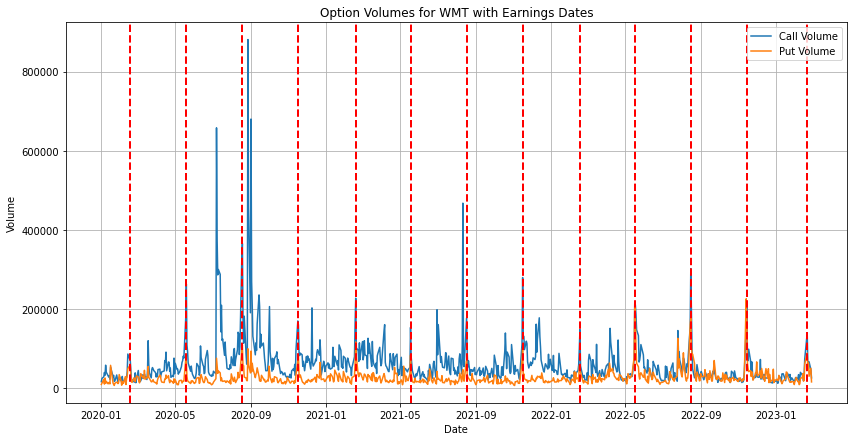

In [207]:
# Call the function with an example stock ticker
plot_option_volumes_with_earnings('WMT', opt_volumes_updated, earnings_dates)

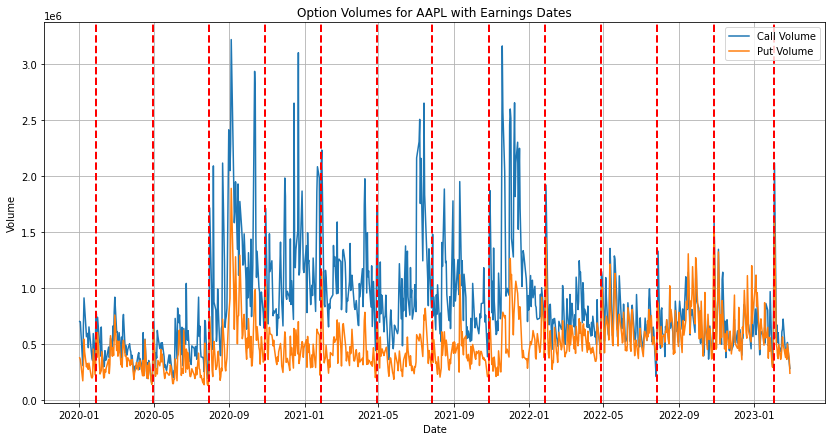

In [208]:
# Call the function with an example stock ticker
plot_option_volumes_with_earnings('AAPL', opt_volumes_updated, earnings_dates)

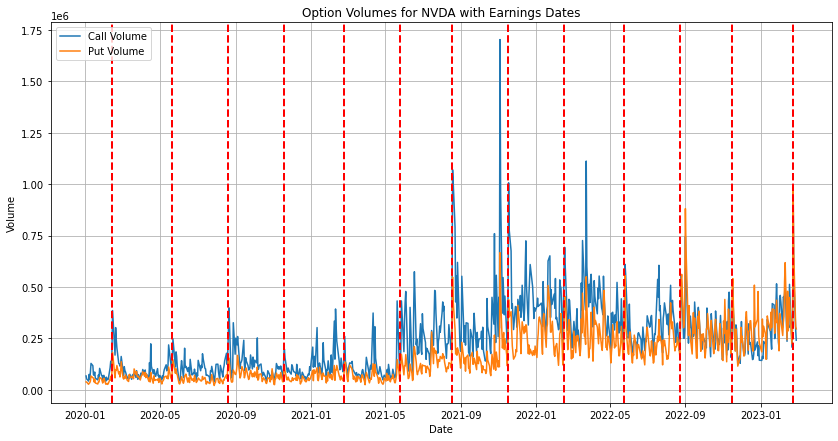

In [297]:
plot_option_volumes_with_earnings('NVDA', opt_volumes_updated, earnings_dates)

### Explore how to choose volatility over a long period when there's an earnings report upcoming

In [209]:
#https://www.jstor.org/stable/48616972?seq=3 (page 3)

#treat diffusive volatility as historical, then get the jump volatility, 
#This simple model delivers three general
#implications of earnings announcements: (1) IVs increase continuously and
#nonlinearly prior to an EAD (as T decreases), (2) IV discontinuously falls after
#the announcement, and (3) the term structure of IV is downward-sloping prior
#to the announcement.

The volatility of an option expiring at time $T$ is 
$$\sigma_{t} = \sqrt{ \sigma^2 + (\sigma_{j}^{Q})^2 / (j-t)}$$
where $\sigma$ is the historical diffusive volatility and  $\sigma_{j}^{Q}$ is the price jump volatility at time $j$. If $j < t < T$, then we ignore the second term 

Let's now approximate this jump volatility
$(j-t)(\sigma_{t}^2 - \sigma^2) = (\sigma_{j}^{Q})^2$

In [210]:
def findJumpVol(options_prices, ticker, date, spot_price, hist_vol):
    # Convert 'date' to datetime
    given_date = pd.to_datetime(date)

    while 1:
        # Filter options by ticker and date, and where expiration is soon after
        filtered_options = options_prices[
        (options_prices['ticker'] == ticker) &
        (options_prices['date'] == given_date) &
        (options_prices['exdate'] <= given_date + pd.Timedelta(days=5)) &
        (options_prices['exdate'] > given_date + pd.Timedelta(days=1))]

        if not filtered_options.empty:
            break  # Exit the loop since we have found the data
        else:
            given_date -= pd.Timedelta(days=1)  # Move the day back by 1


    #time to price_jump
    t_diff = ((date - given_date).days + 1) / 365


    # Calculate the absolute difference between the spot price and the strike price
    filtered_options = filtered_options.copy()
    filtered_options['strike_diff'] = abs(filtered_options['strike_price'] - spot_price)
    
    # Filter for call options
    filtered_options = filtered_options[filtered_options['cp_flag'] == 'C']
    # Sort by 'strike_diff'
    filtered_options = filtered_options.sort_values(by='strike_diff')

    impl_vol = filtered_options["impl_volatility"].iloc[0]

    if (impl_vol - hist_vol) < 0:
        jump_vol = 0
    else:
        jump_vol = np.sqrt(t_diff * (impl_vol ** 2 - hist_vol**2))
    
    return jump_vol

In [211]:
earnings_dates['price_jump_vol'] = 0

# Iterate over the earnings_dates DataFrame
for index, row in earnings_dates.iterrows():
    # Use the row's 'Ticker', 'EarningsDate', and 'Price_At_Earnings' for the function's parameters
    ticker = row['Ticker']
    date = row['EarningsDate'] - pd.Timedelta(days=1) if row['Earnings_timing'] == 'Pre' else row['EarningsDate']
    spot_price = row['Price_Before_Earnings']
    
    #Find historical vol
    our_stock = stocks[stocks["Symbol"] == ticker]
    hist_vol = stocks["Historical_Vol"].iloc[0]
    
    # Calculate the average straddle price
    jumpvol = findJumpVol(options_prices_updated, ticker, date, spot_price, hist_vol)
    
    # Assign the calculated average straddle price to the new column
    earnings_dates.at[index, 'price_jump_vol'] = jumpvol

# Display or return the updated earnings_dates DataFrame
earnings_dates

/var/folders/cj/jcn0rhn52g397xd7gy7ndwnc0000gn/T/ipykernel_91988/701750390.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  earnings_dates['price_jump_vol'] = 0
/var/folders/cj/jcn0rhn52g397xd7gy7ndwnc0000gn/T/ipykernel_91988/701750390.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.030452619886432435' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  earnings_dates.at[index, 'price_jump_vol'] = jumpvol


,Stock,EarningsDate,Quarter,Year,Ticker,Earnings_timing,realized_earnings_1d,realized_earnings_2d,realized_earnings_5d,realized_earnings_10d,Price_Before_Earnings,Average_Straddle_Price,Expected_Move,Expected_Move_V2_viaIV,price_jump_vol
0,AAPL,2020-01-28,4,2019,AAPL,After,0.020932,0.019453,0.003651,0.008465,317.69000,18.175,0.05721,0.042282,0.030453
1,AAPL,2020-04-30,1,2020,AAPL,After,-0.016099,-0.002178,0.033833,0.056359,293.79999,13.685,0.046579,0.042252,0.043027
2,AAPL,2020-07-30,2,2020,AAPL,After,0.104689,0.132525,0.184141,0.197861,384.76001,18.3975,0.047816,0.042237,0.043006
3,AAPL,2020-10-29,3,2020,AAPL,After,-0.056018,-0.056799,0.032172,0.035519,115.32000,6.2625,0.054305,0.059891,0.065872
4,AAPL,2021-01-27,4,2020,AAPL,After,-0.034985,-0.071097,-0.057159,-0.045522,142.06000,9.65,0.067929,0.075032,0.059833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,XOM,2022-02-01,4,2021,XOM,Pre,0.064113,0.061348,0.084650,0.051339,75.96000,3.7575,0.049467,0.029735,0.017422
387,XOM,2022-04-29,1,2022,XOM,Pre,-0.022362,-0.009059,0.035665,-0.000229,87.20000,3.965,0.04547,0.03617,0.034535
388,XOM,2022-07-29,2,2022,XOM,Pre,0.046308,0.019862,-0.058831,0.015434,92.64000,3.95,0.042638,0.032666,0.029319
389,XOM,2022-10-28,3,2022,XOM,Pre,0.029289,0.030312,0.033009,0.027430,107.55000,4.3,0.039981,0.035688,0.033836


In [212]:
#Now use this to select a volatility for option ATM
#30 day expiration
def findVol(date, ticker):
    #Find historical vol
    hist_vol = stocks["Historical_Vol"].iloc[0]

    #time until earnins report
    filter_earnings = earnings_dates[(earnings_dates["Stock"] == ticker) & (earnings_dates["EarningsDate"] >= date)]
    
    if filter_earnings.empty:
        return hist_vol 
    else:
        earn_date = filter_earnings["EarningsDate"].iloc[0]
        if (filter_earnings["Earnings_timing"].iloc[0] == "Pre"):
            earn_date = earn_date -  pd.Timedelta(days=1)

        t_diff = ((earn_date - date).days + 1) / 365
        if ((t_diff == 0) | (t_diff > 30/365)):
            return hist_vol
        
        price_jump_vol = filter_earnings["price_jump_vol"].iloc[0]
        return np.sqrt(hist_vol**2 + (price_jump_vol**2)/t_diff)

Bad Plot Trying to Estimate IV ATM via our strategy (below it is the truth)

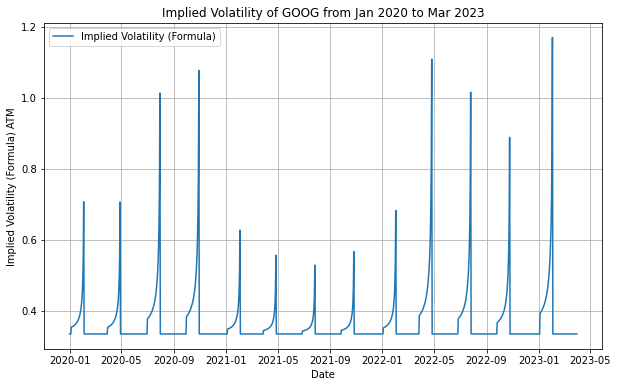

In [213]:
#Plot grph of this implied volatility model
# Generate a date range
date_range = pd.date_range(start="2020-01-01", end="2023-03-31", freq='D')

ticker = "GOOG"

# Collecting implied volatilities (our calculation)
volatilities = []
for date in date_range:
    # You'll need to ensure that `findJumpVol` can handle this `date` format and logic
    vol = findVol(date, ticker)
    volatilities.append(vol)

#print(volatilities)

# Plotting
date_array = date_range.to_pydatetime()
plt.figure(figsize=(10, 6))
plt.plot(date_array, volatilities, label='Implied Volatility (Formula)')
plt.xlabel('Date')
plt.ylabel('Implied Volatility (Formula) ATM')
plt.title('Implied Volatility of GOOG from Jan 2020 to Mar 2023')
plt.legend()
plt.grid(True)
plt.show()

In [214]:
def find30DayIV(ticker, date):
    # Convert 'date' to datetime
    given_date = pd.to_datetime(date)

    while 1:
        filtered_options = vol_surfaces[
        (vol_surfaces['ticker'] == ticker) &
        (vol_surfaces['date'] == given_date) &
        (vol_surfaces['expiration'] >= 0.03)]

        if not filtered_options.empty:
            break  # Exit the loop since we have found the data
        else:
            given_date -= pd.Timedelta(days=1)  # Move the day back by 1
  

    # Calculate the absolute difference between the spot price and the strike price
    mid_index = int(len(filtered_options) / 2)
    imp_vol = filtered_options.sort_values("impl_strike")["impl_volatility"].iloc[mid_index]
    
    # Return the first value in the 'impl_volatility' column
    return imp_vol

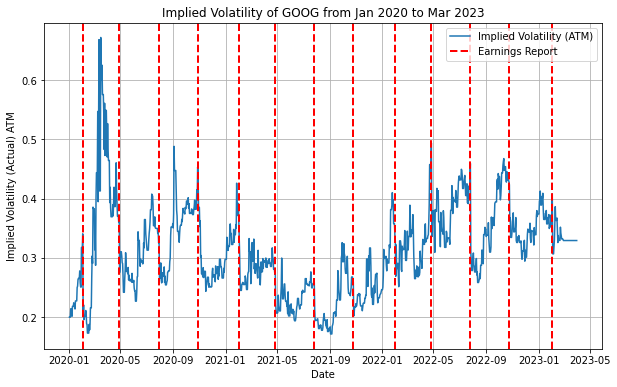

In [215]:
#Plot grph of this actual implied volatility model
# Generate a date range
date_range = pd.date_range(start="2020-01-03", end="2023-03-31", freq='D')

ticker = "GOOG"

# Collecting implied volatilities (our calculation)
volatilities = []
for date in date_range:
    # You'll need to ensure that `findJumpVol` can handle this `date` format and logic
    vol = find30DayIV(ticker, date)
    volatilities.append(vol)

# Plotting
date_array = date_range.to_pydatetime()
plt.figure(figsize=(10, 6))
plt.plot(date_array, volatilities, label='Implied Volatility (ATM)')

#Add-in lines for earning dates
earnings_dates_ticker = earnings_dates[earnings_dates["Stock"] == ticker]["EarningsDate"].values
for edate in earnings_dates_ticker:
    plt.axvline(x=edate, color='r', linestyle='--', lw=2, label='Earnings Report' if 'Earnings Report' not in plt.gca().get_legend_handles_labels()[1] else "")


plt.xlabel('Date')
plt.ylabel('Implied Volatility (Actual) ATM')
plt.title('Implied Volatility of GOOG from Jan 2020 to Mar 2023')
plt.legend()
plt.grid(True)
plt.show()

### Explore meaning of skew

Simplified version is just difference between ATM implied volatility vs. OTM puts (when always a certain percentage out of the money); effectively slope of left side of IV curve if negative skew; positive skew is the reverse, but not very useful

In [216]:
def negSkew(ticker, date):

    given_date = pd.to_datetime(date)

    while 1:
        filtered_options = vol_surfaces[
        (vol_surfaces['ticker'] == ticker) &
        (vol_surfaces['date'] == given_date) &
        (vol_surfaces['expiration'] >= 0.03)]

        if not filtered_options.empty:
            break  # Exit the loop since we have found the data
        else:
            given_date -= pd.Timedelta(days=1)  # Move the day back by 1
  
    filtered_options = filtered_options.copy()
    filtered_options['moneyness'] = filtered_options['impl_strike']/ spot_price

    OTM_val = filtered_options.sort_values("moneyness")["impl_volatility"].iloc[0]
    mid_index = int(len(filtered_options) / 2)
    ATM_val = filtered_options.sort_values("impl_strike")["impl_volatility"].iloc[mid_index]
  
    # Return the first value in the 'impl_volatility' column
    return OTM_val - ATM_val

In [217]:
def posSkew(ticker, date):

    given_date = pd.to_datetime(date)

    while 1:
        filtered_options = vol_surfaces[
        (vol_surfaces['ticker'] == ticker) &
        (vol_surfaces['date'] == given_date) &
        (vol_surfaces['expiration'] >= 0.03)]

        if not filtered_options.empty:
            break  # Exit the loop since we have found the data
        else:
            given_date -= pd.Timedelta(days=1)  # Move the day back by 1
  
    filtered_options = filtered_options.copy()
    filtered_options['moneyness'] = filtered_options['impl_strike']/ spot_price

    OTM_val = filtered_options.sort_values("moneyness")["impl_volatility"].iloc[-1]
    mid_index = int(len(filtered_options) / 2)
    ATM_val = filtered_options.sort_values("impl_strike")["impl_volatility"].iloc[mid_index]
  
    # Return the first value in the 'impl_volatility' column
    return OTM_val - ATM_val

In [218]:
earnings_dates['negSkew'] = 0

# Iterate over the earnings_dates DataFrame
for index, row in earnings_dates.iterrows():
    ticker = row['Ticker']
    date = row['EarningsDate'] - pd.Timedelta(days=1) if row['Earnings_timing'] == 'Pre' else row['EarningsDate']

    neg_skew_val = negSkew(ticker, date)
    
    # Assign the calculated average straddle price to the new column
    earnings_dates.at[index, 'negSkew'] = neg_skew_val

# Display or return the updated earnings_dates DataFrame
earnings_dates

/var/folders/cj/jcn0rhn52g397xd7gy7ndwnc0000gn/T/ipykernel_91988/3072682685.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  earnings_dates['negSkew'] = 0
/var/folders/cj/jcn0rhn52g397xd7gy7ndwnc0000gn/T/ipykernel_91988/3072682685.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.106601' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  earnings_dates.at[index, 'negSkew'] = neg_skew_val


,Stock,EarningsDate,Quarter,Year,Ticker,Earnings_timing,realized_earnings_1d,realized_earnings_2d,realized_earnings_5d,realized_earnings_10d,Price_Before_Earnings,Average_Straddle_Price,Expected_Move,Expected_Move_V2_viaIV,price_jump_vol,negSkew
0,AAPL,2020-01-28,4,2019,AAPL,After,0.020932,0.019453,0.003651,0.008465,317.69000,18.175,0.05721,0.042282,0.030453,0.106601
1,AAPL,2020-04-30,1,2020,AAPL,After,-0.016099,-0.002178,0.033833,0.056359,293.79999,13.685,0.046579,0.042252,0.043027,0.152940
2,AAPL,2020-07-30,2,2020,AAPL,After,0.104689,0.132525,0.184141,0.197861,384.76001,18.3975,0.047816,0.042237,0.043006,0.083935
3,AAPL,2020-10-29,3,2020,AAPL,After,-0.056018,-0.056799,0.032172,0.035519,115.32000,6.2625,0.054305,0.059891,0.065872,0.263048
4,AAPL,2021-01-27,4,2020,AAPL,After,-0.034985,-0.071097,-0.057159,-0.045522,142.06000,9.65,0.067929,0.075032,0.059833,0.087310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,XOM,2022-02-01,4,2021,XOM,Pre,0.064113,0.061348,0.084650,0.051339,75.96000,3.7575,0.049467,0.029735,0.017422,0.213426
387,XOM,2022-04-29,1,2022,XOM,Pre,-0.022362,-0.009059,0.035665,-0.000229,87.20000,3.965,0.04547,0.03617,0.034535,0.183170
388,XOM,2022-07-29,2,2022,XOM,Pre,0.046308,0.019862,-0.058831,0.015434,92.64000,3.95,0.042638,0.032666,0.029319,0.116161
389,XOM,2022-10-28,3,2022,XOM,Pre,0.029289,0.030312,0.033009,0.027430,107.55000,4.3,0.039981,0.035688,0.033836,0.081040


In [219]:
#Include industry info here for coloring purposes
earnings_dates = pd.merge(earnings_dates, stocks[["Symbol", "industry"]], left_on = "Stock", right_on = "Symbol", how = "left")
earnings_dates

,Stock,EarningsDate,Quarter,Year,Ticker,Earnings_timing,realized_earnings_1d,realized_earnings_2d,realized_earnings_5d,realized_earnings_10d,Price_Before_Earnings,Average_Straddle_Price,Expected_Move,Expected_Move_V2_viaIV,price_jump_vol,negSkew,Symbol,industry
0,AAPL,2020-01-28,4,2019,AAPL,After,0.020932,0.019453,0.003651,0.008465,317.69000,18.175,0.05721,0.042282,0.030453,0.106601,AAPL,Hardware Tech
1,AAPL,2020-04-30,1,2020,AAPL,After,-0.016099,-0.002178,0.033833,0.056359,293.79999,13.685,0.046579,0.042252,0.043027,0.152940,AAPL,Hardware Tech
2,AAPL,2020-07-30,2,2020,AAPL,After,0.104689,0.132525,0.184141,0.197861,384.76001,18.3975,0.047816,0.042237,0.043006,0.083935,AAPL,Hardware Tech
3,AAPL,2020-10-29,3,2020,AAPL,After,-0.056018,-0.056799,0.032172,0.035519,115.32000,6.2625,0.054305,0.059891,0.065872,0.263048,AAPL,Hardware Tech
4,AAPL,2021-01-27,4,2020,AAPL,After,-0.034985,-0.071097,-0.057159,-0.045522,142.06000,9.65,0.067929,0.075032,0.059833,0.087310,AAPL,Hardware Tech
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,XOM,2022-02-01,4,2021,XOM,Pre,0.064113,0.061348,0.084650,0.051339,75.96000,3.7575,0.049467,0.029735,0.017422,0.213426,XOM,Energy
355,XOM,2022-04-29,1,2022,XOM,Pre,-0.022362,-0.009059,0.035665,-0.000229,87.20000,3.965,0.04547,0.03617,0.034535,0.183170,XOM,Energy
356,XOM,2022-07-29,2,2022,XOM,Pre,0.046308,0.019862,-0.058831,0.015434,92.64000,3.95,0.042638,0.032666,0.029319,0.116161,XOM,Energy
357,XOM,2022-10-28,3,2022,XOM,Pre,0.029289,0.030312,0.033009,0.027430,107.55000,4.3,0.039981,0.035688,0.033836,0.081040,XOM,Energy


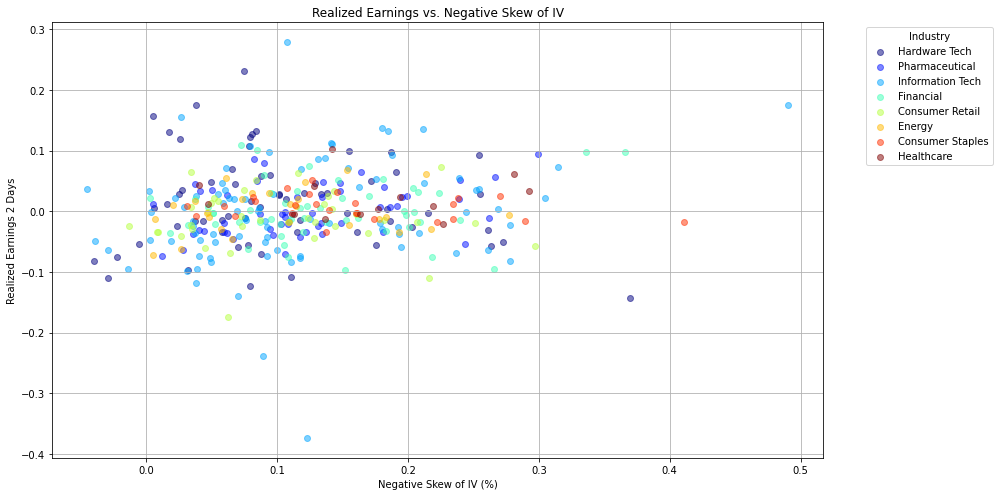

In [220]:
# Assuming 'industry' is a column in your DataFrame that contains the industry names
industries = earnings_dates['industry'].unique()

# Create a color map based on the unique industries
colors = plt.cm.jet(np.linspace(0, 1, len(industries)))

plt.figure(figsize=(14, 7))

for industry, color in zip(industries, colors):
    # Filter the DataFrame for each industry
    industry_data = earnings_dates[earnings_dates['industry'] == industry]
    
    # Scatter plot for each industry
    plt.scatter(industry_data['negSkew'], industry_data['realized_earnings_2d'], 
                alpha=0.5, color=color, label=industry)

# Add title and labels
plt.title('Realized Earnings vs. Negative Skew of IV')
plt.xlabel('Negative Skew of IV (%)')
plt.ylabel('Realized Earnings 2 Days')

# Create a legend for the industries
plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid
plt.grid(True)

# Show plot with tight layout to fit the external legend
plt.tight_layout()
plt.show()

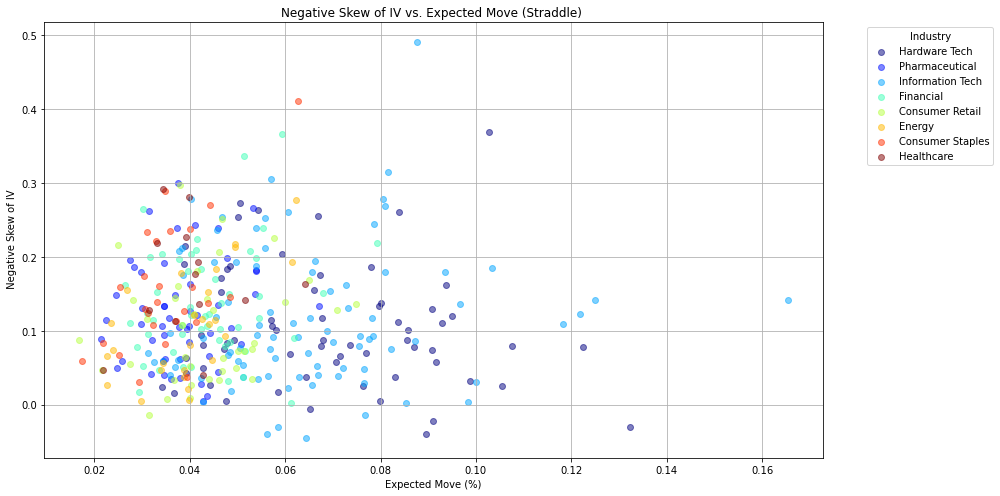

In [221]:
# Assuming 'industry' is a column in your DataFrame that contains the industry names
industries = earnings_dates['industry'].unique()

# Create a color map based on the unique industries
colors = plt.cm.jet(np.linspace(0, 1, len(industries)))

plt.figure(figsize=(14, 7))

for industry, color in zip(industries, colors):
    # Filter the DataFrame for each industry
    industry_data = earnings_dates[earnings_dates['industry'] == industry]
    
    # Scatter plot for each industry
    plt.scatter(industry_data['Expected_Move'], industry_data['negSkew'], 
                alpha=0.5, color=color, label=industry)

# Add title and labels
plt.title('Negative Skew of IV vs. Expected Move (Straddle) ')
plt.xlabel('Expected Move (%)')
plt.ylabel(' Negative Skew of IV')

# Create a legend for the industries
plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid
plt.grid(True)

# Show plot with tight layout to fit the external legend
plt.tight_layout()
plt.show()

In [222]:
#Plot skew comparisons before and after earnings reports
negative_skew_before = []
negative_skew_after = []
industries = []

# Iterate over the earnings_dates DataFrame
for index, row in earnings_dates.iterrows():
    industry = row['industry']
    industries.append(industry)
    
    date = row['EarningsDate'] - pd.Timedelta(days=1) if row['Earnings_timing'] == 'Pre' else row['EarningsDate']

    neg_skew_val_b = negSkew(ticker, date)
    negative_skew_before.append(neg_skew_val_b)
    neg_skew_val_a = negSkew(ticker, date+pd.Timedelta(days=10))
    negative_skew_after.append(neg_skew_val_a)  

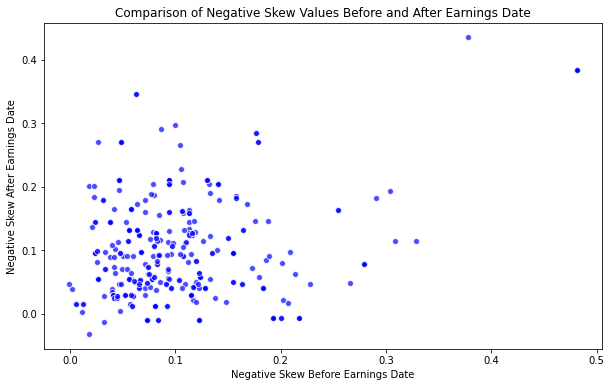

In [223]:
# Assuming negative_skew_before and negative_skew_after contain your data
# No need to create a DataFrame unless you find it easier for handling data

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Create a scatter plot
ax.scatter(negative_skew_before, negative_skew_after, alpha=0.7, edgecolors='w', color='blue')

# Add some text for labels, title, and axes ticks
ax.set_xlabel('Negative Skew Before Earnings Date')
ax.set_ylabel('Negative Skew After Earnings Date')
ax.set_title('Comparison of Negative Skew Values Before and After Earnings Date')

plt.show()


### Skew vs. Volume Earnings

In [308]:
opt_volumes_updated["Percent_Calls"] = opt_volumes_updated["volume_C"] / opt_volumes_updated["volume_total"]
opt_volumes_updated

,date,ticker,volume_C,volume_P,volume_total,Percent_Calls
0,2020-01-02,AAPL,701732.0,376911.0,1078643.0,0.650569
1,2020-01-02,ABBV,14621.0,4463.0,19084.0,0.766139
2,2020-01-02,ADBE,9408.0,8491.0,17899.0,0.525616
3,2020-01-02,AMD,567651.0,241478.0,809129.0,0.701558
4,2020-01-02,AMZN,239918.0,128934.0,368852.0,0.650445
...,...,...,...,...,...,...
22255,2023-02-28,TSLA,1008793.0,606229.0,1615022.0,0.624631
22256,2023-02-28,UNH,9766.0,9658.0,19424.0,0.502780
22257,2023-02-28,V,11381.0,7247.0,18628.0,0.610962
22258,2023-02-28,WMT,25467.0,15233.0,40700.0,0.625725


In [309]:
earnings_dates_volumes = pd.merge(earnings_dates, opt_volumes_updated[["date", "ticker","Percent_Calls" ]], left_on = ["Stock", "EarningsDate"], right_on = ["ticker", "date"] )
earnings_dates_volumes

,Stock,EarningsDate,Quarter,Year,Ticker,Earnings_timing,realized_earnings_1d,realized_earnings_2d,realized_earnings_5d,realized_earnings_10d,...,Average_Straddle_Price,Expected_Move,Expected_Move_V2_viaIV,price_jump_vol,negSkew,Symbol,industry,date,ticker,Percent_Calls
0,AAPL,2020-01-28,4,2019,AAPL,After,0.020932,0.019453,0.003651,0.008465,...,18.175,0.057210,0.042282,0.030453,0.106601,AAPL,Hardware Tech,2020-01-28,AAPL,0.652065
1,AAPL,2020-04-30,1,2020,AAPL,After,-0.016099,-0.002178,0.033833,0.056359,...,13.685,0.046579,0.042252,0.043027,0.152940,AAPL,Hardware Tech,2020-04-30,AAPL,0.552964
2,AAPL,2020-07-30,2,2020,AAPL,After,0.104689,0.132525,0.184141,0.197861,...,18.3975,0.047816,0.042237,0.043006,0.083935,AAPL,Hardware Tech,2020-07-30,AAPL,0.638968
3,AAPL,2020-10-29,3,2020,AAPL,After,-0.056018,-0.056799,0.032172,0.035519,...,6.2625,0.054305,0.059891,0.065872,0.263048,AAPL,Hardware Tech,2020-10-29,AAPL,0.635728
4,AAPL,2021-01-27,4,2020,AAPL,After,-0.034985,-0.071097,-0.057159,-0.045522,...,9.65,0.067929,0.075032,0.059833,0.087310,AAPL,Hardware Tech,2021-01-27,AAPL,0.760437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,XOM,2022-02-01,4,2021,XOM,Pre,0.064113,0.061348,0.084650,0.051339,...,3.7575,0.049467,0.029735,0.017422,0.213426,XOM,Energy,2022-02-01,XOM,0.688373
355,XOM,2022-04-29,1,2022,XOM,Pre,-0.022362,-0.009059,0.035665,-0.000229,...,3.965,0.045470,0.036170,0.034535,0.183170,XOM,Energy,2022-04-29,XOM,0.626907
356,XOM,2022-07-29,2,2022,XOM,Pre,0.046308,0.019862,-0.058831,0.015434,...,3.95,0.042638,0.032666,0.029319,0.116161,XOM,Energy,2022-07-29,XOM,0.767764
357,XOM,2022-10-28,3,2022,XOM,Pre,0.029289,0.030312,0.033009,0.027430,...,4.3,0.039981,0.035688,0.033836,0.081040,XOM,Energy,2022-10-28,XOM,0.676171


/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

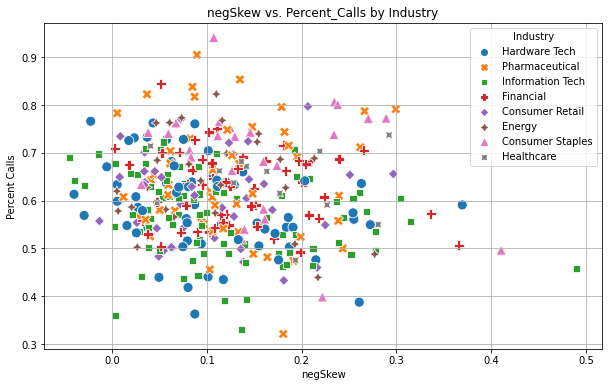

In [310]:
# Plotting.
plt.figure(figsize=(10, 6))
sns.scatterplot(data=earnings_dates_volumes, x="negSkew", y="Percent_Calls", hue="industry", style="industry", s=100)
plt.title("negSkew vs. Percent_Calls by Industry")
plt.xlabel("negSkew")
plt.ylabel("Percent Calls")
plt.grid(True)
plt.legend(title="Industry")
plt.show()

/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

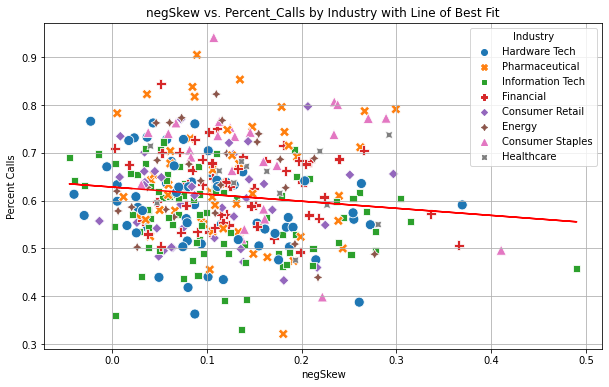

Coefficient:-0.14813299433978097
r_squared:


0.014729936279337275

In [313]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

# Assuming earnings_dates_volumes contains the relevant data as described.
# Since earnings_dates_volumes is not directly provided, using the sample data from before for demonstration.
# Linear regression model
X = earnings_dates_volumes[["negSkew"]].values # Predictor variable
y = earnings_dates_volumes["Percent_Calls"].values # Response variable

# Fitting the model
model = LinearRegression()
model.fit(X, y)

# Predictions
y_pred = model.predict(X)

# Calculating R^2
r_squared = r2_score(y, y_pred)

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=earnings_dates_volumes, x="negSkew", y="Percent_Calls", hue="industry", style="industry", s=100)
plt.plot(X, y_pred, color="red") # Line of best fit
plt.title("negSkew vs. Percent_Calls by Industry with Line of Best Fit")
plt.xlabel("negSkew")
plt.ylabel("Percent Calls")
plt.grid(True)
plt.legend(title="Industry")

plt.show()

coefficient_negSkew = model.coef_[0]

print("Coefficient:" + str(coefficient_negSkew))

print("r_squared:")
r_squared

/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

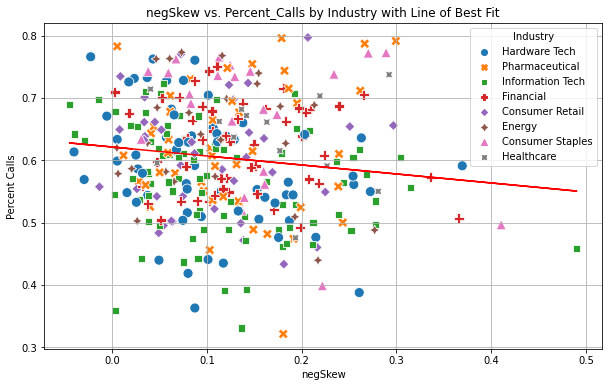

Coefficient:-0.14420906884673804
r_squared:


0.01638210550336261

In [314]:
#get rid of outliers
earnings_dates_volumes = earnings_dates_volumes[earnings_dates_volumes["Percent_Calls"]< 0.8]
# Assuming earnings_dates_volumes contains the relevant data as described.
# Since earnings_dates_volumes is not directly provided, using the sample data from before for demonstration.
# Linear regression model
X = earnings_dates_volumes[["negSkew"]].values # Predictor variable
y = earnings_dates_volumes["Percent_Calls"].values # Response variable

# Fitting the model
model = LinearRegression()
model.fit(X, y)

# Predictions
y_pred = model.predict(X)

# Calculating R^2
r_squared = r2_score(y, y_pred)

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=earnings_dates_volumes, x="negSkew", y="Percent_Calls", hue="industry", style="industry", s=100)
plt.plot(X, y_pred, color="red") # Line of best fit
plt.title("negSkew vs. Percent_Calls by Industry with Line of Best Fit")
plt.xlabel("negSkew")
plt.ylabel("Percent Calls")
plt.grid(True)
plt.legend(title="Industry")

plt.show()

coefficient_negSkew = model.coef_[0]

print("Coefficient:" + str(coefficient_negSkew))

print("r_squared:")
r_squared

Let's now look at how call volume percentages relate to returns (look only at the returns that are positive)

/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

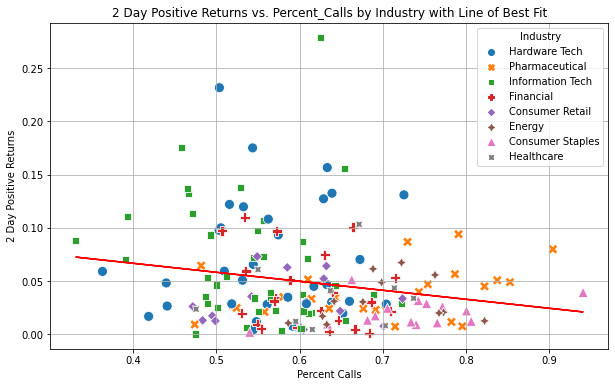

Coefficient:-0.08447160812153831
r_squared:


0.04093957159561734

In [315]:
earnings_dates_volumes = pd.merge(earnings_dates, opt_volumes_updated[["date", "ticker","Percent_Calls" ]], left_on = ["Stock", "EarningsDate"], right_on = ["ticker", "date"] )

pos_returns = earnings_dates_volumes[earnings_dates_volumes["realized_earnings_2d"]> 0]
# Assuming earnings_dates_volumes contains the relevant data as described.
# Since earnings_dates_volumes is not directly provided, using the sample data from before for demonstration.
# Linear regression model
X = pos_returns[["Percent_Calls"]].values # Predictor variable
y = pos_returns["realized_earnings_2d"].values # Response variable

# Fitting the model
model = LinearRegression()
model.fit(X, y)

# Predictions
y_pred = model.predict(X)

# Calculating R^2
r_squared = r2_score(y, y_pred)

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pos_returns, x="Percent_Calls", y="realized_earnings_2d", hue="industry", style="industry", s=100)
plt.plot(X, y_pred, color="red") # Line of best fit
plt.title("2 Day Positive Returns vs. Percent_Calls by Industry with Line of Best Fit")
plt.xlabel("Percent Calls")
plt.ylabel("2 Day Positive Returns")
plt.grid(True)
plt.legend(title="Industry")

plt.show()

coefficient_negSkew = model.coef_[0]

print("Coefficient:" + str(coefficient_negSkew))

print("r_squared:")
r_squared

### Look at general returns after earnings dates

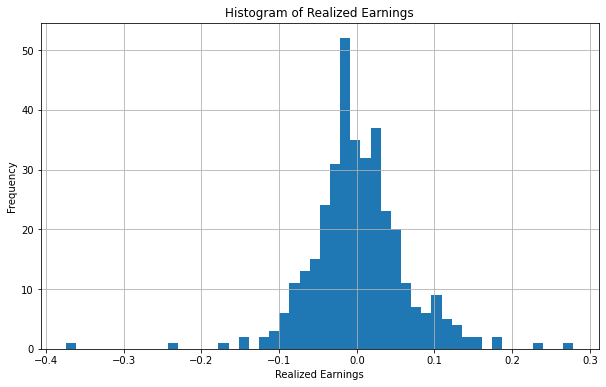

In [224]:
# Plotting using pandas
earnings_dates['realized_earnings_2d'].hist(bins=50, figsize=(10, 6))
plt.title('Histogram of Realized Earnings')
plt.xlabel('Realized Earnings')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [225]:
# Assuming 'revenues' and 'revenue_expectations' have the same structure
companies = ['AAPL', 'ABBV', 'ADBE', 'AMD', 'AMZN', 'AVGO', 'BAC', 'COST', 'MSFT', 'NFLX', 'NVDA', 'ORCL', 'PG', 'TSLA', 'UNH', 'V', 'WMT', 'XOM']  # List all companies you have

# Melt the revenues and revenue_expectations DataFrames
revenues_long = revenues.melt(id_vars=['Year', 'Quarter'], value_vars=companies, var_name='Company', value_name='ActualRevenue')
revenue_expectations_long = revenue_expectations.melt(id_vars=['Year', 'Quarter'], value_vars=companies, var_name='Company', value_name='ExpectedRevenue')

# Merge the long-form DataFrames
merged_revenues = pd.merge(revenues_long, revenue_expectations_long, on=['Year', 'Quarter', 'Company'])
merged_revenues

,Year,Quarter,Company,ActualRevenue,ExpectedRevenue
0,2019,4,AAPL,91819.0,88496.40081
1,2020,1,AAPL,58313.0,54544.40876
2,2020,2,AAPL,59685.0,52247.73841
3,2020,3,AAPL,64698.0,63699.84241
4,2020,4,AAPL,111439.0,103276.40763
...,...,...,...,...,...
247,2022,1,XOM,90500.0,89896.67787
248,2022,2,XOM,115681.0,126707.35400
249,2022,3,XOM,112070.0,115600.53743
250,2022,4,XOM,95429.0,94671.47614


In [226]:
final_df = pd.merge(earnings_dates, merged_revenues, left_on=['Year', 'Quarter', 'Ticker'], right_on=['Year', 'Quarter', 'Company'])
final_df['PercentDiff'] = ((final_df['ActualRevenue'] - final_df['ExpectedRevenue']) / final_df['ExpectedRevenue']) * 100
final_df

,Stock,EarningsDate,Quarter,Year,Ticker,Earnings_timing,realized_earnings_1d,realized_earnings_2d,realized_earnings_5d,realized_earnings_10d,...,Expected_Move,Expected_Move_V2_viaIV,price_jump_vol,negSkew,Symbol,industry,Company,ActualRevenue,ExpectedRevenue,PercentDiff
0,AAPL,2020-01-28,4,2019,AAPL,After,0.020932,0.019453,0.003651,0.008465,...,0.05721,0.042282,0.030453,0.106601,AAPL,Hardware Tech,AAPL,91819.0,88496.40081,3.754502
1,AAPL,2020-04-30,1,2020,AAPL,After,-0.016099,-0.002178,0.033833,0.056359,...,0.046579,0.042252,0.043027,0.152940,AAPL,Hardware Tech,AAPL,58313.0,54544.40876,6.909216
2,AAPL,2020-07-30,2,2020,AAPL,After,0.104689,0.132525,0.184141,0.197861,...,0.047816,0.042237,0.043006,0.083935,AAPL,Hardware Tech,AAPL,59685.0,52247.73841,14.234610
3,AAPL,2020-10-29,3,2020,AAPL,After,-0.056018,-0.056799,0.032172,0.035519,...,0.054305,0.059891,0.065872,0.263048,AAPL,Hardware Tech,AAPL,64698.0,63699.84241,1.566970
4,AAPL,2021-01-27,4,2020,AAPL,After,-0.034985,-0.071097,-0.057159,-0.045522,...,0.067929,0.075032,0.059833,0.087310,AAPL,Hardware Tech,AAPL,111439.0,103276.40763,7.903637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,XOM,2022-02-01,4,2021,XOM,Pre,0.064113,0.061348,0.084650,0.051339,...,0.049467,0.029735,0.017422,0.213426,XOM,Energy,XOM,84965.0,91845.32611,-7.491210
226,XOM,2022-04-29,1,2022,XOM,Pre,-0.022362,-0.009059,0.035665,-0.000229,...,0.04547,0.03617,0.034535,0.183170,XOM,Energy,XOM,90500.0,89896.67787,0.671128
227,XOM,2022-07-29,2,2022,XOM,Pre,0.046308,0.019862,-0.058831,0.015434,...,0.042638,0.032666,0.029319,0.116161,XOM,Energy,XOM,115681.0,126707.35400,-8.702221
228,XOM,2022-10-28,3,2022,XOM,Pre,0.029289,0.030312,0.033009,0.027430,...,0.039981,0.035688,0.033836,0.081040,XOM,Energy,XOM,112070.0,115600.53743,-3.054084


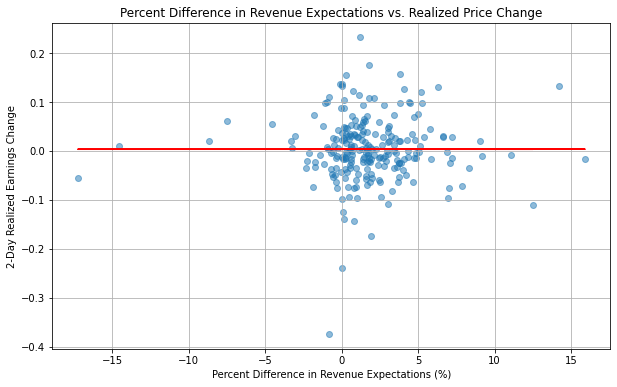

0.0005787046612157961 0.0033659681545864695


In [227]:
plt.figure(figsize=(10, 6))
plt.scatter(final_df['PercentDiff'], final_df['realized_earnings_2d'], alpha=0.5)
# Calculating the regression line
m, b = np.polyfit(final_df['PercentDiff'], final_df['realized_earnings_2d'], 1)

# Adding the regression line to the plot
plt.plot(final_df['PercentDiff'].values, m*final_df['realized_earnings_2d'].values + b, color='red') # regression line
plt.title('Percent Difference in Revenue Expectations vs. Realized Price Change')
plt.xlabel('Percent Difference in Revenue Expectations (%)')
plt.ylabel('2-Day Realized Earnings Change')
plt.grid(True)
plt.show()

print(m, b)

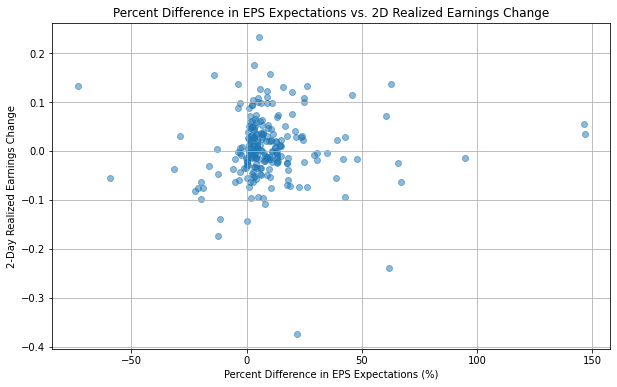

In [228]:
# Assuming 'eps' and 'eps_expectation' have the same structure as the revenue data
companies = ['AAPL', 'ABBV', 'ADBE', 'AMD', 'AMZN', 'AVGO', 'BAC', 'COST', 'MSFT', 'NFLX', 'NVDA', 'ORCL', 'PG', 'TSLA', 'UNH', 'V', 'WMT', 'XOM']  # List all companies

# Melt the eps and eps_expectation DataFrames
eps_long = eps.melt(id_vars=['Year', 'Quarter'], value_vars=companies, var_name='Company', value_name='ActualEPS')
eps_expectations_long = eps_expectation.melt(id_vars=['Year', 'Quarter'], value_vars=companies, var_name='Company', value_name='ExpectedEPS')

# Merge the long-form DataFrames
merged_eps = pd.merge(eps_long, eps_expectations_long, on=['Year', 'Quarter', 'Company'])


# Merge with earnings_dates DataFrame
final_eps_df = pd.merge(earnings_dates, merged_eps, left_on=['Year', 'Quarter', 'Ticker'], right_on=['Year', 'Quarter', 'Company'])

# Calculate the percent difference between actual and expected EPS
final_eps_df['PercentDiffEPS'] = ((final_eps_df['ActualEPS'] - final_eps_df['ExpectedEPS']) / final_eps_df['ExpectedEPS']) * 100

#Remove outliers (are a bunch):
threshold = 400

# Filter the DataFrame to exclude rows beyond this threshold
final_eps_df = final_eps_df[np.abs(final_eps_df['PercentDiffEPS']) < threshold]


plt.figure(figsize=(10, 6))
plt.scatter(final_eps_df['PercentDiffEPS'], final_eps_df['realized_earnings_2d'], alpha=0.5)
plt.title('Percent Difference in EPS Expectations vs. 2D Realized Earnings Change')
plt.xlabel('Percent Difference in EPS Expectations (%)')
plt.ylabel('2-Day Realized Earnings Change')
plt.grid(True)
plt.show()

In [229]:
# Assuming 'revenues' and 'revenue_expectations' have the same structure
companies = ['AAPL', 'ABBV', 'ADBE', 'AMD', 'AMZN', 'AVGO', 'BAC', 'COST', 'MSFT', 'NFLX', 'NVDA', 'ORCL', 'PG', 'TSLA', 'UNH', 'V', 'WMT', 'XOM']  # List all companies you have

# Melt the revenues and revenue_expectations DataFrames
revenues_long = revenue_expectations.melt(id_vars=['Year', 'Quarter'], value_vars=companies, var_name='Company', value_name='ActualRevenueExp')
revenue_sd_long = revenue_expectations_sd.melt(id_vars=['Year', 'Quarter'], value_vars=companies, var_name='Company', value_name='sd')

# Merge the long-form DataFrames
merged_revenues = pd.merge(revenues_long, revenue_sd_long, on=['Year', 'Quarter', 'Company'])
merged_revenues
final_df = pd.merge(earnings_dates, merged_revenues, left_on=['Year', 'Quarter', 'Ticker'], right_on=['Year', 'Quarter', 'Company'])
final_df['SdPerc'] = (final_df['sd'] / final_df['ActualRevenueExp']) * 100

#Remove outliers (are a bunch):
threshold = 15

# Filter the DataFrame to exclude rows beyond this threshold
final_df = final_df[final_df['SdPerc'] < threshold]

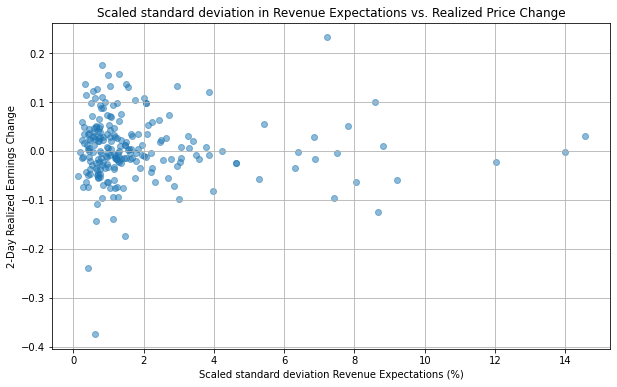

In [230]:
plt.figure(figsize=(10, 6))
plt.scatter(final_df['SdPerc'], final_df['realized_earnings_2d'], alpha=0.5)
plt.title('Scaled standard deviation in Revenue Expectations vs. Realized Price Change')
plt.xlabel('Scaled standard deviation Revenue Expectations (%)')
plt.ylabel('2-Day Realized Earnings Change')
plt.grid(True)
plt.show()

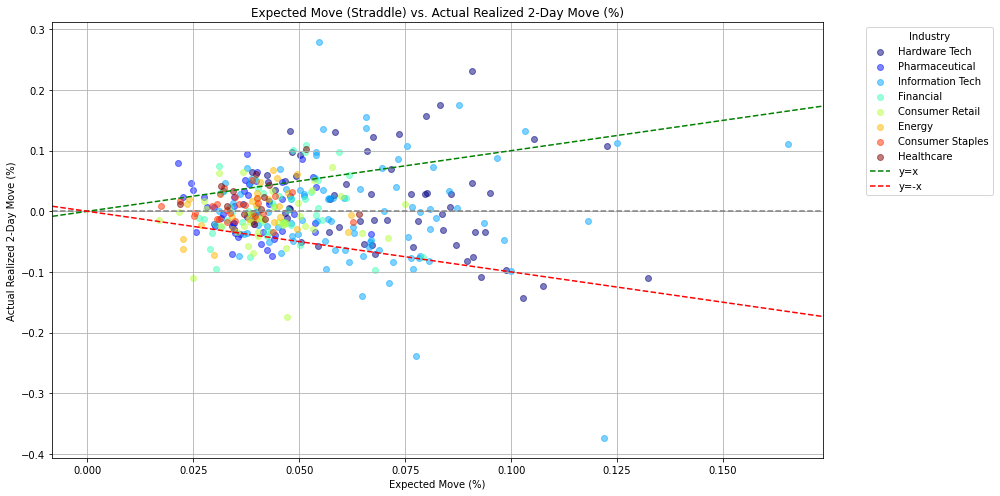

In [231]:
# Assuming 'industry' is a column in your DataFrame that contains the industry names
industries = earnings_dates['industry'].unique()

# Create a color map based on the unique industries
colors = plt.cm.jet(np.linspace(0, 1, len(industries)))

plt.figure(figsize=(14, 7))

for industry, color in zip(industries, colors):
    # Filter the DataFrame for each industry
    industry_data = earnings_dates[earnings_dates['industry'] == industry]
    
    # Scatter plot for each industry
    plt.scatter(industry_data['Expected_Move'], industry_data['realized_earnings_2d'], 
                alpha=0.5, color=color, label=industry)

# Reference lines
plt.axhline(y=0, color='grey', linestyle='--')  # Zero line for reference
plt.axline((0, 0), slope=1, color='green', linestyle='--', label='y=x')
plt.axline((0, 0), slope=-1, color='red', linestyle='--', label='y=-x')

# Add title and labels
plt.title('Expected Move (Straddle) vs. Actual Realized 2-Day Move (%)')
plt.xlabel('Expected Move (%)')
plt.ylabel('Actual Realized 2-Day Move (%)')

# Create a legend for the industries
plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid
plt.grid(True)

# Show plot with tight layout to fit the external legend
plt.tight_layout()
plt.show()


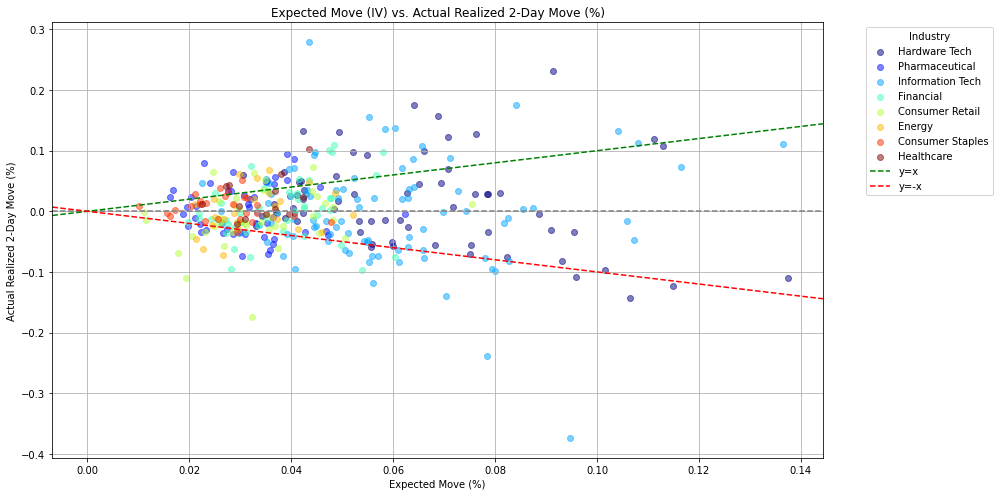

In [232]:
# Assuming 'industry' is a column in your DataFrame that contains the industry names
industries = earnings_dates['industry'].unique()

# Create a color map based on the unique industries
colors = plt.cm.jet(np.linspace(0, 1, len(industries)))

plt.figure(figsize=(14, 7))

for industry, color in zip(industries, colors):
    # Filter the DataFrame for each industry
    industry_data = earnings_dates[earnings_dates['industry'] == industry]
    
    # Scatter plot for each industry
    plt.scatter(industry_data['Expected_Move_V2_viaIV'], industry_data['realized_earnings_2d'], 
                alpha=0.5, color=color, label=industry)

# Reference lines
plt.axhline(y=0, color='grey', linestyle='--')  # Zero line for reference
plt.axline((0, 0), slope=1, color='green', linestyle='--', label='y=x')
plt.axline((0, 0), slope=-1, color='red', linestyle='--', label='y=-x')

# Add title and labels
plt.title('Expected Move (IV) vs. Actual Realized 2-Day Move (%)')
plt.xlabel('Expected Move (%)')
plt.ylabel('Actual Realized 2-Day Move (%)')

# Create a legend for the industries
plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid
plt.grid(True)

# Show plot with tight layout to fit the external legend
plt.tight_layout()
plt.show()

In [233]:
#What percentage of data points are within the expected move:
# Calculating the difference
greaterThanExpectationNum = industry_data["Expected_Move_V2_viaIV"] - np.abs(industry_data['realized_earnings_2d'])

# Finding the percent of calculations that are positive
percent_positive = np.mean(greaterThanExpectationNum > 0) * 100

print("Percent of moves within the expected move via IV method")
print(percent_positive)

Percent of moves within the expected move via IV method
69.23076923076923


#### Regression using these factors (look at p-values)

In [234]:
earnings_dates['Expected_Move'] = pd.to_numeric(earnings_dates['Expected_Move'], errors='coerce')
earnings_dates['Expected_Move_V2_viaIV'] = pd.to_numeric(earnings_dates['Expected_Move_V2_viaIV'], errors='coerce')

In [235]:
# Assuming 'revenues' and 'revenue_expectations' have the same structure
companies = ['AAPL', 'ABBV', 'ADBE', 'AMD', 'AMZN', 'AVGO', 'BAC', 'COST', 'MSFT', 'NFLX', 'NVDA', 'ORCL', 'PG', 'TSLA', 'UNH', 'V', 'WMT', 'XOM']  # List all companies you have

# Melt the revenues and revenue_expectations DataFrames
revenues_long = revenues.melt(id_vars=['Year', 'Quarter'], value_vars=companies, var_name='Company', value_name='ActualRevenue')
revenue_expectations_long = revenue_expectations.melt(id_vars=['Year', 'Quarter'], value_vars=companies, var_name='Company', value_name='ExpectedRevenue')
revenue_stds_long = revenue_expectations_sd.melt(id_vars=['Year', 'Quarter'], value_vars=companies, var_name='Company', value_name='VarExpectedRevenue')

# Merge the long-form DataFrames
merged_revenues = pd.merge(revenues_long, revenue_expectations_long, on=['Year', 'Quarter', 'Company'])
merged_revenues = pd.merge(revenue_stds_long, merged_revenues, on=['Year', 'Quarter', 'Company'])
merged_revenues

final_df = pd.merge(earnings_dates, merged_revenues, left_on=['Year', 'Quarter', 'Ticker'], right_on=['Year', 'Quarter', 'Company'])
final_df['PercentDiff'] = ((final_df['ActualRevenue'] - final_df['ExpectedRevenue']) / final_df['ExpectedRevenue']) * 100
final_df = pd.merge(final_df, opt_volumes_updated, left_on = ["EarningsDate","Stock"] ,right_on = ["date", "ticker"], how = "left")
final_df[["realized_earnings_2d", "Expected_Move", "Expected_Move_V2_viaIV", "negSkew", "PercentDiff", "volume_total", "industry"]]

,realized_earnings_2d,Expected_Move,Expected_Move_V2_viaIV,negSkew,PercentDiff,volume_total,industry
0,0.019453,0.057210,0.042282,0.106601,3.754502,997996.0,Hardware Tech
1,-0.002178,0.046579,0.042252,0.152940,6.909216,826427.0,Hardware Tech
2,0.132525,0.047816,0.042237,0.083935,14.234610,671918.0,Hardware Tech
3,-0.056799,0.054305,0.059891,0.263048,1.566970,1824299.0,Hardware Tech
4,-0.071097,0.067929,0.075032,0.087310,7.903637,1854907.0,Hardware Tech
...,...,...,...,...,...,...,...
225,0.061348,0.049467,0.029735,0.213426,-7.491210,447990.0,Energy
226,-0.009059,0.045470,0.036170,0.183170,0.671128,160507.0,Energy
227,0.019862,0.042638,0.032666,0.116161,-8.702221,279117.0,Energy
228,0.030312,0.039981,0.035688,0.081040,-3.054084,280460.0,Energy


['Expected_Move', 'Expected_Move_V2_viaIV', 'negSkew', 'PercentDiff', 'volume_total']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.6975
Date:                Tue, 05 Mar 2024   Prob (F-statistic):              0.626
Time:                        20:03:16   Log-Likelihood:                 297.43
No. Observations:                 230   AIC:                            -582.9
Df Residuals:                     224   BIC:                            -562.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

Text(0, 0.5, 'Residual')

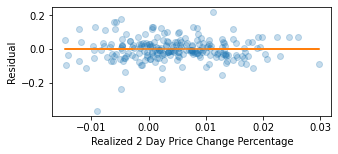

In [236]:
#Run linear regression (as large group)
x = final_df[["Expected_Move", "Expected_Move_V2_viaIV", "negSkew", "PercentDiff", "volume_total"]].to_numpy() \
#Note PercentDiff is in terms of revenue expecations
print(["Expected_Move", "Expected_Move_V2_viaIV", "negSkew", "PercentDiff", "volume_total"])
y = final_df["realized_earnings_2d"].to_numpy()
X = sm.add_constant(x) # add a column of all 1s
model = sm.OLS(y,X) #run OLS
results = model.fit()
print(results.summary())

#Graph residuals
sigma_eps_hat = np.sqrt(results.mse_resid)
print("MSE:" + str(sigma_eps_hat))
r = results.resid
y_mean_pred = y - r
fig,ax = plt.subplots(figsize=(5,2))
ax.plot(y_mean_pred,r,"o", alpha = 0.25)  # Plot the residuals
ax.plot(y_mean_pred,np.zeros(len(y)),"-") # Plot the reference line of 0
ax.set_xlabel("Realized 2 Day Price Change Percentage")
ax.set_ylabel("Residual")

['PercentDiff']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.1929
Date:                Tue, 05 Mar 2024   Prob (F-statistic):              0.661
Time:                        20:03:16   Log-Likelihood:                 295.75
No. Observations:                 230   AIC:                            -587.5
Df Residuals:                     228   BIC:                            -580.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.005    

Text(0, 0.5, 'Residual')

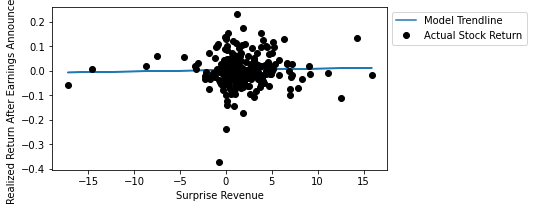

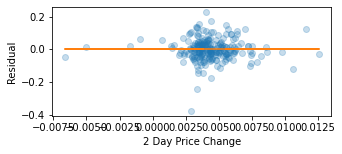

In [237]:
#Run linear regression
x = final_df[["PercentDiff"]].to_numpy()
print(["PercentDiff"])
y = final_df["realized_earnings_2d"].to_numpy()
X = sm.add_constant(x) # add a column of all 1s
model = sm.OLS(y,X) #run OLS

results = model.fit()
print(results.summary())
bhat, ahat = results.params #Grab values
sigma_eps_hat = np.sqrt(results.mse_resid)
print("Coefficients:")
print(bhat, ahat)
# Graph it
fig,ax = plt.subplots(figsize=(6,3))
ax.plot(x,ahat*x + bhat, '-', label="Model Trendline") # graph line of best fit
ax.plot(x,y,"ko",  label="Actual Stock Return")
ax.set_xlabel("Surprise Revenue")
ax.set_ylabel("Realized Return After Earnings Announcement")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))


#Graph residuals
sigma_eps_hat = np.sqrt(results.mse_resid)
print("MSE: " +str(sigma_eps_hat))
r = results.resid
y_mean_pred = y - r
fig,ax = plt.subplots(figsize=(5,2))
ax.plot(y_mean_pred,r,"o", alpha = 0.25)  # Plot the residuals
ax.plot(y_mean_pred,np.zeros(len(y)),"-") # Plot the reference line of 0
ax.set_xlabel("2 Day Price Change")
ax.set_ylabel("Residual")

In [258]:
#Now just look at absolute movements

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     61.86
Date:                Tue, 05 Mar 2024   Prob (F-statistic):           1.47e-13
Time:                        20:21:44   Log-Likelihood:                 403.30
No. Observations:                 230   AIC:                            -802.6
Df Residuals:                     228   BIC:                            -795.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0049      0.007     -0.674      0.5

Text(0, 0.5, 'Residual')

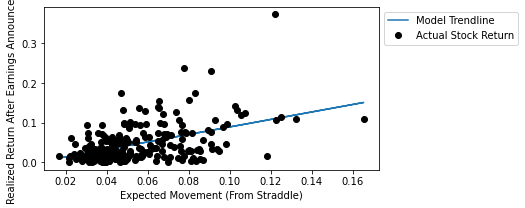

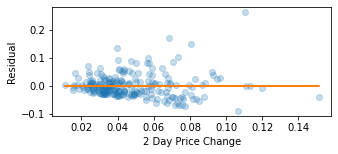

In [259]:
#Run linear regression
x = final_df[["Expected_Move"]].to_numpy()
y = np.abs(final_df["realized_earnings_2d"].to_numpy()) ##just in total percnetage
X = sm.add_constant(x) # add a column of all 1s
model = sm.OLS(y,X) #run OLS

results = model.fit()
print(results.summary())
bhat, ahat = results.params #Grab values
sigma_eps_hat = np.sqrt(results.mse_resid)
print("Coefficients:")
print(bhat, ahat)
# Graph it
fig,ax = plt.subplots(figsize=(6,3))
ax.plot(x,ahat*x + bhat, '-', label="Model Trendline") # graph line of best fit
ax.plot(x,y,"ko",  label="Actual Stock Return")
ax.set_xlabel("Expected Movement (From Straddle)")
ax.set_ylabel("Realized Return After Earnings Announcement")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))


#Graph residuals
sigma_eps_hat = np.sqrt(results.mse_resid)
print("MSE: " +str(sigma_eps_hat))
r = results.resid
y_mean_pred = y - r
fig,ax = plt.subplots(figsize=(5,2))
ax.plot(y_mean_pred,r,"o", alpha = 0.25)  # Plot the residuals
ax.plot(y_mean_pred,np.zeros(len(y)),"-") # Plot the reference line of 0
ax.set_xlabel("2 Day Price Change")
ax.set_ylabel("Residual")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     58.43
Date:                Tue, 05 Mar 2024   Prob (F-statistic):           5.81e-13
Time:                        20:21:45   Log-Likelihood:                 401.93
No. Observations:                 230   AIC:                            -799.9
Df Residuals:                     228   BIC:                            -793.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.007      0.223      0.8

Text(0, 0.5, 'Residual')

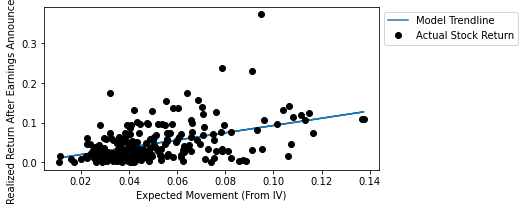

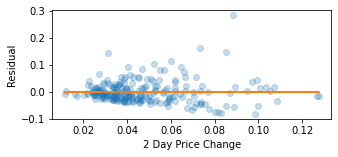

In [260]:
#Run linear regression
x = final_df[["Expected_Move_V2_viaIV"]].to_numpy()
y = np.abs(final_df["realized_earnings_2d"].to_numpy()) ##just in total percnetage
X = sm.add_constant(x) # add a column of all 1s
model = sm.OLS(y,X) #run OLS

results = model.fit()
print(results.summary())
bhat, ahat = results.params #Grab values
sigma_eps_hat = np.sqrt(results.mse_resid)
print("Coefficients:")
print(bhat, ahat)
# Graph it
fig,ax = plt.subplots(figsize=(6,3))
ax.plot(x,ahat*x + bhat, '-', label="Model Trendline") # graph line of best fit
ax.plot(x,y,"ko",  label="Actual Stock Return")
ax.set_xlabel("Expected Movement (From IV)")
ax.set_ylabel("Realized Return After Earnings Announcement")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))


#Graph residuals
sigma_eps_hat = np.sqrt(results.mse_resid)
print("MSE: " +str(sigma_eps_hat))
r = results.resid
y_mean_pred = y - r
fig,ax = plt.subplots(figsize=(5,2))
ax.plot(y_mean_pred,r,"o", alpha = 0.25)  # Plot the residuals
ax.plot(y_mean_pred,np.zeros(len(y)),"-") # Plot the reference line of 0
ax.set_xlabel("2 Day Price Change")
ax.set_ylabel("Residual")

#### Try removing the far up outlier
Result is lowers MSE, but also lowers R^2

In [261]:
final_df.sort_values("realized_earnings_2d")

,Stock,EarningsDate,Quarter,Year,Ticker,Earnings_timing,realized_earnings_1d,realized_earnings_2d,realized_earnings_5d,realized_earnings_10d,...,Company,VarExpectedRevenue,ActualRevenue,ExpectedRevenue,PercentDiff,date,ticker,volume_C,volume_P,volume_total
123,NFLX,2022-04-19,1,2022,NFLX,After,-0.351166,-0.374028,-0.430883,-0.426667,...,NFLX,49.47669,7867.767,7930.92062,-0.796296,2022-04-19,NFLX,159375.0,166752.0,326127.0
122,NFLX,2022-01-20,4,2021,NFLX,After,-0.217905,-0.238269,-0.239154,-0.201968,...,NFLX,31.86854,7709.318,7708.49306,0.010702,2022-01-20,NFLX,119645.0,113775.0,233420.0
213,WMT,2022-05-17,1,2022,WMT,Pre,-0.113758,-0.173943,-0.172795,-0.133121,...,WMT,2040.26811,141569.000,138938.51372,1.893274,2022-05-17,WMT,214208.0,212042.0,426250.0
64,AVGO,2020-03-12,1,2020,AVGO,After,0.070573,-0.142609,-0.111209,0.130274,...,AVGO,36.16533,5742.000,5694.19676,0.839508,2020-03-12,AVGO,12439.0,8609.0,21048.0
60,AMZN,2022-04-28,1,2022,AMZN,After,-0.140494,-0.138983,-0.194952,-0.260489,...,AMZN,1303.85883,116444.000,116296.70551,0.126654,2022-04-28,AMZN,132930.0,99986.0,232916.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,AMZN,2022-02-03,4,2021,AMZN,After,0.135359,0.137491,0.145183,0.113846,...,AMZN,2077.49036,137412.000,137553.33203,-0.102747,2022-02-03,AMZN,268060.0,239012.0,507072.0
118,NFLX,2021-01-19,4,2020,NFLX,After,0.168543,0.155589,0.119896,0.092453,...,NFLX,65.43762,6644.442,6626.34954,0.273038,2021-01-19,NFLX,236891.0,125480.0,362371.0
40,AMD,2020-07-28,2,2020,AMD,After,0.125425,0.156633,0.257802,0.137110,...,AMD,24.44588,1932.000,1860.89859,3.820811,2020-07-28,AMD,388310.0,224844.0,613154.0
50,AMD,2023-01-31,4,2022,AMD,After,0.126281,0.175117,0.143180,0.143711,...,AMD,44.16259,5599.000,5499.66081,1.806278,2023-01-31,AMD,328543.0,275976.0,604519.0


In [262]:
#remove outlier
final_df_removeOutlier = final_df[np.abs(final_df["realized_earnings_2d"]) < 0.2 ]
final_df_removeOutlier

,Stock,EarningsDate,Quarter,Year,Ticker,Earnings_timing,realized_earnings_1d,realized_earnings_2d,realized_earnings_5d,realized_earnings_10d,...,Company,VarExpectedRevenue,ActualRevenue,ExpectedRevenue,PercentDiff,date,ticker,volume_C,volume_P,volume_total
0,AAPL,2020-01-28,4,2019,AAPL,After,0.020932,0.019453,0.003651,0.008465,...,AAPL,945.17438,91819.0,88496.40081,3.754502,2020-01-28,AAPL,650758.0,347238.0,997996.0
1,AAPL,2020-04-30,1,2020,AAPL,After,-0.016099,-0.002178,0.033833,0.056359,...,AAPL,3493.72741,58313.0,54544.40876,6.909216,2020-04-30,AAPL,456984.0,369443.0,826427.0
2,AAPL,2020-07-30,2,2020,AAPL,After,0.104689,0.132525,0.184141,0.197861,...,AAPL,1546.77935,59685.0,52247.73841,14.234610,2020-07-30,AAPL,429334.0,242584.0,671918.0
3,AAPL,2020-10-29,3,2020,AAPL,After,-0.056018,-0.056799,0.032172,0.035519,...,AAPL,3365.19500,64698.0,63699.84241,1.566970,2020-10-29,AAPL,1159758.0,664541.0,1824299.0
4,AAPL,2021-01-27,4,2020,AAPL,After,-0.034985,-0.071097,-0.057159,-0.045522,...,AAPL,2959.82838,111439.0,103276.40763,7.903637,2021-01-27,AAPL,1410539.0,444368.0,1854907.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,XOM,2022-02-01,4,2021,XOM,Pre,0.064113,0.061348,0.084650,0.051339,...,XOM,20977.97688,84965.0,91845.32611,-7.491210,2022-02-01,XOM,308384.0,139606.0,447990.0
226,XOM,2022-04-29,1,2022,XOM,Pre,-0.022362,-0.009059,0.035665,-0.000229,...,XOM,23210.24679,90500.0,89896.67787,0.671128,2022-04-29,XOM,100623.0,59884.0,160507.0
227,XOM,2022-07-29,2,2022,XOM,Pre,0.046308,0.019862,-0.058831,0.015434,...,XOM,45717.51518,115681.0,126707.35400,-8.702221,2022-07-29,XOM,214296.0,64821.0,279117.0
228,XOM,2022-10-28,3,2022,XOM,Pre,0.029289,0.030312,0.033009,0.027430,...,XOM,22545.16059,112070.0,115600.53743,-3.054084,2022-10-28,XOM,189639.0,90821.0,280460.0


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     51.43
Date:                Tue, 05 Mar 2024   Prob (F-statistic):           1.06e-11
Time:                        23:04:48   Log-Likelihood:                 441.33
No. Observations:                 227   AIC:                            -878.7
Df Residuals:                     225   BIC:                            -871.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0087      0.006      1.574      0.1

Text(0, 0.5, 'Residual')

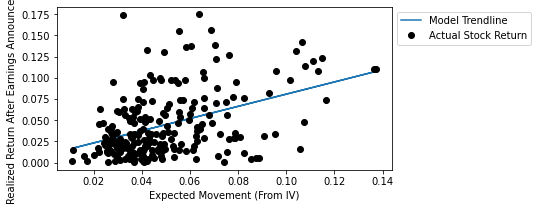

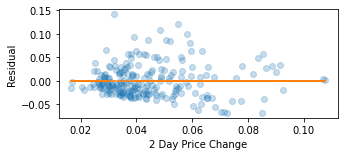

In [272]:
#Run linear regression
x = final_df_removeOutlier[["Expected_Move_V2_viaIV"]].to_numpy()
y = np.abs(final_df_removeOutlier["realized_earnings_2d"].to_numpy()) ##just in total percnetage
X = sm.add_constant(x) # add a column of all 1s
model = sm.OLS(y,X) #run OLS

results = model.fit()
print(results.summary())
bhat, ahat = results.params #Grab values
sigma_eps_hat = np.sqrt(results.mse_resid)
print("Coefficients:")
print(bhat, ahat)
# Graph it
fig,ax = plt.subplots(figsize=(6,3))
ax.plot(x,ahat*x + bhat, '-', label="Model Trendline") # graph line of best fit
ax.plot(x,y,"ko",  label="Actual Stock Return")
ax.set_xlabel("Expected Movement (From IV)")
ax.set_ylabel("Realized Return After Earnings Announcement")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))


#Graph residuals
sigma_eps_hat = np.sqrt(results.mse_resid)
print("MSE: " +str(sigma_eps_hat))
r = results.resid
y_mean_pred = y - r
fig,ax = plt.subplots(figsize=(5,2))
ax.plot(y_mean_pred,r,"o", alpha = 0.25)  # Plot the residuals
ax.plot(y_mean_pred,np.zeros(len(y)),"-") # Plot the reference line of 0
ax.set_xlabel("2 Day Price Change")
ax.set_ylabel("Residual")

Try some non-linear models

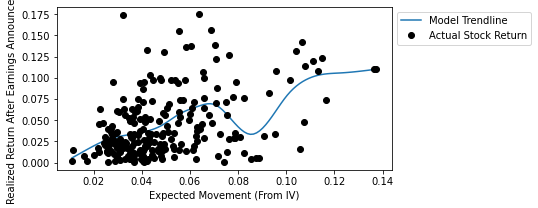

In [273]:
from pygam import LinearGAM, s

# Define the model
gam = LinearGAM(s(0)).fit(x.reshape(-1, 1), y)

# For plotting
xs = np.linspace(x.min(), x.max(), 100)
ys = gam.predict(xs)

fig, ax = plt.subplots(figsize=(6,3))
ax.plot(xs, ys, '-', label="Model Trendline")
ax.plot(x, y, "ko", label="Actual Stock Return")
ax.set_xlabel("Expected Movement (From IV)")
ax.set_ylabel("Realized Return After Earnings Announcement")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

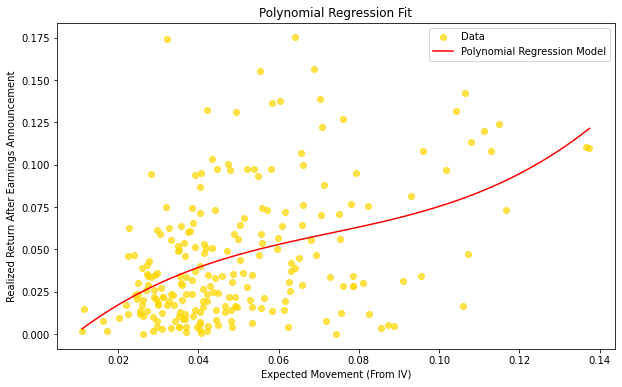

Mean Squared Error (MSE): 0.03450496651354188


In [282]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline

# Transform your features into polynomial features
degree = 3  # You can adjust the degree of the polynomial based on model performance
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Fit the model
poly_model.fit(x, y)

# Predict and evaluate
y_pred = poly_model.predict(x)


# Visualization
# For a nice curve, generate a lot of points within the range of x, then predict and plot
x_range = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
y_range_pred = poly_model.predict(x_range)

plt.figure(figsize=(10, 6))
plt.scatter(x, y, label= 'Data', color='gold', alpha=0.7)
plt.plot(x_range, y_range_pred, label='Polynomial Regression Model', color='red')
plt.xlabel('Expected Movement (From IV)')
plt.ylabel('Realized Return After Earnings Announcement')
plt.title('Polynomial Regression Fit')
plt.legend()
plt.show()

# Accuracy Analysis
mse = mean_squared_error(y, y_pred)

print(f"Mean Squared Error (MSE): {np.sqrt(mse)}")

Notice that our square root of MSE barely goes down when use a polynomial distribution of degree $3$, which should make sense

### Exploring variance risk premium

$$VRP = IV^2 - RV^2$$

In [77]:
#For ATM
def findImplVol(options_prices, ticker, date, spot_price):
    # Convert 'date' to datetime
    given_date = pd.to_datetime(date)

    while 1:
        # Filter options by ticker and date, and where expiration is soon after
        filtered_options = options_prices[
        (options_prices['ticker'] == ticker) &
        (options_prices['date'] == given_date) &
        (options_prices['exdate'] <= given_date + pd.Timedelta(days=31)) &
        (options_prices['exdate'] > given_date + pd.Timedelta(days=10))]

        if not filtered_options.empty:
            break  # Exit the loop since we have found the data
        else:
            given_date -= pd.Timedelta(days=1)  # Move the day back by 1

    # Calculate the absolute difference between the spot price and the strike price
    filtered_options = filtered_options.copy()
    filtered_options['strike_diff'] = abs(filtered_options['strike_price'] - spot_price)
    
    # Filter for call options
    filtered_options = filtered_options[filtered_options['cp_flag'] == 'C']
    # Sort by 'strike_diff'
    filtered_options = filtered_options.sort_values(by='strike_diff')

    impl_vol = filtered_options["impl_volatility"].iloc[0]

    return impl_vol

In [78]:
#Basis of calculation: annualized variance of daily log returns over 30 days.
def realizedVol(ticker, date):
    # Convert 'date' to datetime
    given_date = pd.to_datetime(date)

    filtered_returns = stock_returns_imp[(stock_returns_imp['ticker'] == ticker)
                    & (stock_returns_imp['date'] > given_date) 
                    & (stock_returns_imp['date'] <= given_date + pd.Timedelta(days=30))]

    realized_vol = float(np.std(filtered_returns['logRet']) * np.sqrt(251))

    return realized_vol

In [79]:
earnings_dates['implVol'] = 0

# Iterate over the earnings_dates DataFrame
for index, row in earnings_dates.iterrows():
    # Use the row's 'Ticker', 'EarningsDate', and 'Price_At_Earnings' for the function's parameters
    ticker = row['Ticker']
    date = row['EarningsDate'] - pd.Timedelta(days=1) if row['Earnings_timing'] == 'Pre' else row['EarningsDate']
    spot_price = row['Price_Before_Earnings']
    
    # Calculate the average straddle price
    implVol = findImplVol(options_prices_updated, ticker, date, spot_price)
    
    # Assign the calculated average straddle price to the new column
    earnings_dates.at[index, 'implVol'] = implVol

# Display or return the updated earnings_dates DataFrame
earnings_dates

/var/folders/cj/jcn0rhn52g397xd7gy7ndwnc0000gn/T/ipykernel_91988/1329121093.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.319989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  earnings_dates.at[index, 'implVol'] = implVol


,Stock,EarningsDate,Quarter,Year,Ticker,Earnings_timing,realized_earnings_1d,realized_earnings_2d,realized_earnings_5d,realized_earnings_10d,Price_Before_Earnings,Average_Straddle_Price,Expected_Move,Expected_Move_V2_viaIV,price_jump_vol,negSkew,Symbol,industry,implVol
0,AAPL,2020-01-28,4,2019,AAPL,After,0.020932,0.019453,0.003651,0.008465,317.69000,18.175,0.057210,0.042282,0.030453,0.106601,AAPL,Information Tech,0.319989
1,AAPL,2020-04-30,1,2020,AAPL,After,-0.016099,-0.002178,0.033833,0.056359,293.79999,13.685,0.046579,0.042252,0.043027,0.152940,AAPL,Information Tech,0.415162
2,AAPL,2020-07-30,2,2020,AAPL,After,0.104689,0.132525,0.184141,0.197861,384.76001,18.3975,0.047816,0.042237,0.043006,0.083935,AAPL,Information Tech,0.338961
3,AAPL,2020-10-29,3,2020,AAPL,After,-0.056018,-0.056799,0.032172,0.035519,115.32000,6.2625,0.054305,0.059891,0.065872,0.263048,AAPL,Information Tech,0.472602
4,AAPL,2021-01-27,4,2020,AAPL,After,-0.034985,-0.071097,-0.057159,-0.045522,142.06000,9.65,0.067929,0.075032,0.059833,0.087310,AAPL,Information Tech,0.557346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,XOM,2022-02-01,4,2021,XOM,Pre,0.064113,0.061348,0.084650,0.051339,75.96000,3.7575,0.049467,0.029735,0.017422,0.213426,XOM,Energy,0.349771
355,XOM,2022-04-29,1,2022,XOM,Pre,-0.022362,-0.009059,0.035665,-0.000229,87.20000,3.965,0.045470,0.036170,0.034535,0.183170,XOM,Energy,0.393303
356,XOM,2022-07-29,2,2022,XOM,Pre,0.046308,0.019862,-0.058831,0.015434,92.64000,3.95,0.042638,0.032666,0.029319,0.116161,XOM,Energy,0.367259
357,XOM,2022-10-28,3,2022,XOM,Pre,0.029289,0.030312,0.033009,0.027430,107.55000,4.3,0.039981,0.035688,0.033836,0.081040,XOM,Energy,0.365850


In [80]:
earnings_dates['realizedVol'] = 0

# Iterate over the earnings_dates DataFrame
for index, row in earnings_dates.iterrows():
    # Use the row's 'Ticker', 'EarningsDate', and 'Price_At_Earnings' for the function's parameters
    ticker = row['Ticker']
    date = row['EarningsDate'] - pd.Timedelta(days=1) if row['Earnings_timing'] == 'Pre' else row['EarningsDate']
    
    # Calculate the average straddle price
    realized_Vol = realizedVol(ticker, date)
    
    # Assign the calculated average straddle price to the new column
    earnings_dates.at[index, 'realizedVol'] = realized_Vol

# Display or return the updated earnings_dates DataFrame
earnings_dates

/var/folders/cj/jcn0rhn52g397xd7gy7ndwnc0000gn/T/ipykernel_91988/2080702659.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.3959759807199149' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  earnings_dates.at[index, 'realizedVol'] = realized_Vol


,Stock,EarningsDate,Quarter,Year,Ticker,Earnings_timing,realized_earnings_1d,realized_earnings_2d,realized_earnings_5d,realized_earnings_10d,Price_Before_Earnings,Average_Straddle_Price,Expected_Move,Expected_Move_V2_viaIV,price_jump_vol,negSkew,Symbol,industry,implVol,realizedVol
0,AAPL,2020-01-28,4,2019,AAPL,After,0.020932,0.019453,0.003651,0.008465,317.69000,18.175,0.057210,0.042282,0.030453,0.106601,AAPL,Information Tech,0.319989,0.395976
1,AAPL,2020-04-30,1,2020,AAPL,After,-0.016099,-0.002178,0.033833,0.056359,293.79999,13.685,0.046579,0.042252,0.043027,0.152940,AAPL,Information Tech,0.415162,0.188052
2,AAPL,2020-07-30,2,2020,AAPL,After,0.104689,0.132525,0.184141,0.197861,384.76001,18.3975,0.047816,0.042237,0.043006,0.083935,AAPL,Information Tech,0.338961,0.425346
3,AAPL,2020-10-29,3,2020,AAPL,After,-0.056018,-0.056799,0.032172,0.035519,115.32000,6.2625,0.054305,0.059891,0.065872,0.263048,AAPL,Information Tech,0.472602,0.340145
4,AAPL,2021-01-27,4,2020,AAPL,After,-0.034985,-0.071097,-0.057159,-0.045522,142.06000,9.65,0.067929,0.075032,0.059833,0.087310,AAPL,Information Tech,0.557346,0.256357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,XOM,2022-02-01,4,2021,XOM,Pre,0.064113,0.061348,0.084650,0.051339,75.96000,3.7575,0.049467,0.029735,0.017422,0.213426,XOM,Energy,0.349771,0.305403
355,XOM,2022-04-29,1,2022,XOM,Pre,-0.022362,-0.009059,0.035665,-0.000229,87.20000,3.965,0.045470,0.036170,0.034535,0.183170,XOM,Energy,0.393303,0.386964
356,XOM,2022-07-29,2,2022,XOM,Pre,0.046308,0.019862,-0.058831,0.015434,92.64000,3.95,0.042638,0.032666,0.029319,0.116161,XOM,Energy,0.367259,0.345232
357,XOM,2022-10-28,3,2022,XOM,Pre,0.029289,0.030312,0.033009,0.027430,107.55000,4.3,0.039981,0.035688,0.033836,0.081040,XOM,Energy,0.365850,0.276328


In [81]:
#calculate VRP
earnings_dates["VRP"] = earnings_dates["implVol"]**2 - earnings_dates["realizedVol"] **2
earnings_dates

,Stock,EarningsDate,Quarter,Year,Ticker,Earnings_timing,realized_earnings_1d,realized_earnings_2d,realized_earnings_5d,realized_earnings_10d,...,Average_Straddle_Price,Expected_Move,Expected_Move_V2_viaIV,price_jump_vol,negSkew,Symbol,industry,implVol,realizedVol,VRP
0,AAPL,2020-01-28,4,2019,AAPL,After,0.020932,0.019453,0.003651,0.008465,...,18.175,0.057210,0.042282,0.030453,0.106601,AAPL,Information Tech,0.319989,0.395976,-0.054404
1,AAPL,2020-04-30,1,2020,AAPL,After,-0.016099,-0.002178,0.033833,0.056359,...,13.685,0.046579,0.042252,0.043027,0.152940,AAPL,Information Tech,0.415162,0.188052,0.136996
2,AAPL,2020-07-30,2,2020,AAPL,After,0.104689,0.132525,0.184141,0.197861,...,18.3975,0.047816,0.042237,0.043006,0.083935,AAPL,Information Tech,0.338961,0.425346,-0.066024
3,AAPL,2020-10-29,3,2020,AAPL,After,-0.056018,-0.056799,0.032172,0.035519,...,6.2625,0.054305,0.059891,0.065872,0.263048,AAPL,Information Tech,0.472602,0.340145,0.107654
4,AAPL,2021-01-27,4,2020,AAPL,After,-0.034985,-0.071097,-0.057159,-0.045522,...,9.65,0.067929,0.075032,0.059833,0.087310,AAPL,Information Tech,0.557346,0.256357,0.244916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,XOM,2022-02-01,4,2021,XOM,Pre,0.064113,0.061348,0.084650,0.051339,...,3.7575,0.049467,0.029735,0.017422,0.213426,XOM,Energy,0.349771,0.305403,0.029069
355,XOM,2022-04-29,1,2022,XOM,Pre,-0.022362,-0.009059,0.035665,-0.000229,...,3.965,0.045470,0.036170,0.034535,0.183170,XOM,Energy,0.393303,0.386964,0.004946
356,XOM,2022-07-29,2,2022,XOM,Pre,0.046308,0.019862,-0.058831,0.015434,...,3.95,0.042638,0.032666,0.029319,0.116161,XOM,Energy,0.367259,0.345232,0.015694
357,XOM,2022-10-28,3,2022,XOM,Pre,0.029289,0.030312,0.033009,0.027430,...,4.3,0.039981,0.035688,0.033836,0.081040,XOM,Energy,0.365850,0.276328,0.057489


In [82]:
def plot(Column1, Column2, title):
    plt.figure(figsize=(10, 6))  # Optional: Specifies the figure size
    plt.scatter(earnings_dates[str(Column1)], earnings_dates[str(Column2)], alpha=0.5)  # Creates the scatter plot with some transparency
    plt.title(title)  # Sets the title of the plot
    plt.xlabel(Column1)  # Sets the label for the x-axis
    plt.ylabel(Column2)  # Sets the label for the y-axis
    plt.grid(True)  # Adds a grid for better readability
    plt.show()  # Displays the plot

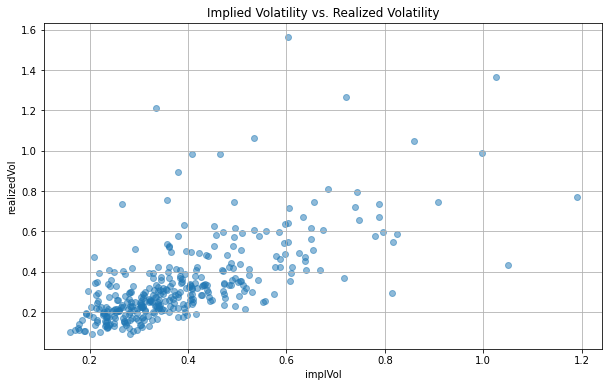

In [83]:
plot("implVol", "realizedVol", "Implied Volatility vs. Realized Volatility")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     284.1
Date:                Mon, 04 Mar 2024   Prob (F-statistic):           2.59e-47
Time:                        20:54:25   Log-Likelihood:                 166.21
No. Observations:                 359   AIC:                            -328.4
Df Residuals:                     357   BIC:                            -320.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0085      0.021      0.400      0.6

Text(0, 0.5, 'Residual')

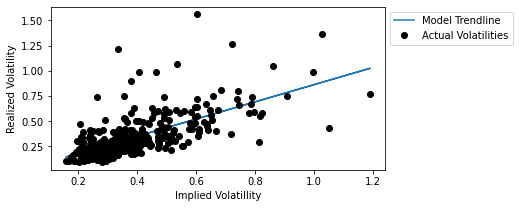

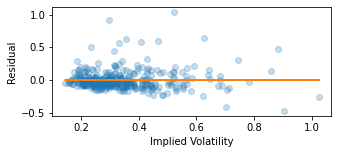

In [84]:
#Run linear regression
x = earnings_dates["implVol"].to_numpy()
y = earnings_dates["realizedVol"].to_numpy() ##just in total percnetage
X = sm.add_constant(x) # add a column of all 1s
model = sm.OLS(y,X) #run OLS

results = model.fit()
print(results.summary())
bhat, ahat = results.params #Grab values
print("Coefficients:")
print(bhat, ahat)
# Graph it
fig,ax = plt.subplots(figsize=(6,3))
ax.plot(x,ahat*x + bhat, '-', label="Model Trendline") # graph line of best fit
ax.plot(x,y,"ko",  label="Actual Volatilities")
ax.set_xlabel("Implied Volatillity")
ax.set_ylabel("Realized Volatility")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))


#Graph residuals
sigma_eps_hat = np.sqrt(results.mse_resid)
print("MSE: " +str(sigma_eps_hat))
r = results.resid
y_mean_pred = y - r
fig,ax = plt.subplots(figsize=(5,2))
ax.plot(y_mean_pred,r,"o", alpha = 0.25)  # Plot the residuals
ax.plot(y_mean_pred,np.zeros(len(y)),"-") # Plot the reference line of 0
ax.set_xlabel("Implied Volatility")
ax.set_ylabel("Residual")

VRP captures the cost of protection against general uncertainty-related volatility changes.

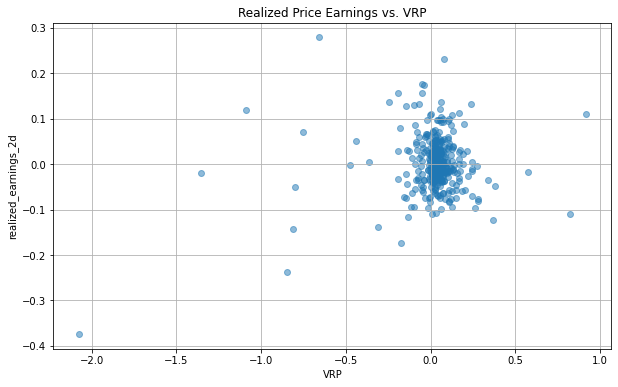

In [85]:
plot("VRP", "realized_earnings_2d", "Realized Price Earnings vs. VRP")

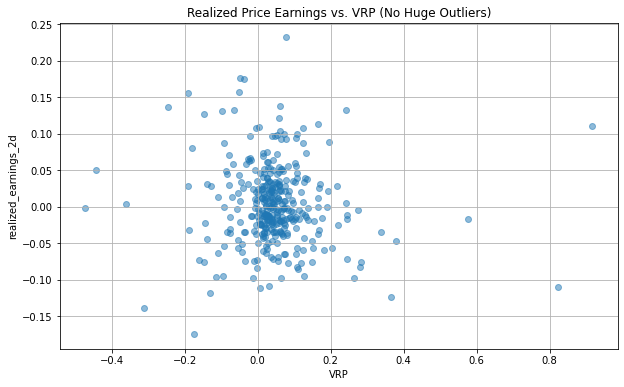

In [86]:
#Remove outliers
threshold = -0.5

# Filter the DataFrame to exclude rows beyond this threshold
final_df = earnings_dates[earnings_dates['VRP'] > threshold]

Column1 = "VRP"
Column2 = "realized_earnings_2d"

plt.figure(figsize=(10, 6))  # Optional: Specifies the figure size
plt.scatter(final_df[str(Column1)], final_df[str(Column2)], alpha=0.5)  # Creates the scatter plot with some transparency
plt.title("Realized Price Earnings vs. VRP (No Huge Outliers)")  # Sets the title of the plot
plt.xlabel(Column1)  # Sets the label for the x-axis
plt.ylabel(Column2)  # Sets the label for the y-axis
plt.grid(True)  # Adds a grid for better readability
plt.show()  # Displays the plot

/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


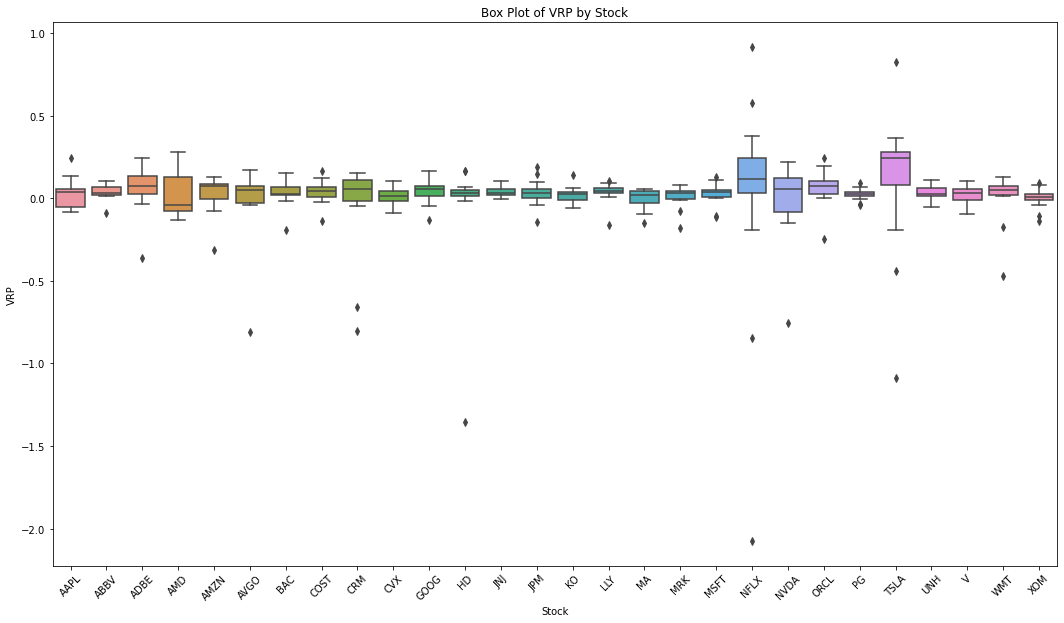

In [140]:
#colored version
plt.figure(figsize=(18, 10))

# Use seaborn's boxplot to plot, specifying 'industry' for hue to color by industry
sns.boxplot(data=earnings_dates, x='Stock', y='VRP')

plt.title('Box Plot of VRP by Stock')
plt.xlabel('Stock')
plt.ylabel('VRP')
plt.xticks(rotation=45)
#plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position

plt.show()

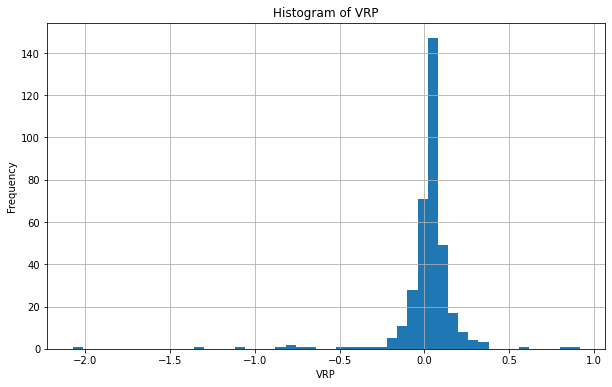

In [149]:
# Plotting using pandas
earnings_dates['VRP'].hist(bins=50, figsize=(10, 6))
plt.title('Histogram of VRP')
plt.xlabel('VRP')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Monte Carlo Trading Simulation

#### What if we just sold a straddle at the money every time? What would our PNL look like?

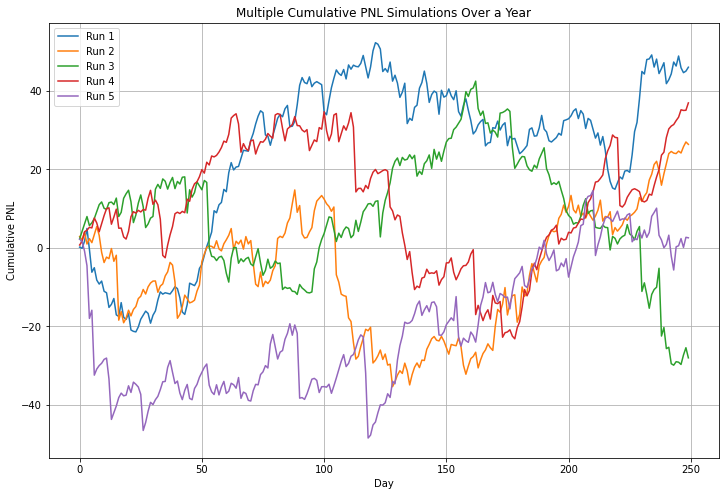

In [87]:
# Assuming a re-defined Black-Scholes function as before
# Imagine we sold one straddle evry day
np.random.seed(20)  # Resetting the seed for reproducibility

moves_realized = earnings_dates["realized_earnings_10d"].values #choose randomly
impl_vol = earnings_dates["implVol"].values

# Parameters
n_runs = 5  # Number of different simulations/plots
S_0 = 50
r = 0.03
n_simulations = 250

plt.figure(figsize=(12, 8))

# Running multiple simulations
for run in range(n_runs):
    np.random.seed(run)  # Change seed for each run to ensure different outcomes
    pnl = np.zeros(n_simulations)

    for i in range(n_simulations):
        random_index = np.random.randint(0, len(moves_realized))
        chosen_move_realized = moves_realized[random_index]
        chosen_impl_vol = impl_vol[random_index]

        call_value = bs("c", S_0, S_0, 10/250, r, chosen_impl_vol)
        put_value = bs("p", S_0, S_0, 10/250, r, chosen_impl_vol)
        final_S = S_0 * (1 + chosen_move_realized)
        loss = np.abs(final_S - S_0)

        pnl[i] = (call_value + put_value) - loss

    cumulative_pnl = np.cumsum(pnl)
    plt.plot(cumulative_pnl, label=f'Run {run+1}')

plt.title("Multiple Cumulative PNL Simulations Over a Year")
plt.xlabel("Day")
plt.ylabel("Cumulative PNL")
plt.legend()
plt.grid(True)
plt.show()

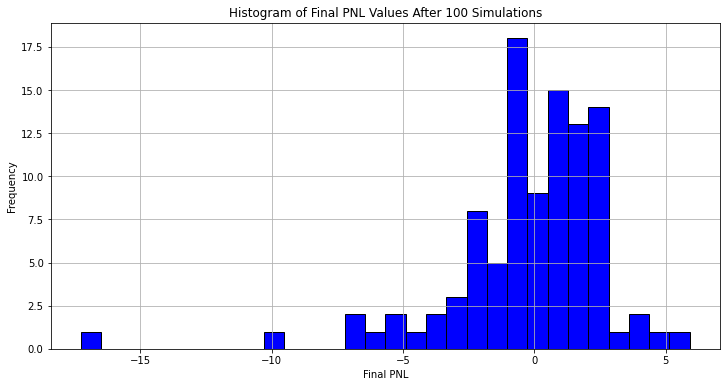

In [88]:
#Plot the final results:
# Adjusting the simulation to run 100 times and create a histogram of the final PNL values

n_runs = 100  # Increasing the number of simulations to 100
final_pnls = []  # To store the final PNL of each run

for run in range(n_runs):
    np.random.seed(run)  # Ensuring varied outcomes
    pnl = np.zeros(n_simulations)

    for i in range(n_simulations):
        random_index = np.random.randint(0, len(moves_realized))
        chosen_move_realized = moves_realized[random_index]
        chosen_impl_vol = impl_vol[random_index]

        call_value = bs("c", S_0, S_0, 10/250, r, chosen_impl_vol)
        put_value = bs("p", S_0, S_0, 10/250, r, chosen_impl_vol)
        final_S = S_0 * (1 + chosen_move_realized)
        loss = np.abs(final_S - S_0)

        pnl[i] = (call_value + put_value) - loss

    final_pnls.append(pnl[-1])  # Storing the final PNL of each run

# Plotting the histogram of the final PNL values
plt.figure(figsize=(12, 6))
plt.hist(final_pnls, bins=30, color='blue', edgecolor='black')
plt.title("Histogram of Final PNL Values After 100 Simulations")
plt.xlabel("Final PNL")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [147]:
np.mean(final_pnls)

-0.21088521245871594

In [148]:
np.median(final_pnls)

0.2718057629101587

This phenomenon between mean and median of pnl's reminds me of Taleb trading strategy (making money off the tails)

### Make box plots with stocks on the rows, and interesting data on y-axis

In [89]:
earnings_dates.columns

Index(['Stock', 'EarningsDate', 'Quarter', 'Year', 'Ticker', 'Earnings_timing',
       'realized_earnings_1d', 'realized_earnings_2d', 'realized_earnings_5d',
       'realized_earnings_10d', 'Price_Before_Earnings',
       'Average_Straddle_Price', 'Expected_Move', 'Expected_Move_V2_viaIV',
       'price_jump_vol', 'negSkew', 'Symbol', 'industry', 'implVol',
       'realizedVol', 'VRP'],
      dtype='object')

<Figure size 1008x432 with 0 Axes>

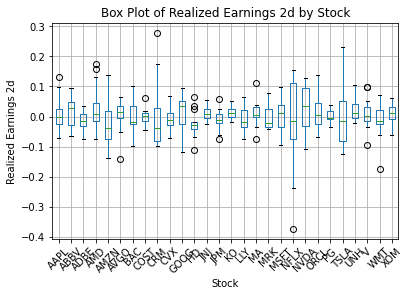

In [90]:
#not-colored
plt.figure(figsize=(14, 6))
boxplot = earnings_dates.boxplot(column=['realized_earnings_2d'], by='Stock')
plt.title('Box Plot of Realized Earnings 2d by Stock')
plt.suptitle('')  # To remove the default subtitle
plt.xlabel('Stock')
plt.ylabel('Realized Earnings 2d')
plt.xticks(rotation=45)
plt.show()

/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


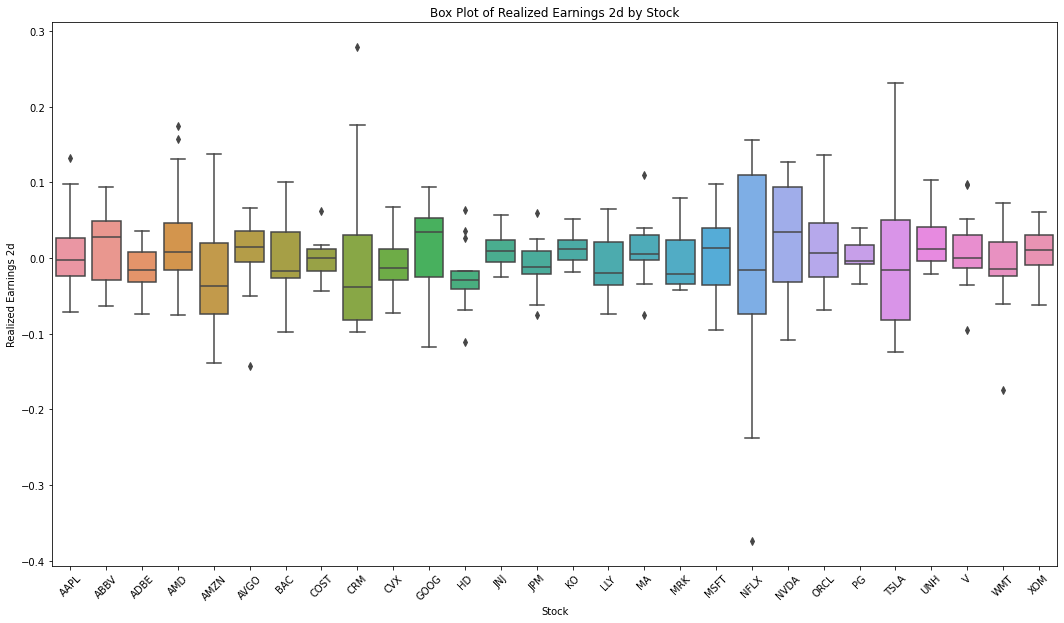

In [141]:
#colored version
plt.figure(figsize=(18, 10))

# Use seaborn's boxplot to plot, specifying 'industry' for hue to color by industry
sns.boxplot(data=earnings_dates, x='Stock', y='realized_earnings_2d')

plt.title('Box Plot of Realized Earnings 2d by Stock')
plt.xlabel('Stock')
plt.ylabel('Realized Earnings 2d')
plt.xticks(rotation=45)
#plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position

plt.show()

/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/charliemorris/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


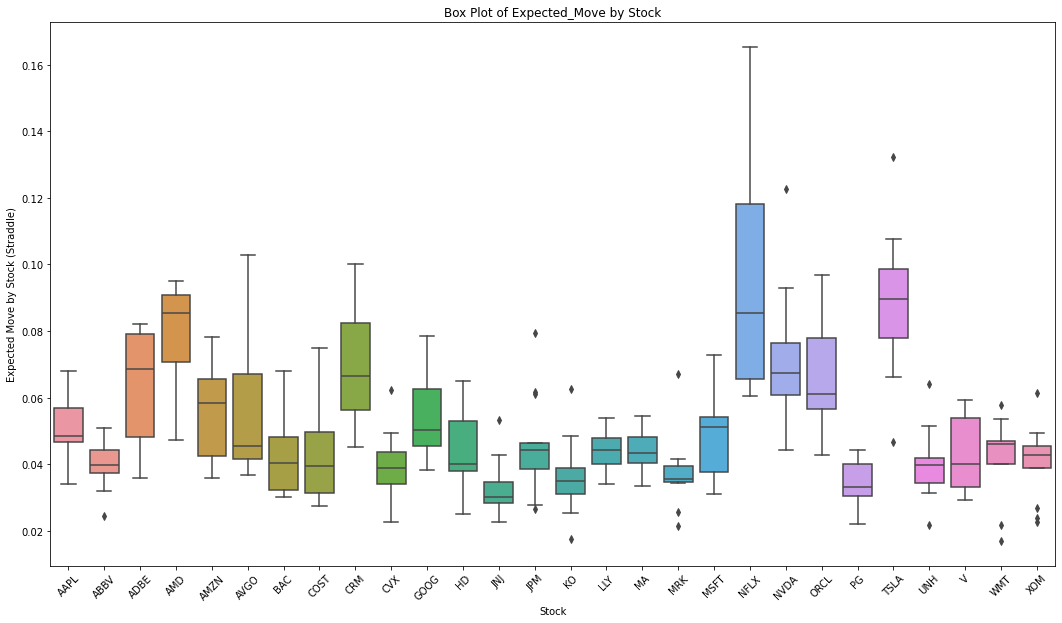

In [143]:
#colored version
plt.figure(figsize=(18, 10))

# Use seaborn's boxplot to plot, specifying 'industry' for hue to color by industry
sns.boxplot(data=earnings_dates, x='Stock', y='Expected_Move')

plt.title('Box Plot of Expected_Move by Stock')
plt.xlabel('Stock')
plt.ylabel('Expected Move by Stock (Straddle)')
plt.xticks(rotation=45)
#plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position

plt.show()

### Exploring IV Crush

In [125]:
def vol_curve(ex_dates,stock,data,curr_date):
    # will make multiple at a time
    for date in ex_dates:
        filtered = data[(data['ticker']==stock) & (data['date']==curr_date) & (data['exdate']==date)]
        impl_vol = np.array(filtered['impl_volatility'])
        strikes = np.array(filtered['strike_price'])
        plt.figure(figsize=(10, 6))
        plt.plot(strikes, impl_vol, 'o-', label='Implied Volatility')
        plt.xlabel('Strike Price')
        plt.ylabel('Implied Volatility')
        date_string = np.datetime_as_string(curr_date, unit='D')
        plt.title(f'Volatility Smile for {stock} on {date_string} expiring {date}')
        plt.legend()
        plt.show()

In [130]:
def vol_curve_before_after_earnings(stock, data, option_length_in_days, earnings_data, day_away = 0):
    day_away= int(day_away)
    option_length_in_days = int(option_length_in_days)
    filtered = earnings_data[earnings_data['Stock'] == stock]
    
    if filtered['Earnings_timing'].iloc[0] == 'After':
        curr_dates = np.array(filtered['EarningsDate']) + np.timedelta64(1+day_away, 'D')
    else:
        curr_dates = np.array(filtered['EarningsDate'])+ np.timedelta64(day_away, 'D')
    
    diff_array = np.array([])
    for date in curr_dates:
        after_date = np.datetime64(date, 'D')
        found = False
        while not found:
            if after_date in data[(data['ticker'] == stock)]['date'].values:
                found = True
            else:
                after_date = after_date + np.timedelta64(1, 'D')
    
        found = False
        
        pre_date = np.datetime64(date, 'D') - np.timedelta64(1, 'D')
        while not found:
            if pre_date in data[(data['ticker'] == stock)]['date'].values:
                found = True
            else:
                pre_date = pre_date - np.timedelta64(1, 'D')
    
        ex_date1 = pre_date + np.timedelta64(option_length_in_days, 'D')
        found = False
        while not found:
            if ex_date1 in data[(data['ticker'] == stock) & (data['date'] == pre_date)]['exdate'].values:
                found = True
            else:
                ex_date1 = ex_date1 + np.timedelta64(1, 'D')
            
        ex_date2 = after_date + np.timedelta64(option_length_in_days, 'D')
        found = False
        if ex_date2 in data[(data['ticker'] == stock) & (data['date'] == after_date)]['exdate'].values:
            found = True
        elif ex_date1 in data[(data['ticker'] == stock) & (data['date'] == after_date)]['exdate'].values:
            found=True
            ex_date2=ex_date1
        while not found:
            if ex_date2 in data[(data['ticker'] == stock) & (data['date'] == after_date)]['exdate'].values:
                found = True
            else:
                print('check')
                ex_date2 = np.datetime64(ex_date2, 'D') + np.timedelta64(1, 'D')
        
        filtered1 = data[(data['ticker'] == stock) & (data['date'] == pre_date) & (data['exdate'] == ex_date1)]
        impl_vol1 = np.array(filtered1['impl_volatility'])
        strikes1 = np.array(filtered1['strike_price'])
        
        filtered2 = data[(data['ticker'] == stock) & (data['date'] == after_date) & (data['exdate'] == ex_date2)]
        impl_vol2 = np.array(filtered2['impl_volatility'])
        strikes2 = np.array(filtered2['strike_price'])
        
        # Fit polynomial curves
        degree = 3
        poly_fit1 = np.polyfit(strikes1, impl_vol1, degree)
        poly_fit2 = np.polyfit(strikes2, impl_vol2, degree)
        
        # Generate smoothed curves
        strikes1_smooth = np.linspace(strikes1.min(), strikes1.max(), 100)
        strikes2_smooth = np.linspace(strikes2.min(), strikes2.max(), 100)
        impl_vol1_smooth = np.polyval(poly_fit1, strikes1_smooth)
        impl_vol2_smooth = np.polyval(poly_fit2, strikes2_smooth)

        #Show spot prices change
        filtered_row = data[(data['ticker'] == stock) & (data['date'] == pre_date)]
        before_price = filtered_row['OPENPRC'].iloc[0]
        filtered_row = data[(data['ticker'] == stock) & (data['date'] == after_date)]
        after_price = filtered_row['OPENPRC'].iloc[0]
       
        
        # Plot
        plt.figure(figsize=(10, 6))
        plt.plot(strikes1, impl_vol1, 'o', color='red', label='Original Data Before')
        plt.plot(strikes2, impl_vol2, 'o', color='blue', label='Original Data After')
        plt.plot(strikes1_smooth, impl_vol1_smooth, color='orange', label='Polynomial Fit Before')
        plt.plot(strikes2_smooth, impl_vol2_smooth, color='cyan', label='Polynomial Fit After')
        
        # Add vertical lines for 1st and 2nd month option expirations
        #plt.axvline(x=before_price, color='red', linestyle='--', lw=1, label='Price Before Earnings Date')
        #plt.axvline(x=after_price, color='blue', linestyle='--', lw=1, label='Price After Earnings Date')

        plt.xlabel('Strike Price')
        plt.ylabel('Implied Volatility')
        date_string = np.datetime_as_string(date, unit='D')
        plt.title(f'Volatility Smile Before and After Earnings Report Release on {date_string} for {option_length_in_days} day option of {stock}')
        plt.legend()
        plt.show()

In [131]:
#Same as above, but now find averages for each company (takes while to load)
def vol_change(data, option_length_in_days, earnings_data):
    diff_stocks_array = np.array([])
    stock_symbols = np.unique(earnings_data['Stock'])
    option_length_in_days = int(option_length_in_days)
    for stock in stock_symbols:
        # for tracking when load
        #print(stock)
        filtered = earnings_data[earnings_data['Stock'] == stock]
        if filtered['Earnings_timing'].iloc[0] == 'After':
            curr_dates = np.array(filtered['EarningsDate']) + np.timedelta64(1, 'D')
        else:
            curr_dates = np.array(filtered['EarningsDate'])
 
        diff_array = np.array([])
        for date in curr_dates:
            after_date = np.datetime64(date, 'D')
            found = False
            while not found:
                if after_date in data[(data['ticker'] == stock)]['date'].values:
                    found = True
                else:
                    after_date = after_date + np.timedelta64(1, 'D')
    
            found = False
        
            pre_date = np.datetime64(date, 'D') - np.timedelta64(1, 'D')
            while not found:
                if pre_date in data[(data['ticker'] == stock)]['date'].values:
                    found = True
                else:
                    pre_date = pre_date - np.timedelta64(1, 'D')
    
            ex_date1 = pre_date + np.timedelta64(option_length_in_days, 'D')
            found = False
            while not found:
                if ex_date1 in data[(data['ticker'] == stock) & (data['date'] == pre_date)]['exdate'].values:
                    found = True
                else:
                    ex_date1 = ex_date1 + np.timedelta64(1, 'D')
            
            ex_date2 = after_date + np.timedelta64(option_length_in_days, 'D')
            found = False
            if ex_date2 in data[(data['ticker'] == stock) & (data['date'] == after_date)]['exdate'].values:
                found = True
            elif ex_date1 in data[(data['ticker'] == stock) & (data['date'] == after_date)]['exdate'].values:
                found=True
                ex_date2=ex_date1
            while not found:
                if ex_date2 in data[(data['ticker'] == stock) & (data['date'] == after_date)]['exdate'].values:
                    found = True
                else:
                    ex_date2 = np.datetime64(ex_date2, 'D') + np.timedelta64(1, 'D')
            
       
            filtered1 = data[(data['ticker'] == stock) & (data['date'] == pre_date) & (data['exdate'] == ex_date1)]
            impl_vol1 = np.array(filtered1['impl_volatility'])
            strikes1 = np.array(filtered1['strike_price'])

            filtered2 = data[(data['ticker'] == stock) & (data['date'] == after_date) & (data['exdate'] == ex_date2)]
            impl_vol2 = np.array(filtered2['impl_volatility'])
            strikes2 = np.array(filtered2['strike_price'])
        
            #min1=np.percentile(impl_vol1, 10)
            #min2=np.percentile(impl_vol2, 10)
            min1 = min(impl_vol1)
            min2 = min(impl_vol2)
            min_change = min1-min2
            diff_array = np.append(diff_array, min_change)

        
        average_avg_diff = np.mean(diff_array)
        diff_stocks_array= np.append(diff_stocks_array, average_avg_diff)
    
    main_array = np.array([[stock_symbols[i], diff_stocks_array[i]] for i in range(len(diff_stocks_array))], dtype=object)
    sorted_indices = np.argsort(main_array[:, 1])[::-1]
    sorted_main_array = main_array[sorted_indices]
    #print(sorted_main_array)
    return sorted_main_array

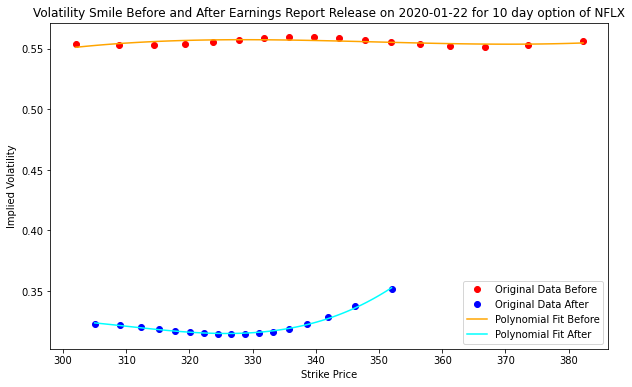

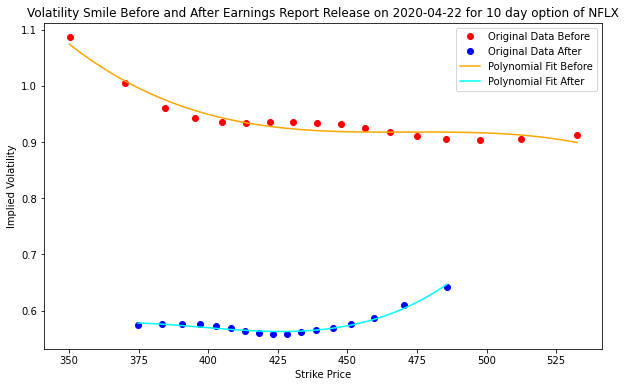

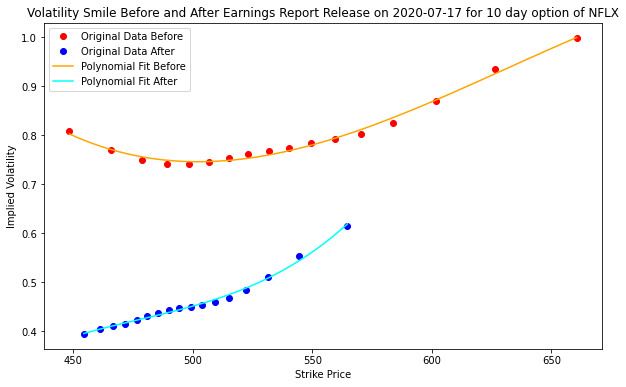

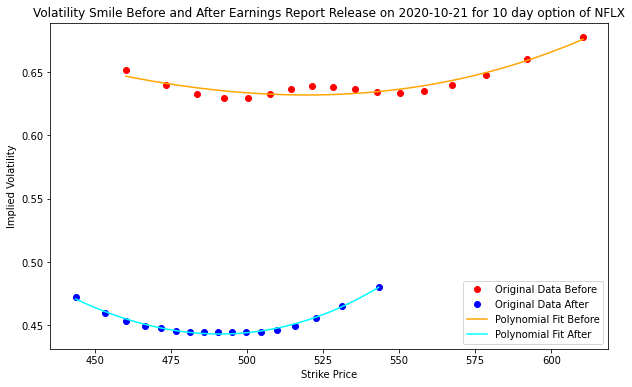

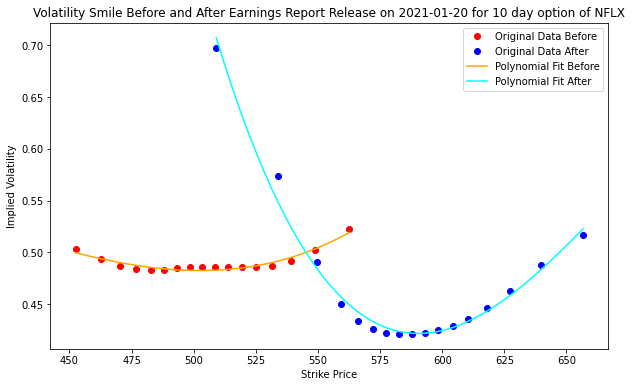

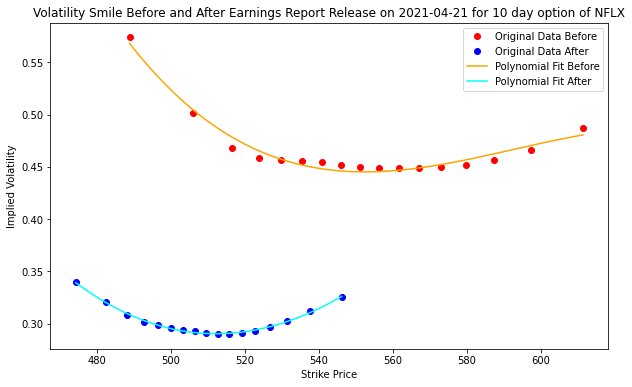

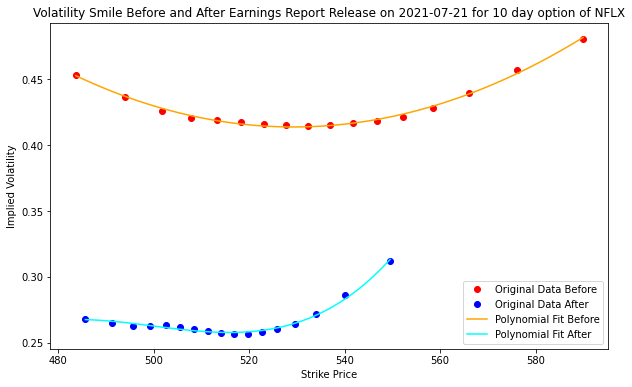

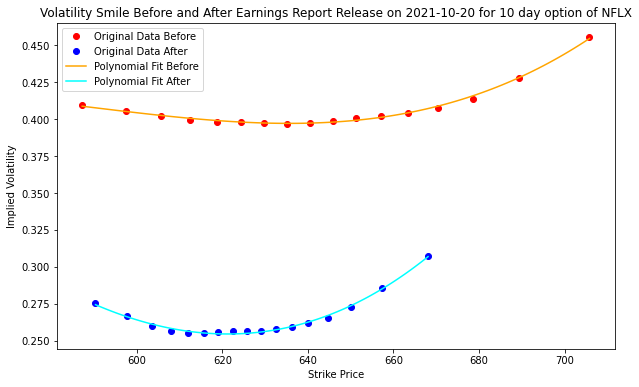

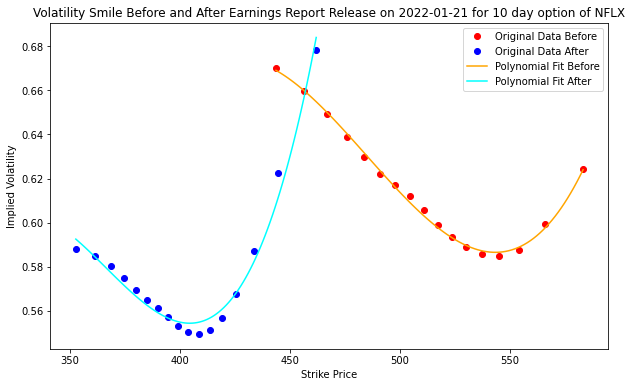

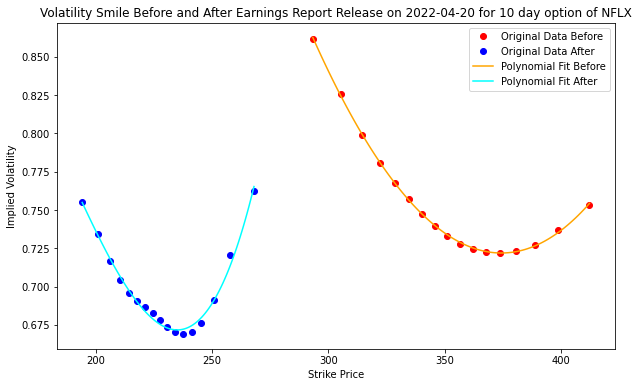

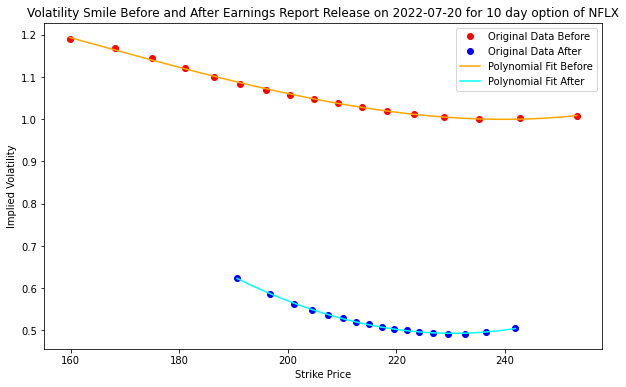

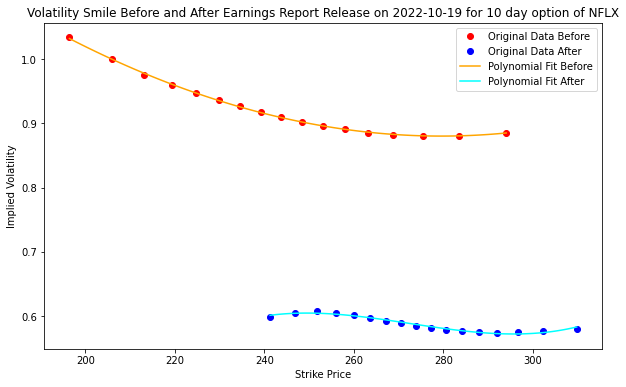

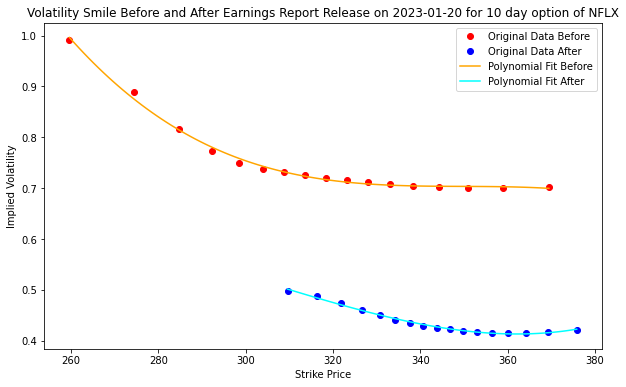

In [132]:
vol_curve_before_after_earnings('NFLX', vol_surfaces_imp,10,earnings_dates)

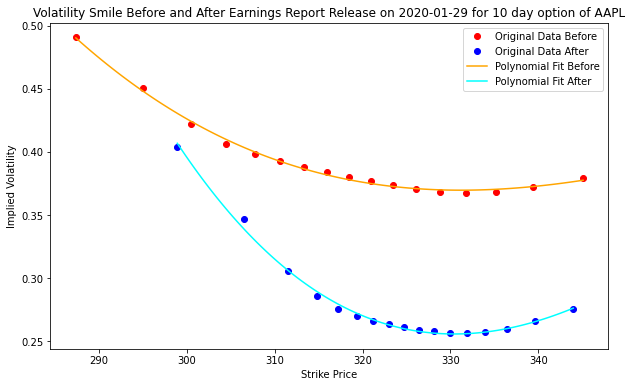

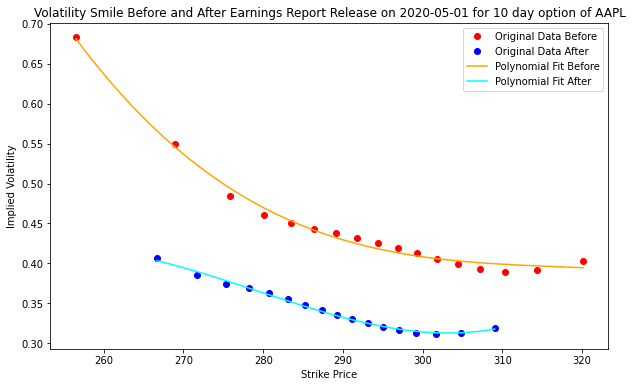

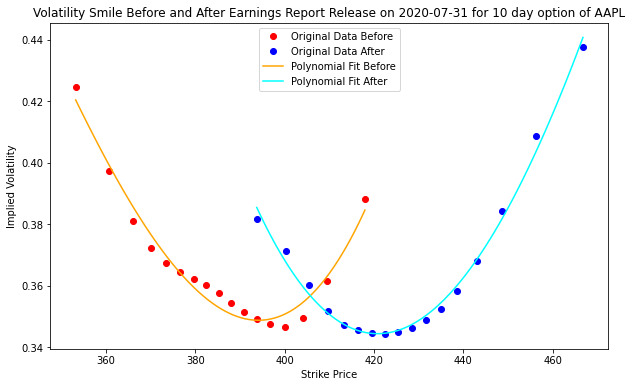

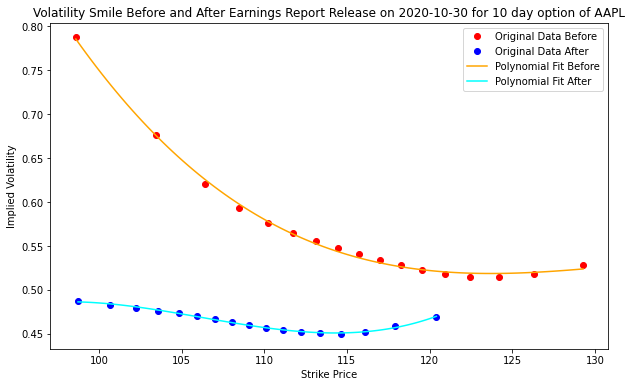

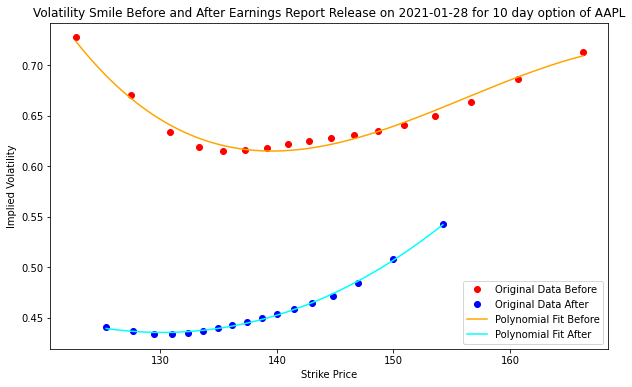

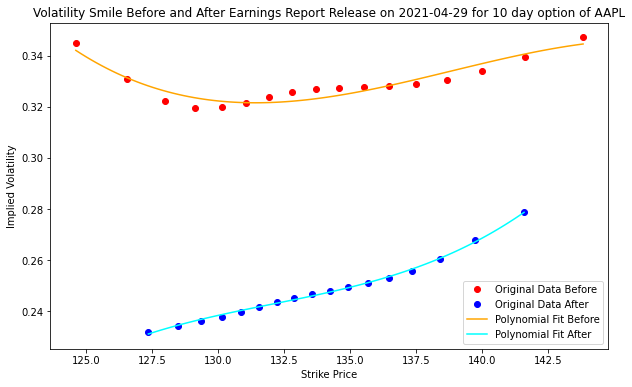

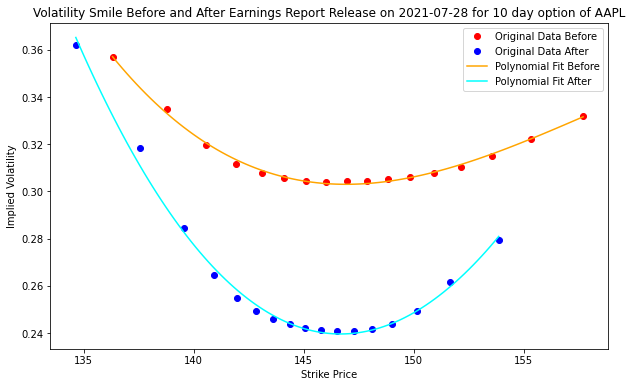

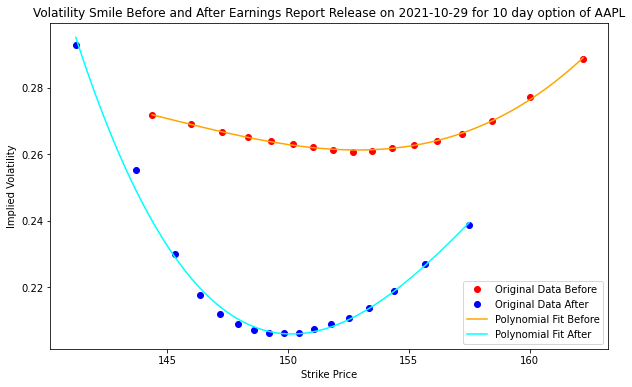

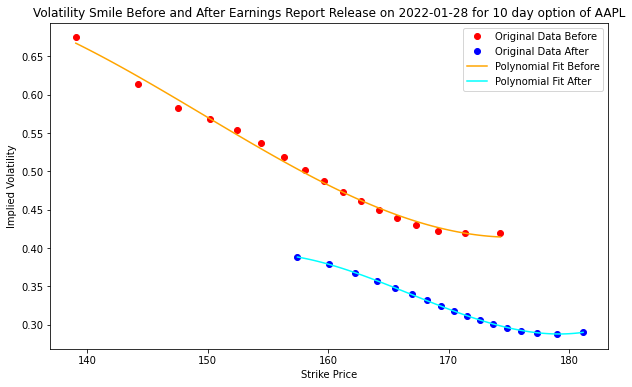

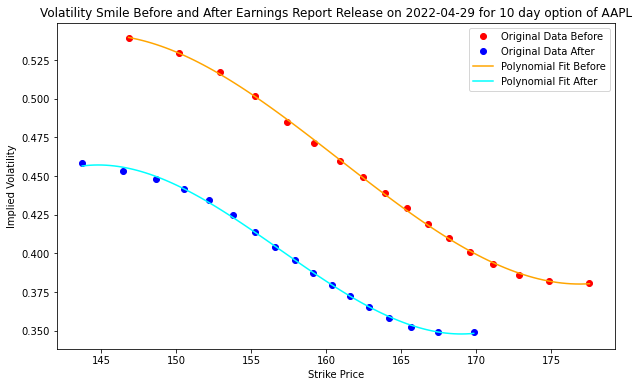

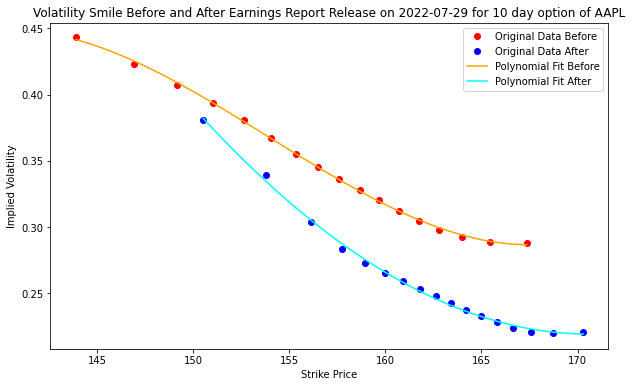

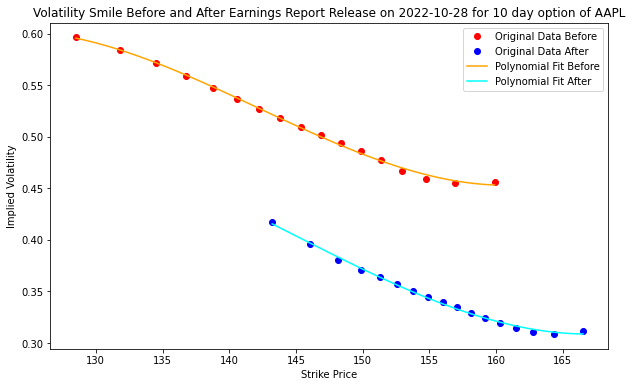

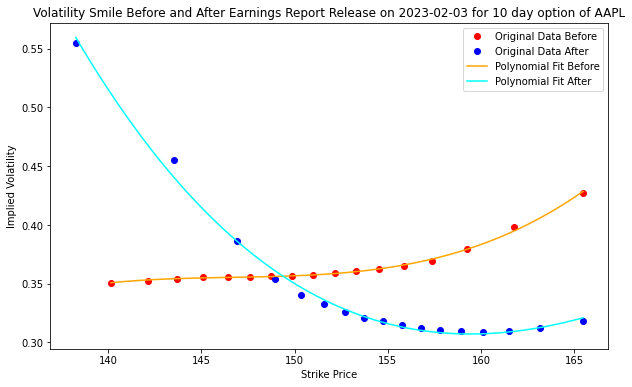

In [133]:
vol_curve_before_after_earnings('AAPL', vol_surfaces_imp,10,earnings_dates)

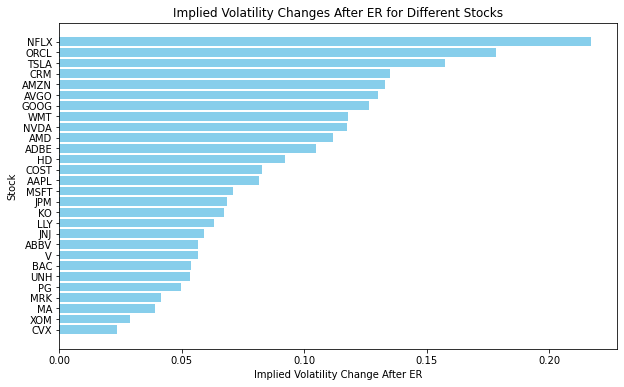

In [134]:
iv_changes_ers_2=vol_change(vol_surfaces_imp,10,earnings_dates)
stock_symbols = iv_changes_ers_2[:, 0]
values = iv_changes_ers_2[:, 1].astype(float)

plt.figure(figsize=(10, 6))
plt.barh(stock_symbols, values, color='skyblue')
plt.xlabel('Implied Volatility Change After ER')
plt.ylabel('Stock')
plt.title('Implied Volatility Changes After ER for Different Stocks')
plt.gca().invert_yaxis()
plt.show()

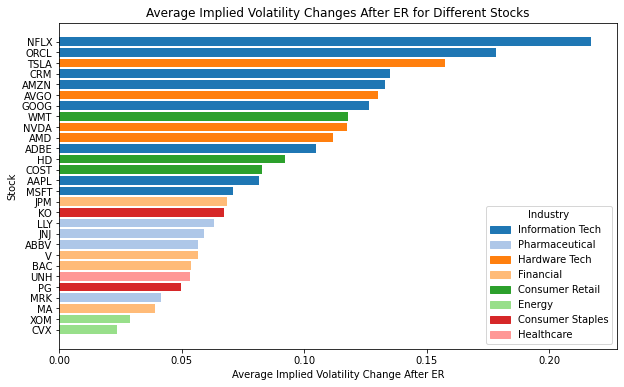

In [135]:
#Add color now:
# Map each stock symbol to its industry.
stock_to_industry = stocks.set_index('Symbol')['industry'].to_dict()

# Assign a unique color to each industry.
industry_colors = {
    industry: plt.cm.tab20(i)
    for i, industry in enumerate(stocks['industry'].unique())
}

# Map each stock symbol to its respective color based on industry.
colors = [industry_colors[stock_to_industry[symbol]] if symbol in stock_to_industry else 'gray' for symbol in stock_symbols]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(stock_symbols, values, color=colors)
plt.xlabel('Average Implied Volatility Change After ER')
plt.ylabel('Stock')
plt.title('Average Implied Volatility Changes After ER for Different Stocks')
plt.gca().invert_yaxis()

# Create a legend for the colors.
handles = [plt.Rectangle((0,0),1,1, color=industry_colors[industry]) for industry in industry_colors]
plt.legend(handles, industry_colors.keys(), title="Industry")

plt.show()

### Possible Trading Stragey (reversion)

In [286]:
earnings_dates

,Stock,EarningsDate,Quarter,Year,Ticker,Earnings_timing,realized_earnings_1d,realized_earnings_2d,realized_earnings_5d,realized_earnings_10d,Price_Before_Earnings,Average_Straddle_Price,Expected_Move,Expected_Move_V2_viaIV,price_jump_vol,negSkew,Symbol,industry
0,AAPL,2020-01-28,4,2019,AAPL,After,0.020932,0.019453,0.003651,0.008465,317.69000,18.175,0.057210,0.042282,0.030453,0.106601,AAPL,Hardware Tech
1,AAPL,2020-04-30,1,2020,AAPL,After,-0.016099,-0.002178,0.033833,0.056359,293.79999,13.685,0.046579,0.042252,0.043027,0.152940,AAPL,Hardware Tech
2,AAPL,2020-07-30,2,2020,AAPL,After,0.104689,0.132525,0.184141,0.197861,384.76001,18.3975,0.047816,0.042237,0.043006,0.083935,AAPL,Hardware Tech
3,AAPL,2020-10-29,3,2020,AAPL,After,-0.056018,-0.056799,0.032172,0.035519,115.32000,6.2625,0.054305,0.059891,0.065872,0.263048,AAPL,Hardware Tech
4,AAPL,2021-01-27,4,2020,AAPL,After,-0.034985,-0.071097,-0.057159,-0.045522,142.06000,9.65,0.067929,0.075032,0.059833,0.087310,AAPL,Hardware Tech
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,XOM,2022-02-01,4,2021,XOM,Pre,0.064113,0.061348,0.084650,0.051339,75.96000,3.7575,0.049467,0.029735,0.017422,0.213426,XOM,Energy
355,XOM,2022-04-29,1,2022,XOM,Pre,-0.022362,-0.009059,0.035665,-0.000229,87.20000,3.965,0.045470,0.036170,0.034535,0.183170,XOM,Energy
356,XOM,2022-07-29,2,2022,XOM,Pre,0.046308,0.019862,-0.058831,0.015434,92.64000,3.95,0.042638,0.032666,0.029319,0.116161,XOM,Energy
357,XOM,2022-10-28,3,2022,XOM,Pre,0.029289,0.030312,0.033009,0.027430,107.55000,4.3,0.039981,0.035688,0.033836,0.081040,XOM,Energy


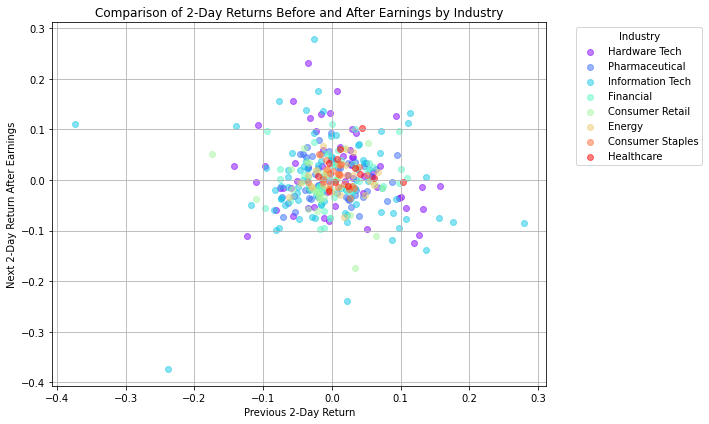

In [291]:
# Sort values by Ticker and EarningsDate to ensure correct lagged feature calculation
earnings_dates_sorted = earnings_dates.sort_values(['Ticker', 'EarningsDate'])

# Group by Ticker and shift the realized_earnings_2d to get the previous 2-day return
earnings_dates_sorted['prev_realized_earnings_2d'] = earnings_dates_sorted.groupby('Ticker')['realized_earnings_2d'].shift(1)

# Drop NaN values that will appear from shifting
earnings_dates_cleaned = earnings_dates_sorted.dropna(subset=['prev_realized_earnings_2d'])

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Get unique industries for color coding
industries = earnings_dates_cleaned['industry'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(industries)))

for industry, color in zip(industries, colors):
    industry_data = earnings_dates_cleaned[earnings_dates_cleaned['industry'] == industry]
    ax.scatter(industry_data['prev_realized_earnings_2d'], industry_data['realized_earnings_2d'], label=industry, color=color, alpha=0.5)

ax.set_xlabel('Previous 2-Day Return')
ax.set_ylabel('Next 2-Day Return After Earnings')
ax.set_title('Comparison of 2-Day Returns Before and After Earnings by Industry')
ax.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.grid(True)
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8035
Date:                Tue, 05 Mar 2024   Prob (F-statistic):              0.371
Time:                        23:48:15   Log-Likelihood:                 447.64
No. Observations:                 331   AIC:                            -891.3
Df Residuals:                     329   BIC:                            -883.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.003      0.701      0.4

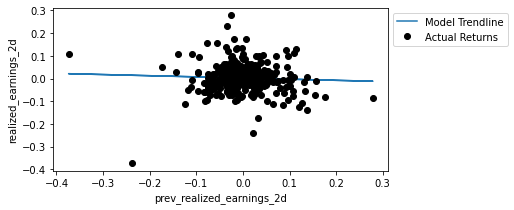

In [296]:
#Run linear regression
x = earnings_dates_cleaned['prev_realized_earnings_2d'].to_numpy()
y = earnings_dates_cleaned['realized_earnings_2d'].to_numpy() ##just in total percnetage
X = sm.add_constant(x) # add a column of all 1s
model = sm.OLS(y,X) #run OLS

results = model.fit()
print(results.summary())
bhat, ahat = results.params #Grab values
print("Coefficients:")
print(bhat, ahat)
# Graph it
fig,ax = plt.subplots(figsize=(6,3))
ax.plot(x,ahat*x + bhat, '-', label="Model Trendline") # graph line of best fit
ax.plot(x,y,"ko",  label="Actual Returns")
ax.set_xlabel("prev_realized_earnings_2d")
ax.set_ylabel("realized_earnings_2d")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))


#Graph residuals
sigma_eps_hat = np.sqrt(results.mse_resid)
print("MSE: " +str(sigma_eps_hat))

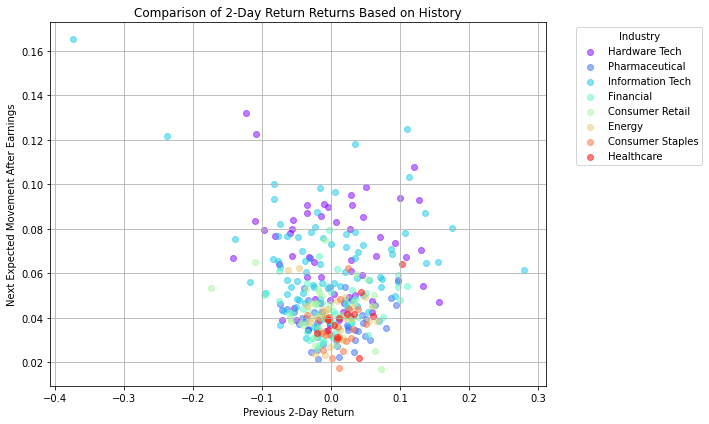

In [294]:
# Sort values by Ticker and EarningsDate to ensure correct lagged feature calculation
earnings_dates_sorted = earnings_dates.sort_values(['Ticker', 'EarningsDate'])

# Group by Ticker and shift the realized_earnings_2d to get the previous 2-day return
earnings_dates_sorted['prev_realized_earnings_2d'] = earnings_dates_sorted.groupby('Ticker')['realized_earnings_2d'].shift(1)

# Drop NaN values that will appear from shifting
earnings_dates_cleaned = earnings_dates_sorted.dropna(subset=['prev_realized_earnings_2d'])

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Get unique industries for color coding
industries = earnings_dates_cleaned['industry'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(industries)))

for industry, color in zip(industries, colors):
    industry_data = earnings_dates_cleaned[earnings_dates_cleaned['industry'] == industry]
    ax.scatter(industry_data['prev_realized_earnings_2d'], industry_data['Expected_Move'], label=industry, color=color, alpha=0.5)

ax.set_xlabel('Previous 2-Day Return After Earnings')
ax.set_ylabel('Next Expected Movement After Earnings')
ax.set_title('Comparison of 2-Day Return Returns Based on History')
ax.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.grid(True)
plt.show()

Looks like a reversion to the mean phenomenon in terms of predictions; with more time, we could explore that